<a href="https://colab.research.google.com/github/wlmoi/123asd/blob/main/QFT_3Qubits_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OpenLane Colab

This Google Colab notebook will:
* Install OpenLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [ ]:
# @title Setup Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/master/logo/nix-snowflake.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing OpenLane 2.
# @markdown
# @markdown This step installs the Nix package manager and enables the
# @markdown experimental "flakes" feature.
# @markdown
# @markdown If you're not in a Colab, this just sets the environment variables.
# @markdown You will need to install Nix and enable flakes on your own following
# @markdown [this guide](https://openlane2.readthedocs.io/en/stable/getting_started/common/nix_installation/index.html).
import os
import sys
import shutil

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

In [ ]:
# @title Get OpenLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install OpenLane.
# @markdown
# @markdown This will install OpenLane's tool dependencies using Nix,
# @markdown and OpenLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

openlane_version = "version-2.1"  # @param {key:"OpenLane Version", type:"string"}

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "gf180mcu"  # @param {key:"PDK (without the variant)", type:"string"}

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 9491k    0 9491k    0     0   9.9M      0 --:--:-- --:--:-- --:--:--  9.9M


Version bdc9412b3e468c102d01b7cf6337be06ec6e9c9a enabled for the gf180mcu PDK.

In [ ]:
import openlane

print(openlane.__version__)

2.1.11


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://openlane2.readthedocs.io/en/latest/reference/api/config/index.html#openlane.config.Config.interactive).



In [ ]:
from openlane.config import Config
from openlane.steps import Step
Synthesis = Step.factory.get("Yosys.Synthesis")

In [ ]:
import os
from openlane.config import Config

# --- Step 1: Set OpenLane Environment Variables ---
# Variabel-variabel ini mengontrol perilaku alat EDA yang mendasarinya.
# Mereka menimpa nilai default di config.json dan mengaktifkan optimisasi agresif.

# Kontrol Aliran Umum
os.environ['QUIT_ON_TIMING_VIOLATIONS'] = '0'
os.environ['DESIGN_OPTIMIZATION_MAX_ITERATIONS'] = '10'

# Sintesis (Yosys)
os.environ['SYNTH_USE_LVT_CELLS'] = '1'
os.environ['SYNTH_MAX_BUFFER_INSERTIONS'] = '100000'
os.environ['SYNTH_MAP_FOR_TIMING_DRIVEN'] = '1'
os.environ['SYNTH_ABC_BUFFERING'] = '1'
os.environ['SYNTH_SIZING'] = '1'
# >>> PENYESUAIAN 1: MENGAKTIFKAN SYNTH_DIRECT_WIRE_BUFFERING <<<
# Memastikan Yosys menyisipkan buffer pada koneksi kawat langsung, membantu slew dari awal.
os.environ['SYNTH_DIRECT_WIRE_BUFFERING'] = '1' # Diaktifkan secara eksplisit

# Penempatan (OpenROAD)
os.environ['PL_REPAIR_HOLD_VIOLATIONS'] = '1'
os.environ['PL_MAX_DISPLACEMENT'] = '0.05'
os.environ['PL_TIME_DRIVEN'] = '1'

# Sintesis Pohon Jam (CTS) (OpenROAD)
os.environ['CTS_MAX_SLEW'] = '0.01'
os.environ['CTS_MAX_CAP'] = '0.01'
os.environ['CTS_MAX_SKEW'] = '0.01'
os.environ['CTS_HOLD_SLACK_MARGIN'] = '0.050'
os.environ['CTS_BALANCE_LEVELS'] = '1'
os.environ['CTS_AUTO_ADJUST_LAYER_DISTRIBUTION'] = '1'
os.environ['CTS_TOLERANCE'] = '0.00'

# Routing (Global & Detailed)
os.environ['GRT_OPT_EFFORT'] = 'VERY_HIGH'
os.environ['DRT_OPT_EFFORT'] = 'VERY_HIGH'

# >>> PENYESUAIAN 2: DRT_AUTO_BUFFER_UTILIZATION_FACTOR LEBIH AGGRESIF <<<
# Meningkatkan agresi router untuk penyisipan buffer lebih jauh lagi.
os.environ['DRT_AUTO_BUFFER_UTILIZATION_FACTOR'] = '3.5'
os.environ['GRT_REPAIR_MAX_WIRE_LENGTH'] = '1'
os.environ['DRT_REPAIR_MAX_WIRE_LENGTH'] = '1'
os.environ['DRT_MAX_ITERATIONS'] = '20'
os.environ['GRT_ALLOW_PIN_SWAP'] = '1'
os.environ['DRT_ALLOW_PIN_SWAP'] = '1'
os.environ['GLB_RT_MAX_DENSITY'] = '0.7'
os.environ['DRT_FIX_GDS_ALIGNMENT'] = '1'

# Mengesampingkan Batasan Global dari config.json secara langsung melalui Variabel Lingkungan
# >>> PENYESUAIAN 3: MENAIKKAN MAX_TRANSITION_CONSTRAINT SECARA REALISTIS <<<
os.environ['MAX_TRANSITION_CONSTRAINT'] = '0.20'
os.environ['CLOCK_UNCERTAINTY_CONSTRAINT'] = '0.05'
os.environ['CLOCK_TRANSITION_CONSTRAINT'] = '0.10'

# Post-Routing Optimization
os.environ['DESIGN_OPTIMIZATION_POST_ROUTING'] = '1'
os.environ['DESIGN_OPTIMIZATION_DRIVING_CELL_MAX_AREA'] = '2000'
os.environ['DESIGN_OPTIMIZATION_BUFFER_REPEATING_MAX_AREA'] = '2000'
os.environ['DESIGN_OPTIMIZATION_SLACK_TOLERANCE'] = '0.001'

# >>> PENYESUAIAN 4: DESIGN_REPAIR_MAX_WIRE_LENGTH LEBIH KETAT <<<
# Menurunkan ambang batas panjang kabel untuk perbaikan, memicu penyisipan buffer pada kabel yang lebih pendek.
os.environ['DESIGN_REPAIR_MAX_WIRE_LENGTH'] = '400'

# >>> PENYESUAIAN 3: RSZ_OPTIMIZE_DRIVERS <<<
# Ini adalah variabel yang spesifik untuk resizer (alat optimisasi pasca-routing).
# Jika ada, ini akan secara eksplisit memaksa resizer untuk fokus pada memperkuat driver.
# (Perlu verifikasi apakah ini valid di versi OpenLane Anda)
os.environ['RSZ_OPTIMIZE_DRIVERS'] = '1' # Mengaktifkan optimisasi driver pada resizer.

# >>> PENYESUAIAN 4: RSZ_AUTO_TIE <<<
# Beberapa resizer memiliki kemampuan untuk secara otomatis mengikat pin VDD/VSS yang mengambang.
# Ini penting untuk keandalan dan kadang-kadang dapat membantu membersihkan masalah kecil.
os.environ['RSZ_AUTO_TIE'] = '1' # Mengaktifkan pengikatan otomatis pin VDD/VSS.

# >>> PENYESUAIAN 5: RSZ_ENABLE_DENSITY_REPAIR <<<
# Mengizinkan resizer untuk melakukan perbaikan terkait kepadatan jika ini membantu optimisasi.
os.environ['RSZ_ENABLE_DENSITY_REPAIR'] = '1' # Mengaktifkan perbaikan kepadatan pada resizer.


# --- Step 2: Generate the base.sdc file on the fly ---
sdc_file_path = "/content/openlane_ipynb/openlane/scripts/base.sdc"

sdc_content = """
create_clock -period 1250 -name clk [get_ports clk]
set_clock_uncertainty -hold 0.150 [get_clocks clk]
"""

os.makedirs(os.path.dirname(sdc_file_path), exist_ok=True)
with open(sdc_file_path, "w") as f:
    f.write(sdc_content)
print(f"File SDC dibuat di: {sdc_file_path}")


# --- Step 3: Konfigurasi Config.interactive() Anda ---
Config.interactive(
    DESIGN_NAME = "qft3_top_pipelined_with_serial",
    VERILOG_FILES = [
        "qft3_top_pipelined.v",
        "swap_gate_pipelined.v",
        "crot_pi_4_gate_pipelined.v",
        "qft3_top_pipelined_with_serial.v",
        "crot_pi_2_gate_pipelined.v",
        "spi_interface.v",
        "h_gate_simplified.v",
        "fixed_point_params.vh"
    ],
    PDK="gf180mcuC",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=1250,

    SYNTH_STRATEGY="DELAY 1",
    SYNTH_MAX_FANOUT=4,
    SYNTH_BUFFERING=1,
    CTS_CLK_BUFFER_LIST=[
        "sky130_fd_sc_hd__buf_1", "sky130_fd_sc_hd__buf_2",
        "sky130_fd_sc_hd__buf_4", "sky130_fd_sc_hd__buf_8",
        "sky130_fd_sc_hd__buf_16"
    ],

    FP_CORE_UTIL=0.45,
    PL_TARGET_DENSITY=0.45,
    PL_ROUTABILITY_DRIVEN=1,
    PL_TIME_DRIVEN=1,
    PL_HPWL_OPT_WEIGHT=1.5,

    GRT_OPT_EFFORT="HIGH",
    DRT_OPT_EFFORT="HIGH",
    ROUTING_OPT_EFFORT="MAX",

    GRT_ANTENNA_ITERS = 10,
    GRT_OVERFLOW_ITERS = 50,
    GRT_ANTENNA_MARGIN = 10,
    # DESIGN_REPAIR_MAX_WIRE_LENGTH: Sekarang diatur via os.environ untuk override yang lebih kuat
    PL_WIRE_LENGTH_COEF = 0.05,
    DIODE_CELL = "gf180mcu_fd_sc_mcu7t5v0__antenna",

    DESIGN_OPTIMIZATION_POST_ROUTING=1,
    DESIGN_OPTIMIZATION_DRIVING_CELL_MAX_AREA=2000,
    DESIGN_OPTIMIZATION_BUFFER_REPEATING_MAX_AREA=2000,

    PRIMARY_GDSII_STREAMOUT_TOOL="klayout"
)

print("\n--- Perintah eksekusi aliran OpenLane placeholder ---")
print("Silakan masukkan perintah eksekusi OpenLane Anda di sini (misalnya, !./flow.tcl -design qft3_top_pipelined -verbose)")
print("setelah blok Python ini. Variabel lingkungan dan SDC sekarang telah diatur.")

# --- Langkah 5: Perintah untuk mengekstrak dan menampilkan laporan akhir ---
# Bagian ini harus berada di sel terpisah *setelah* aliran OpenLane Anda selesai.
BASE_DIR="/content/openlane_run/"
DESIGN_NAME="qft3_top_pipelined_with_serial" # Disesuaikan agar konsisten
TIMING_REPORT_PATH=f"{BASE_DIR}13-openroad-stapostpnr/reports/{DESIGN_NAME}.timing.rpt"
!cp "$TIMING_REPORT_PATH" "report.txt"
!echo "--- Konten report.txt ---"
!cat report.txt
!echo "-----------------------------"


File SDC dibuat di: /content/openlane_ipynb/openlane/scripts/base.sdc


[15:07:30] INFO     Loading the default configuration has generated the following warnings:           ]8;id=196920;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=545749;file:///content/openlane_ipynb/openlane/config/config.py#397\397]8;;\

[15:07:30] WARNING  The configuration variable 'SYNTH_MAX_FANOUT' is deprecated. Please check the     ]8;id=374426;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=337732;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\
                    docs for the usage on the replacement variable 'MAX_FANOUT_CONSTRAINT'.                        

[15:07:30] WARNING  Key 'CTS_CLK_BUFFER_LIST' provided is unused by the current flow.                 ]8;id=22048;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=278949;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:30] WARNING  Key 'FP_CORE_UTIL' provided is unused by the current flow.                        ]8;id=769566;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=582256;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:30] WARNING  Key 'GRT_ANTENNA_ITERS' provided is unused by the current flow.                   ]8;id=596585;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=897528;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:30] WARNING  Key 'GRT_ANTENNA_MARGIN' provided is unused by the current flow.                  ]8;id=500812;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=273195;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:30] WARNING  Key 'GRT_OVERFLOW_ITERS' provided is unused by the current flow.                  ]8;id=929257;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=128671;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:30] WARNING  Key 'PL_ROUTABILITY_DRIVEN' provided is unused by the current flow.               ]8;id=441183;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=922128;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:30] WARNING  Key 'PL_TARGET_DENSITY' provided is unused by the current flow.                   ]8;id=74823;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=283239;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:30] WARNING  Key 'PL_TIME_DRIVEN' provided is unused by the current flow.                      ]8;id=494825;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=215315;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:30] WARNING  Key 'PL_WIRE_LENGTH_COEF' provided is unused by the current flow.                 ]8;id=71952;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=320123;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:31] WARNING  Key 'SYNTH_BUFFERING' provided is unused by the current flow.                     ]8;id=866671;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=591615;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:31] WARNING  Key 'SYNTH_STRATEGY' provided is unused by the current flow.                      ]8;id=137744;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=918294;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\

[15:07:31] WARNING  Key 'VERILOG_FILES' provided is unused by the current flow.                       ]8;id=810780;file:///content/openlane_ipynb/openlane/config/config.py\config.py]8;;\:]8;id=17812;file:///content/openlane_ipynb/openlane/config/config.py#401\401]8;;\


--- Perintah eksekusi aliran OpenLane placeholder ---
Silakan masukkan perintah eksekusi OpenLane Anda di sini (misalnya, !./flow.tcl -design qft3_top_pipelined -verbose)
setelah blok Python ini. Variabel lingkungan dan SDC sekarang telah diatur.
cp: cannot stat '/content/openlane_run/13-openroad-stapostpnr/reports/qft3_top_pipelined_with_serial.timing.rpt': No such file or directory
--- Konten report.txt ---
cat: report.txt: No such file or directory
-----------------------------


* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

### Synthesis

We need to start by converting our high-level Verilog to one that just shows
the connections between small silicon patterns called "standard cells" in process
called Synthesis. We can do this by passing the Verilog files as a configuration
variable to `Yosys.Synthesis` as follows, then running it.

As this is the first step, we need to create an empty state and pass it to it.

In [ ]:
from openlane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./qft3_top_pipelined.v",
        "./swap_gate_pipelined.v",
        "./crot_pi_2_gate_pipelined.v",
        "./crot_pi_4_gate_pipelined.v",
        "./qft3_top_pipelined_with_serial.v",
        "./spi_interface.v",
        "./h_gate_simplified.v",
        "./fixed_point_params.vh"],
    state_in=State(),
)
synthesis.start()

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

[15:07:36] VERBOSE  Running 'Yosys.Synthesis'…                                                         ]8;id=159958;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=685618;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:07:36] VERBOSE  Logging subprocess to ]8;id=965325;file:///content/openlane_run/35-yosys-synthesis/yosys-synthesis.log\openlane_run/]8;;\]8;id=965197;file:///content/openlane_run/35-yosys-synthesis/yosys-synthesis.log\35]8;;\]8;id=965325;file:///content/openlane_run/35-yosys-synthesis/yosys-synthesis.log\-yosys-synthesis/yosys-synthesis.log]8;;\…         ]8;id=436776;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=262315;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

/----------------------------------------------------------------------------\

|                                                                            |

|  yosys -- Yosys Open SYnthesis Suite                                       |

|                                                                            |

|  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |

|                                                                            |

|  Permission to use, copy, modify, and/or distribute this software for any  |

|  purpose with or without fee is hereby granted, provided that the above    |

|  copyright notice and this permission notice appear in all copies.         |

|                                                                            |

|  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |

|  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |

|  MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR   |

|  ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES    |

|  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN     |

|  ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF   |

|  OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.            |

|                                                                            |

\----------------------------------------------------------------------------/

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Loaded SDC plugin

[TCL: yosys -import] Command name collision: found pre-existing command `cd' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `eval' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `exec' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `read' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `trace' -> skip.

1. Executing Liberty frontend:                                                                                     
/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__tt_025C_5v00.lib

Imported 229 cell types from liberty file.

2. Executing Verilog-2005 frontend: ./qft3_top_pipelined.v

Parsing SystemVerilog input from `./qft3_top_pipelined.v' to AST representation.

Generating RTLIL representation for module `\qft3_top_pipelined'.

Warning: Replacing memory \s4_passthru_s5_i with list of registers. See ./qft3_top_pipelined.v:119

Warning: Replacing memory \s4_passthru_s5_r with list of registers. See ./qft3_top_pipelined.v:118

Warning: Replacing memory \s2_passthru_s3_i with list of registers. See ./qft3_top_pipelined.v:77

Warning: Replacing memory \s2_passthru_s3_r with list of registers. See ./qft3_top_pipelined.v:76

Warning: Replacing memory \s1_passthru_s2_i with list of registers. See ./qft3_top_pipelined.v:45

Warning: Replacing memory \s1_passthru_s2_r with list of registers. See ./qft3_top_pipelined.v:44

Successfully finished Verilog frontend.

3. Executing Verilog-2005 frontend: ./swap_gate_pipelined.v

Parsing SystemVerilog input from `./swap_gate_pipelined.v' to AST representation.

Generating RTLIL representation for module `\swap_gate_pipelined'.

Successfully finished Verilog frontend.

4. Executing Verilog-2005 frontend: ./crot_pi_2_gate_pipelined.v

Parsing SystemVerilog input from `./crot_pi_2_gate_pipelined.v' to AST representation.

Generating RTLIL representation for module `\crot_pi_2_gate_pipelined'.

Successfully finished Verilog frontend.

5. Executing Verilog-2005 frontend: ./crot_pi_4_gate_pipelined.v

Parsing SystemVerilog input from `./crot_pi_4_gate_pipelined.v' to AST representation.

Generating RTLIL representation for module `\crot_pi_4_gate_pipelined'.

Successfully finished Verilog frontend.

6. Executing Verilog-2005 frontend: ./qft3_top_pipelined_with_serial.v

Parsing SystemVerilog input from `./qft3_top_pipelined_with_serial.v' to AST representation.

Generating RTLIL representation for module `\qft3_top_pipelined_with_serial'.

Successfully finished Verilog frontend.

7. Executing Verilog-2005 frontend: ./spi_interface.v

Parsing SystemVerilog input from `./spi_interface.v' to AST representation.

Warning: Yosys has only limited support for tri-state logic at the moment. (./spi_interface.v:94)

Generating RTLIL representation for module `\spi_interface'.

Successfully finished Verilog frontend.

8. Executing Verilog-2005 frontend: ./h_gate_simplified.v

Parsing SystemVerilog input from `./h_gate_simplified.v' to AST representation.

Generating RTLIL representation for module `\h_gate_simplified'.

Successfully finished Verilog frontend.

9. Executing Verilog-2005 frontend: ./fixed_point_params.vh

Parsing SystemVerilog input from `./fixed_point_params.vh' to AST representation.

Successfully finished Verilog frontend.

10. Executing HIERARCHY pass (managing design hierarchy).

10.1. Analyzing design hierarchy..

Top module:  \qft3_top_pipelined_with_serial

Used module:     \qft3_top_pipelined

Used module:         \swap_gate_pipelined

Used module:         \h_gate_simplified

Used module:         \crot_pi_2_gate_pipelined

Used module:         \crot_pi_4_gate_pipelined

Used module:     \spi_interface

Reprocessing module qft3_top_pipelined because instantiated module swap_gate_pipelined has become available.

Generating RTLIL representation for module `\qft3_top_pipelined'.

Warning: Replacing memory \s4_passthru_s5_i with list of registers. See ./qft3_top_pipelined.v:119

Warning: Replacing memory \s4_passthru_s5_r with list of registers. See ./qft3_top_pipelined.v:118

Warning: Replacing memory \s2_passthru_s3_i with list of registers. See ./qft3_top_pipelined.v:77

Warning: Replacing memory \s2_passthru_s3_r with list of registers. See ./qft3_top_pipelined.v:76

Warning: Replacing memory \s1_passthru_s2_i with list of registers. See ./qft3_top_pipelined.v:45

Warning: Replacing memory \s1_passthru_s2_r with list of registers. See ./qft3_top_pipelined.v:44

10.2. Analyzing design hierarchy..

Top module:  \qft3_top_pipelined_with_serial

Used module:     \qft3_top_pipelined

Used module:         \swap_gate_pipelined

Used module:         \h_gate_simplified

Used module:         \crot_pi_2_gate_pipelined

Used module:         \crot_pi_4_gate_pipelined

Used module:     \spi_interface

10.3. Analyzing design hierarchy..

Top module:  \qft3_top_pipelined_with_serial

Used module:     \qft3_top_pipelined

Used module:         \swap_gate_pipelined

Used module:         \h_gate_simplified

Used module:         \crot_pi_2_gate_pipelined

Used module:         \crot_pi_4_gate_pipelined

Used module:     \spi_interface

Removed 0 unused modules.

Renaming module qft3_top_pipelined_with_serial to qft3_top_pipelined_with_serial.

11. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/35-yosys-synthesis/hierarchy.dot'.

Dumping module qft3_top_pipelined_with_serial to page 1.

12. Executing HIERARCHY pass (managing design hierarchy).

12.1. Analyzing design hierarchy..

Top module:  \qft3_top_pipelined_with_serial

Used module:     \qft3_top_pipelined

Used module:         \swap_gate_pipelined

Used module:         \h_gate_simplified

Used module:         \crot_pi_2_gate_pipelined

Used module:         \crot_pi_4_gate_pipelined

Used module:     \spi_interface

12.2. Analyzing design hierarchy..

Top module:  \qft3_top_pipelined_with_serial

Used module:     \qft3_top_pipelined

Used module:         \swap_gate_pipelined

Used module:         \h_gate_simplified

Used module:         \crot_pi_2_gate_pipelined

Used module:         \crot_pi_4_gate_pipelined

Used module:     \spi_interface

Removed 0 unused modules.

13. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

14. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Marked 1 switch rules as full_case in process $proc$./spi_interface.v:184$61 in module spi_interface.

Marked 5 switch rules as full_case in process $proc$./spi_interface.v:97$52 in module spi_interface.

Marked 1 switch rules as full_case in process $proc$./spi_interface.v:73$46 in module spi_interface.

Marked 1 switch rules as full_case in process $proc$./qft3_top_pipelined.v:166$212 in module qft3_top_pipelined.

Marked 1 switch rules as full_case in process $proc$./qft3_top_pipelined.v:114$210 in module qft3_top_pipelined.

Marked 1 switch rules as full_case in process $proc$./qft3_top_pipelined.v:72$208 in module qft3_top_pipelined.

Marked 1 switch rules as full_case in process $proc$./qft3_top_pipelined.v:40$206 in module qft3_top_pipelined.

Marked 1 switch rules as full_case in process $proc$./crot_pi_4_gate_pipelined.v:44$42 in module                   
crot_pi_4_gate_pipelined.

Marked 1 switch rules as full_case in process $proc$./crot_pi_4_gate_pipelined.v:32$32 in module                   
crot_pi_4_gate_pipelined.

Marked 1 switch rules as full_case in process $proc$./crot_pi_4_gate_pipelined.v:20$28 in module                   
crot_pi_4_gate_pipelined.

Marked 1 switch rules as full_case in process $proc$./crot_pi_2_gate_pipelined.v:40$25 in module                   
crot_pi_2_gate_pipelined.

Marked 1 switch rules as full_case in process $proc$./crot_pi_2_gate_pipelined.v:29$23 in module                   
crot_pi_2_gate_pipelined.

Marked 1 switch rules as full_case in process $proc$./crot_pi_2_gate_pipelined.v:18$21 in module                   
crot_pi_2_gate_pipelined.

Marked 1 switch rules as full_case in process $proc$./swap_gate_pipelined.v:23$19 in module swap_gate_pipelined.

Marked 1 switch rules as full_case in process $proc$./h_gate_simplified.v:53$88 in module h_gate_simplified.

Marked 1 switch rules as full_case in process $proc$./h_gate_simplified.v:37$70 in module h_gate_simplified.

Marked 1 switch rules as full_case in process $proc$./h_gate_simplified.v:21$64 in module h_gate_simplified.

Removed a total of 0 dead cases.

15. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 150 redundant assignments.

Promoted 102 assignments to connections.

16. Executing PROC_INIT pass (extract init attributes).

17. Executing PROC_ARST pass (detect async resets in processes).

Found async reset \rst_n in `\spi_interface.$proc$./spi_interface.v:184$61'.

Found async reset \rst_n in `\spi_interface.$proc$./spi_interface.v:97$52'.

Found async reset \rst_n in `\spi_interface.$proc$./spi_interface.v:73$46'.

Found async reset \rst_n in `\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

Found async reset \rst_n in `\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

Found async reset \rst_n in `\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

Found async reset \rst_n in `\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

Found async reset \rst_n in `\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:44$42'.

Found async reset \rst_n in `\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:32$32'.

Found async reset \rst_n in `\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:20$28'.

Found async reset \rst_n in `\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:40$25'.

Found async reset \rst_n in `\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:29$23'.

Found async reset \rst_n in `\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:18$21'.

Found async reset \rst_n in `\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

Found async reset \rst_n in `\h_gate_simplified.$proc$./h_gate_simplified.v:53$88'.

Found async reset \rst_n in `\h_gate_simplified.$proc$./h_gate_simplified.v:37$70'.

Found async reset \rst_n in `\h_gate_simplified.$proc$./h_gate_simplified.v:21$64'.

18. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

<suppressed ~13 debug messages>

19. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process `\spi_interface.$proc$./spi_interface.v:184$61'.

1/16: $0\out_i111_i[5:0]

2/16: $0\out_i111_r[5:0]

3/16: $0\out_i110_i[5:0]

4/16: $0\out_i110_r[5:0]

5/16: $0\out_i101_i[5:0]

6/16: $0\out_i101_r[5:0]

7/16: $0\out_i100_i[5:0]

8/16: $0\out_i100_r[5:0]

9/16: $0\out_i011_i[5:0]

10/16: $0\out_i011_r[5:0]

11/16: $0\out_i010_i[5:0]

12/16: $0\out_i010_r[5:0]

13/16: $0\out_i001_i[5:0]

14/16: $0\out_i001_r[5:0]

15/16: $0\out_i000_i[5:0]

16/16: $0\out_i000_r[5:0]

Creating decoders for process `\spi_interface.$proc$./spi_interface.v:97$52'.

1/5: $0\cmd_reg[7:0]

2/5: $0\miso_sreg[7:0]

3/5: $0\mosi_sreg[7:0]

4/5: $0\bit_cnt[3:0]

5/5: $0\state[2:0]

Creating decoders for process `\spi_interface.$proc$./spi_interface.v:73$46'.

1/2: $0\sclk_d2[0:0]

2/2: $0\sclk_d1[0:0]

Creating decoders for process `\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

Creating decoders for process `\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

1/8: $0\f111_i_reg[5:0]

2/8: $0\f111_r_reg[5:0]

3/8: $0\f101_i_reg[5:0]

4/8: $0\f101_r_reg[5:0]

5/8: $0\f010_i_reg[5:0]

6/8: $0\f010_r_reg[5:0]

7/8: $0\f000_i_reg[5:0]

8/8: $0\f000_r_reg[5:0]

Creating decoders for process `\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

1/38: $5\j[31:0]

2/38: $0\s4_passthru_s5_i[17][5:0]

3/38: $0\s4_passthru_s5_r[17][5:0]

4/38: $0\s4_passthru_s5_i[16][5:0]

5/38: $0\s4_passthru_s5_r[16][5:0]

6/38: $0\s4_passthru_s5_i[14][5:0]

7/38: $0\s4_passthru_s5_r[14][5:0]

8/38: $0\s4_passthru_s5_i[13][5:0]

9/38: $0\s4_passthru_s5_r[13][5:0]

10/38: $0\s4_passthru_s5_i[11][5:0]

11/38: $0\s4_passthru_s5_r[11][5:0]

12/38: $0\s4_passthru_s5_i[10][5:0]

13/38: $0\s4_passthru_s5_r[10][5:0]

14/38: $0\s4_passthru_s5_i[8][5:0]

15/38: $0\s4_passthru_s5_r[8][5:0]

16/38: $0\s4_passthru_s5_i[7][5:0]

17/38: $0\s4_passthru_s5_r[7][5:0]

18/38: $0\s4_passthru_s5_i[5][5:0]

19/38: $0\s4_passthru_s5_r[5][5:0]

20/38: $0\s4_passthru_s5_i[4][5:0]

21/38: $0\s4_passthru_s5_r[4][5:0]

22/38: $0\s4_passthru_s5_i[2][5:0]

23/38: $0\s4_passthru_s5_r[2][5:0]

24/38: $0\s4_passthru_s5_i[1][5:0]

25/38: $0\s4_passthru_s5_r[1][5:0]

26/38: $0\s4_passthru_s5_i[15][5:0]

27/38: $0\s4_passthru_s5_r[15][5:0]

28/38: $0\s4_passthru_s5_i[12][5:0]

29/38: $0\s4_passthru_s5_r[12][5:0]

30/38: $0\s4_passthru_s5_i[9][5:0]

31/38: $0\s4_passthru_s5_r[9][5:0]

32/38: $0\s4_passthru_s5_i[6][5:0]

33/38: $0\s4_passthru_s5_r[6][5:0]

34/38: $0\s4_passthru_s5_i[3][5:0]

35/38: $0\s4_passthru_s5_r[3][5:0]

36/38: $0\s4_passthru_s5_i[0][5:0]

37/38: $0\s4_passthru_s5_r[0][5:0]

38/38: $5\i[31:0]

Creating decoders for process `\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

1/38: $3\j[31:0]

2/38: $0\s2_passthru_s3_i[17][5:0]

3/38: $0\s2_passthru_s3_r[17][5:0]

4/38: $0\s2_passthru_s3_i[16][5:0]

5/38: $0\s2_passthru_s3_r[16][5:0]

6/38: $0\s2_passthru_s3_i[14][5:0]

7/38: $0\s2_passthru_s3_r[14][5:0]

8/38: $0\s2_passthru_s3_i[13][5:0]

9/38: $0\s2_passthru_s3_r[13][5:0]

10/38: $0\s2_passthru_s3_i[11][5:0]

11/38: $0\s2_passthru_s3_r[11][5:0]

12/38: $0\s2_passthru_s3_i[10][5:0]

13/38: $0\s2_passthru_s3_r[10][5:0]

14/38: $0\s2_passthru_s3_i[8][5:0]

15/38: $0\s2_passthru_s3_r[8][5:0]

16/38: $0\s2_passthru_s3_i[7][5:0]

17/38: $0\s2_passthru_s3_r[7][5:0]

18/38: $0\s2_passthru_s3_i[5][5:0]

19/38: $0\s2_passthru_s3_r[5][5:0]

20/38: $0\s2_passthru_s3_i[4][5:0]

21/38: $0\s2_passthru_s3_r[4][5:0]

22/38: $0\s2_passthru_s3_i[2][5:0]

23/38: $0\s2_passthru_s3_r[2][5:0]

24/38: $0\s2_passthru_s3_i[1][5:0]

25/38: $0\s2_passthru_s3_r[1][5:0]

26/38: $0\s2_passthru_s3_i[15][5:0]

27/38: $0\s2_passthru_s3_r[15][5:0]

28/38: $0\s2_passthru_s3_i[12][5:0]

29/38: $0\s2_passthru_s3_r[12][5:0]

30/38: $0\s2_passthru_s3_i[9][5:0]

31/38: $0\s2_passthru_s3_r[9][5:0]

32/38: $0\s2_passthru_s3_i[6][5:0]

33/38: $0\s2_passthru_s3_r[6][5:0]

34/38: $0\s2_passthru_s3_i[3][5:0]

35/38: $0\s2_passthru_s3_r[3][5:0]

36/38: $0\s2_passthru_s3_i[0][5:0]

37/38: $0\s2_passthru_s3_r[0][5:0]

38/38: $3\i[31:0]

Creating decoders for process `\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

1/38: $1\j[31:0]

2/38: $0\s1_passthru_s2_i[17][5:0]

3/38: $0\s1_passthru_s2_r[17][5:0]

4/38: $0\s1_passthru_s2_i[16][5:0]

5/38: $0\s1_passthru_s2_r[16][5:0]

6/38: $0\s1_passthru_s2_i[15][5:0]

7/38: $0\s1_passthru_s2_r[15][5:0]

8/38: $0\s1_passthru_s2_i[14][5:0]

9/38: $0\s1_passthru_s2_r[14][5:0]

10/38: $0\s1_passthru_s2_i[13][5:0]

11/38: $0\s1_passthru_s2_r[13][5:0]

12/38: $0\s1_passthru_s2_i[12][5:0]

13/38: $0\s1_passthru_s2_r[12][5:0]

14/38: $0\s1_passthru_s2_i[11][5:0]

15/38: $0\s1_passthru_s2_r[11][5:0]

16/38: $0\s1_passthru_s2_i[10][5:0]

17/38: $0\s1_passthru_s2_r[10][5:0]

18/38: $0\s1_passthru_s2_i[9][5:0]

19/38: $0\s1_passthru_s2_r[9][5:0]

20/38: $0\s1_passthru_s2_i[8][5:0]

21/38: $0\s1_passthru_s2_r[8][5:0]

22/38: $0\s1_passthru_s2_i[7][5:0]

23/38: $0\s1_passthru_s2_r[7][5:0]

24/38: $0\s1_passthru_s2_i[6][5:0]

25/38: $0\s1_passthru_s2_r[6][5:0]

26/38: $0\s1_passthru_s2_i[5][5:0]

27/38: $0\s1_passthru_s2_r[5][5:0]

28/38: $0\s1_passthru_s2_i[4][5:0]

29/38: $0\s1_passthru_s2_r[4][5:0]

30/38: $0\s1_passthru_s2_i[3][5:0]

31/38: $0\s1_passthru_s2_r[3][5:0]

32/38: $0\s1_passthru_s2_i[2][5:0]

33/38: $0\s1_passthru_s2_r[2][5:0]

34/38: $0\s1_passthru_s2_i[1][5:0]

35/38: $0\s1_passthru_s2_r[1][5:0]

36/38: $0\s1_passthru_s2_i[0][5:0]

37/38: $0\s1_passthru_s2_r[0][5:0]

38/38: $1\i[31:0]

Creating decoders for process `\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:44$42'.

1/2: $0\pi_s3[5:0]

2/2: $0\pr_s3[5:0]

Creating decoders for process `\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:32$32'.

1/2: $0\pi_prod_s2[10:0]

2/2: $0\pr_prod_s2[10:0]

Creating decoders for process `\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:20$28'.

1/2: $0\add_s1[6:0]

2/2: $0\sub_s1[6:0]

Creating decoders for process `\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:40$25'.

1/2: $0\pi_s3[5:0]

2/2: $0\pr_s3[5:0]

Creating decoders for process `\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:29$23'.

1/2: $0\ai_s2[5:0]

2/2: $0\ar_s2[5:0]

Creating decoders for process `\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:18$21'.

1/2: $0\ai_s1[5:0]

2/2: $0\ar_s1[5:0]

Creating decoders for process `\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

1/8: $0\out_110_i_reg[5:0]

2/8: $0\out_110_r_reg[5:0]

3/8: $0\out_011_i_reg[5:0]

4/8: $0\out_011_r_reg[5:0]

5/8: $0\out_100_i_reg[5:0]

6/8: $0\out_100_r_reg[5:0]

7/8: $0\out_001_i_reg[5:0]

8/8: $0\out_001_r_reg[5:0]

Creating decoders for process `\h_gate_simplified.$proc$./h_gate_simplified.v:53$88'.

1/4: $0\new_beta_i_s3[5:0]

2/4: $0\new_beta_r_s3[5:0]

3/4: $0\new_alpha_i_s3[5:0]

4/4: $0\new_alpha_r_s3[5:0]

Creating decoders for process `\h_gate_simplified.$proc$./h_gate_simplified.v:37$70'.

1/4: $0\mult_sub_i_s2[10:0]

2/4: $0\mult_sub_r_s2[10:0]

3/4: $0\mult_add_i_s2[10:0]

4/4: $0\mult_add_r_s2[10:0]

Creating decoders for process `\h_gate_simplified.$proc$./h_gate_simplified.v:21$64'.

1/4: $0\sub_i_s1[6:0]

2/4: $0\sub_r_s1[6:0]

3/4: $0\add_i_s1[6:0]

4/4: $0\add_r_s1[6:0]

20. Executing PROC_DLATCH pass (convert process syncs to latches).

No latch inferred for signal `\qft3_top_pipelined.\s1_r[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_r[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_r[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_r[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_r[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_r[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_r[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_r[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_i[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_i[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_i[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_i[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_i[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_i[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_i[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s1_i[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_r[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_r[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_r[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_r[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_r[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_r[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_r[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_r[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_i[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_i[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_i[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_i[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_i[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_i[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_i[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s2_i[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_r[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_r[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_r[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_r[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_r[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_r[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_r[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_r[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_i[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_i[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_i[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_i[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_i[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_i[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_i[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s3_i[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_r[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_r[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_r[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_r[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_r[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_r[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_r[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_r[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_i[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_i[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_i[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_i[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_i[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_i[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_i[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s4_i[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_r[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_r[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_r[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_r[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_r[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_r[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_r[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_r[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_i[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_i[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_i[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_i[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_i[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_i[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_i[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s5_i[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_r[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_r[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_r[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_r[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_r[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_r[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_r[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_r[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_i[0]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_i[1]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_i[2]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_i[3]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_i[4]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_i[5]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_i[6]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

No latch inferred for signal `\qft3_top_pipelined.\s6_i[7]' from process                                           
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

21. Executing PROC_DFF pass (convert process syncs to FFs).

Creating register for signal `\spi_interface.\out_i000_r' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$504' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i000_i' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$505' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i001_r' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$506' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i001_i' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$507' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i010_r' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$508' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i010_i' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$509' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i011_r' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$510' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i011_i' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$511' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i100_r' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$512' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i100_i' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$513' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i101_r' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$514' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i101_i' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$515' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i110_r' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$516' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i110_i' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$517' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i111_r' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$518' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\out_i111_i' using process                                            
`\spi_interface.$proc$./spi_interface.v:184$61'.

created $adff cell `$procdff$519' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\state' using process `\spi_interface.$proc$./spi_interface.v:97$52'.

created $adff cell `$procdff$520' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\bit_cnt' using process                                               
`\spi_interface.$proc$./spi_interface.v:97$52'.

created $adff cell `$procdff$521' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\mosi_sreg' using process                                             
`\spi_interface.$proc$./spi_interface.v:97$52'.

created $adff cell `$procdff$522' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\miso_sreg' using process                                             
`\spi_interface.$proc$./spi_interface.v:97$52'.

created $adff cell `$procdff$523' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\cmd_reg' using process                                               
`\spi_interface.$proc$./spi_interface.v:97$52'.

created $adff cell `$procdff$524' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\sclk_d1' using process                                               
`\spi_interface.$proc$./spi_interface.v:73$46'.

created $adff cell `$procdff$525' with positive edge clock and negative level reset.

Creating register for signal `\spi_interface.\sclk_d2' using process                                               
`\spi_interface.$proc$./spi_interface.v:73$46'.

created $adff cell `$procdff$526' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\f000_r_reg' using process                                       
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

created $adff cell `$procdff$527' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\f000_i_reg' using process                                       
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

created $adff cell `$procdff$528' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\f010_r_reg' using process                                       
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

created $adff cell `$procdff$529' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\f010_i_reg' using process                                       
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

created $adff cell `$procdff$530' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\f101_r_reg' using process                                       
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

created $adff cell `$procdff$531' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\f101_i_reg' using process                                       
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

created $adff cell `$procdff$532' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\f111_r_reg' using process                                       
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

created $adff cell `$procdff$533' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\f111_i_reg' using process                                       
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

created $adff cell `$procdff$534' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\i' using process                                                
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$535' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\j' using process                                                
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$536' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[0]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$537' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[1]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$538' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[2]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$539' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[3]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$540' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[4]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$541' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[5]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$542' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[6]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$543' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[7]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$544' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[8]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$545' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[9]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$546' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[10]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$547' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[11]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$548' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[12]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$549' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[13]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$550' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[14]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$551' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[15]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$552' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[16]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$553' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_r[17]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$554' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[0]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$555' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[1]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$556' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[2]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$557' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[3]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$558' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[4]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$559' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[5]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$560' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[6]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$561' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[7]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$562' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[8]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$563' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[9]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$564' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[10]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$565' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[11]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$566' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[12]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$567' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[13]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$568' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[14]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$569' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[15]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$570' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[16]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$571' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s4_passthru_s5_i[17]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

created $adff cell `$procdff$572' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\i' using process                                                
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$573' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\j' using process                                                
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$574' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[0]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$575' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[1]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$576' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[2]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$577' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[3]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$578' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[4]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$579' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[5]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$580' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[6]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$581' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[7]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$582' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[8]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$583' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[9]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$584' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[10]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$585' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[11]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$586' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[12]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$587' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[13]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$588' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[14]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$589' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[15]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$590' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[16]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$591' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_r[17]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$592' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[0]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$593' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[1]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$594' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[2]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$595' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[3]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$596' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[4]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$597' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[5]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$598' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[6]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$599' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[7]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$600' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[8]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$601' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[9]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$602' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[10]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$603' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[11]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$604' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[12]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$605' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[13]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$606' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[14]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$607' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[15]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$608' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[16]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$609' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s2_passthru_s3_i[17]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

created $adff cell `$procdff$610' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\i' using process                                                
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$611' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\j' using process                                                
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$612' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[0]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$613' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[1]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$614' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[2]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$615' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[3]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$616' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[4]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$617' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[5]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$618' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[6]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$619' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[7]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$620' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[8]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$621' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[9]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$622' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[10]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$623' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[11]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$624' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[12]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$625' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[13]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$626' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[14]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$627' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[15]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$628' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[16]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$629' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_r[17]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$630' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[0]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$631' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[1]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$632' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[2]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$633' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[3]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$634' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[4]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$635' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[5]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$636' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[6]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$637' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[7]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$638' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[8]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$639' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[9]' using process                              
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$640' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[10]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$641' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[11]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$642' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[12]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$643' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[13]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$644' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[14]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$645' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[15]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$646' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[16]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$647' with positive edge clock and negative level reset.

Creating register for signal `\qft3_top_pipelined.\s1_passthru_s2_i[17]' using process                             
`\qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

created $adff cell `$procdff$648' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_4_gate_pipelined.\pr_s3' using process                                      
`\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:44$42'.

created $adff cell `$procdff$649' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_4_gate_pipelined.\pi_s3' using process                                      
`\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:44$42'.

created $adff cell `$procdff$650' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_4_gate_pipelined.\pr_prod_s2' using process                                 
`\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:32$32'.

created $adff cell `$procdff$651' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_4_gate_pipelined.\pi_prod_s2' using process                                 
`\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:32$32'.

created $adff cell `$procdff$652' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_4_gate_pipelined.\sub_s1' using process                                     
`\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:20$28'.

created $adff cell `$procdff$653' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_4_gate_pipelined.\add_s1' using process                                     
`\crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:20$28'.

created $adff cell `$procdff$654' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_2_gate_pipelined.\pr_s3' using process                                      
`\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:40$25'.

created $adff cell `$procdff$655' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_2_gate_pipelined.\pi_s3' using process                                      
`\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:40$25'.

created $adff cell `$procdff$656' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_2_gate_pipelined.\ar_s2' using process                                      
`\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:29$23'.

created $adff cell `$procdff$657' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_2_gate_pipelined.\ai_s2' using process                                      
`\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:29$23'.

created $adff cell `$procdff$658' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_2_gate_pipelined.\ar_s1' using process                                      
`\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:18$21'.

created $adff cell `$procdff$659' with positive edge clock and negative level reset.

Creating register for signal `\crot_pi_2_gate_pipelined.\ai_s1' using process                                      
`\crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:18$21'.

created $adff cell `$procdff$660' with positive edge clock and negative level reset.

Creating register for signal `\swap_gate_pipelined.\out_001_r_reg' using process                                   
`\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

created $adff cell `$procdff$661' with positive edge clock and negative level reset.

Creating register for signal `\swap_gate_pipelined.\out_001_i_reg' using process                                   
`\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

created $adff cell `$procdff$662' with positive edge clock and negative level reset.

Creating register for signal `\swap_gate_pipelined.\out_100_r_reg' using process                                   
`\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

created $adff cell `$procdff$663' with positive edge clock and negative level reset.

Creating register for signal `\swap_gate_pipelined.\out_100_i_reg' using process                                   
`\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

created $adff cell `$procdff$664' with positive edge clock and negative level reset.

Creating register for signal `\swap_gate_pipelined.\out_011_r_reg' using process                                   
`\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

created $adff cell `$procdff$665' with positive edge clock and negative level reset.

Creating register for signal `\swap_gate_pipelined.\out_011_i_reg' using process                                   
`\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

created $adff cell `$procdff$666' with positive edge clock and negative level reset.

Creating register for signal `\swap_gate_pipelined.\out_110_r_reg' using process                                   
`\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

created $adff cell `$procdff$667' with positive edge clock and negative level reset.

Creating register for signal `\swap_gate_pipelined.\out_110_i_reg' using process                                   
`\swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

created $adff cell `$procdff$668' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\new_alpha_r_s3' using process                                    
`\h_gate_simplified.$proc$./h_gate_simplified.v:53$88'.

created $adff cell `$procdff$669' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\new_alpha_i_s3' using process                                    
`\h_gate_simplified.$proc$./h_gate_simplified.v:53$88'.

created $adff cell `$procdff$670' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\new_beta_r_s3' using process                                     
`\h_gate_simplified.$proc$./h_gate_simplified.v:53$88'.

created $adff cell `$procdff$671' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\new_beta_i_s3' using process                                     
`\h_gate_simplified.$proc$./h_gate_simplified.v:53$88'.

created $adff cell `$procdff$672' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\mult_add_r_s2' using process                                     
`\h_gate_simplified.$proc$./h_gate_simplified.v:37$70'.

created $adff cell `$procdff$673' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\mult_add_i_s2' using process                                     
`\h_gate_simplified.$proc$./h_gate_simplified.v:37$70'.

created $adff cell `$procdff$674' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\mult_sub_r_s2' using process                                     
`\h_gate_simplified.$proc$./h_gate_simplified.v:37$70'.

created $adff cell `$procdff$675' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\mult_sub_i_s2' using process                                     
`\h_gate_simplified.$proc$./h_gate_simplified.v:37$70'.

created $adff cell `$procdff$676' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\add_r_s1' using process                                          
`\h_gate_simplified.$proc$./h_gate_simplified.v:21$64'.

created $adff cell `$procdff$677' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\add_i_s1' using process                                          
`\h_gate_simplified.$proc$./h_gate_simplified.v:21$64'.

created $adff cell `$procdff$678' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\sub_r_s1' using process                                          
`\h_gate_simplified.$proc$./h_gate_simplified.v:21$64'.

created $adff cell `$procdff$679' with positive edge clock and negative level reset.

Creating register for signal `\h_gate_simplified.\sub_i_s1' using process                                          
`\h_gate_simplified.$proc$./h_gate_simplified.v:21$64'.

created $adff cell `$procdff$680' with positive edge clock and negative level reset.

22. Executing PROC_MEMWR pass (convert process memory writes to cells).

23. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Found and cleaned up 2 empty switches in `\spi_interface.$proc$./spi_interface.v:184$61'.

Removing empty process `spi_interface.$proc$./spi_interface.v:184$61'.

Found and cleaned up 11 empty switches in `\spi_interface.$proc$./spi_interface.v:97$52'.

Removing empty process `spi_interface.$proc$./spi_interface.v:97$52'.

Removing empty process `spi_interface.$proc$./spi_interface.v:73$46'.

Removing empty process `qft3_top_pipelined.$proc$./qft3_top_pipelined.v:0$214'.

Removing empty process `qft3_top_pipelined.$proc$./qft3_top_pipelined.v:166$212'.

Removing empty process `qft3_top_pipelined.$proc$./qft3_top_pipelined.v:114$210'.

Removing empty process `qft3_top_pipelined.$proc$./qft3_top_pipelined.v:72$208'.

Removing empty process `qft3_top_pipelined.$proc$./qft3_top_pipelined.v:40$206'.

Removing empty process `crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:44$42'.

Removing empty process `crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:32$32'.

Removing empty process `crot_pi_4_gate_pipelined.$proc$./crot_pi_4_gate_pipelined.v:20$28'.

Removing empty process `crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:40$25'.

Removing empty process `crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:29$23'.

Removing empty process `crot_pi_2_gate_pipelined.$proc$./crot_pi_2_gate_pipelined.v:18$21'.

Removing empty process `swap_gate_pipelined.$proc$./swap_gate_pipelined.v:23$19'.

Removing empty process `h_gate_simplified.$proc$./h_gate_simplified.v:53$88'.

Removing empty process `h_gate_simplified.$proc$./h_gate_simplified.v:37$70'.

Removing empty process `h_gate_simplified.$proc$./h_gate_simplified.v:21$64'.

Cleaned up 13 empty switches.

24. Executing CHECK pass (checking for obvious problems).

Checking module qft3_top_pipelined_with_serial...

Checking module spi_interface...

Checking module qft3_top_pipelined...

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [31]:

port Q[31] of cell $procdff$611 ($adff)

port Q[31] of cell $procdff$573 ($adff)

port Q[31] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [30]:

port Q[30] of cell $procdff$611 ($adff)

port Q[30] of cell $procdff$573 ($adff)

port Q[30] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [29]:

port Q[29] of cell $procdff$611 ($adff)

port Q[29] of cell $procdff$573 ($adff)

port Q[29] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [28]:

port Q[28] of cell $procdff$611 ($adff)

port Q[28] of cell $procdff$573 ($adff)

port Q[28] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [27]:

port Q[27] of cell $procdff$611 ($adff)

port Q[27] of cell $procdff$573 ($adff)

port Q[27] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [26]:

port Q[26] of cell $procdff$611 ($adff)

port Q[26] of cell $procdff$573 ($adff)

port Q[26] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [25]:

port Q[25] of cell $procdff$611 ($adff)

port Q[25] of cell $procdff$573 ($adff)

port Q[25] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [24]:

port Q[24] of cell $procdff$611 ($adff)

port Q[24] of cell $procdff$573 ($adff)

port Q[24] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [23]:

port Q[23] of cell $procdff$611 ($adff)

port Q[23] of cell $procdff$573 ($adff)

port Q[23] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [22]:

port Q[22] of cell $procdff$611 ($adff)

port Q[22] of cell $procdff$573 ($adff)

port Q[22] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [21]:

port Q[21] of cell $procdff$611 ($adff)

port Q[21] of cell $procdff$573 ($adff)

port Q[21] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [20]:

port Q[20] of cell $procdff$611 ($adff)

port Q[20] of cell $procdff$573 ($adff)

port Q[20] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [19]:

port Q[19] of cell $procdff$611 ($adff)

port Q[19] of cell $procdff$573 ($adff)

port Q[19] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [18]:

port Q[18] of cell $procdff$611 ($adff)

port Q[18] of cell $procdff$573 ($adff)

port Q[18] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [17]:

port Q[17] of cell $procdff$611 ($adff)

port Q[17] of cell $procdff$573 ($adff)

port Q[17] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [16]:

port Q[16] of cell $procdff$611 ($adff)

port Q[16] of cell $procdff$573 ($adff)

port Q[16] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [15]:

port Q[15] of cell $procdff$611 ($adff)

port Q[15] of cell $procdff$573 ($adff)

port Q[15] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [14]:

port Q[14] of cell $procdff$611 ($adff)

port Q[14] of cell $procdff$573 ($adff)

port Q[14] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [13]:

port Q[13] of cell $procdff$611 ($adff)

port Q[13] of cell $procdff$573 ($adff)

port Q[13] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [12]:

port Q[12] of cell $procdff$611 ($adff)

port Q[12] of cell $procdff$573 ($adff)

port Q[12] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [11]:

port Q[11] of cell $procdff$611 ($adff)

port Q[11] of cell $procdff$573 ($adff)

port Q[11] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [10]:

port Q[10] of cell $procdff$611 ($adff)

port Q[10] of cell $procdff$573 ($adff)

port Q[10] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [9]:

port Q[9] of cell $procdff$611 ($adff)

port Q[9] of cell $procdff$573 ($adff)

port Q[9] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [8]:

port Q[8] of cell $procdff$611 ($adff)

port Q[8] of cell $procdff$573 ($adff)

port Q[8] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [7]:

port Q[7] of cell $procdff$611 ($adff)

port Q[7] of cell $procdff$573 ($adff)

port Q[7] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [6]:

port Q[6] of cell $procdff$611 ($adff)

port Q[6] of cell $procdff$573 ($adff)

port Q[6] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [5]:

port Q[5] of cell $procdff$611 ($adff)

port Q[5] of cell $procdff$573 ($adff)

port Q[5] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [4]:

port Q[4] of cell $procdff$611 ($adff)

port Q[4] of cell $procdff$573 ($adff)

port Q[4] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [3]:

port Q[3] of cell $procdff$611 ($adff)

port Q[3] of cell $procdff$573 ($adff)

port Q[3] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [2]:

port Q[2] of cell $procdff$611 ($adff)

port Q[2] of cell $procdff$573 ($adff)

port Q[2] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [1]:

port Q[1] of cell $procdff$611 ($adff)

port Q[1] of cell $procdff$573 ($adff)

port Q[1] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\i [0]:

port Q[0] of cell $procdff$611 ($adff)

port Q[0] of cell $procdff$573 ($adff)

port Q[0] of cell $procdff$535 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [31]:

port Q[31] of cell $procdff$612 ($adff)

port Q[31] of cell $procdff$574 ($adff)

port Q[31] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [30]:

port Q[30] of cell $procdff$612 ($adff)

port Q[30] of cell $procdff$574 ($adff)

port Q[30] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [29]:

port Q[29] of cell $procdff$612 ($adff)

port Q[29] of cell $procdff$574 ($adff)

port Q[29] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [28]:

port Q[28] of cell $procdff$612 ($adff)

port Q[28] of cell $procdff$574 ($adff)

port Q[28] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [27]:

port Q[27] of cell $procdff$612 ($adff)

port Q[27] of cell $procdff$574 ($adff)

port Q[27] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [26]:

port Q[26] of cell $procdff$612 ($adff)

port Q[26] of cell $procdff$574 ($adff)

port Q[26] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [25]:

port Q[25] of cell $procdff$612 ($adff)

port Q[25] of cell $procdff$574 ($adff)

port Q[25] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [24]:

port Q[24] of cell $procdff$612 ($adff)

port Q[24] of cell $procdff$574 ($adff)

port Q[24] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [23]:

port Q[23] of cell $procdff$612 ($adff)

port Q[23] of cell $procdff$574 ($adff)

port Q[23] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [22]:

port Q[22] of cell $procdff$612 ($adff)

port Q[22] of cell $procdff$574 ($adff)

port Q[22] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [21]:

port Q[21] of cell $procdff$612 ($adff)

port Q[21] of cell $procdff$574 ($adff)

port Q[21] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [20]:

port Q[20] of cell $procdff$612 ($adff)

port Q[20] of cell $procdff$574 ($adff)

port Q[20] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [19]:

port Q[19] of cell $procdff$612 ($adff)

port Q[19] of cell $procdff$574 ($adff)

port Q[19] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [18]:

port Q[18] of cell $procdff$612 ($adff)

port Q[18] of cell $procdff$574 ($adff)

port Q[18] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [17]:

port Q[17] of cell $procdff$612 ($adff)

port Q[17] of cell $procdff$574 ($adff)

port Q[17] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [16]:

port Q[16] of cell $procdff$612 ($adff)

port Q[16] of cell $procdff$574 ($adff)

port Q[16] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [15]:

port Q[15] of cell $procdff$612 ($adff)

port Q[15] of cell $procdff$574 ($adff)

port Q[15] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [14]:

port Q[14] of cell $procdff$612 ($adff)

port Q[14] of cell $procdff$574 ($adff)

port Q[14] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [13]:

port Q[13] of cell $procdff$612 ($adff)

port Q[13] of cell $procdff$574 ($adff)

port Q[13] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [12]:

port Q[12] of cell $procdff$612 ($adff)

port Q[12] of cell $procdff$574 ($adff)

port Q[12] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [11]:

port Q[11] of cell $procdff$612 ($adff)

port Q[11] of cell $procdff$574 ($adff)

port Q[11] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [10]:

port Q[10] of cell $procdff$612 ($adff)

port Q[10] of cell $procdff$574 ($adff)

port Q[10] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [9]:

port Q[9] of cell $procdff$612 ($adff)

port Q[9] of cell $procdff$574 ($adff)

port Q[9] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [8]:

port Q[8] of cell $procdff$612 ($adff)

port Q[8] of cell $procdff$574 ($adff)

port Q[8] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [7]:

port Q[7] of cell $procdff$612 ($adff)

port Q[7] of cell $procdff$574 ($adff)

port Q[7] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [6]:

port Q[6] of cell $procdff$612 ($adff)

port Q[6] of cell $procdff$574 ($adff)

port Q[6] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [5]:

port Q[5] of cell $procdff$612 ($adff)

port Q[5] of cell $procdff$574 ($adff)

port Q[5] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [4]:

port Q[4] of cell $procdff$612 ($adff)

port Q[4] of cell $procdff$574 ($adff)

port Q[4] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [3]:

port Q[3] of cell $procdff$612 ($adff)

port Q[3] of cell $procdff$574 ($adff)

port Q[3] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [2]:

port Q[2] of cell $procdff$612 ($adff)

port Q[2] of cell $procdff$574 ($adff)

port Q[2] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [1]:

port Q[1] of cell $procdff$612 ($adff)

port Q[1] of cell $procdff$574 ($adff)

port Q[1] of cell $procdff$536 ($adff)

Warning: multiple conflicting drivers for qft3_top_pipelined.\j [0]:

port Q[0] of cell $procdff$612 ($adff)

port Q[0] of cell $procdff$574 ($adff)

port Q[0] of cell $procdff$536 ($adff)

Checking module crot_pi_4_gate_pipelined...

Checking module crot_pi_2_gate_pipelined...

Checking module swap_gate_pipelined...

Checking module h_gate_simplified...

Found and reported 64 problems.

25. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

Optimizing module spi_interface.

<suppressed ~7 debug messages>

Optimizing module qft3_top_pipelined.

Optimizing module crot_pi_4_gate_pipelined.

<suppressed ~6 debug messages>

Optimizing module crot_pi_2_gate_pipelined.

Optimizing module swap_gate_pipelined.

Optimizing module h_gate_simplified.

<suppressed ~12 debug messages>

26. Executing FLATTEN pass (flatten design).

Deleting now unused module spi_interface.

Deleting now unused module qft3_top_pipelined.

Deleting now unused module crot_pi_4_gate_pipelined.

Deleting now unused module crot_pi_2_gate_pipelined.

Deleting now unused module swap_gate_pipelined.

Deleting now unused module h_gate_simplified.

<suppressed ~21 debug messages>

27. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

28. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 69 unused cells and 810 unused wires.

<suppressed ~72 debug messages>

29. Executing OPT pass (performing simple optimizations).

29.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

29.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

<suppressed ~42 debug messages>

Removed a total of 14 cells.

29.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

dead port 1/2 on $mux $flatten\spi_inst.$procmux$470.

dead port 1/2 on $mux $flatten\spi_inst.$procmux$498.

Removed 2 multiplexer ports.

<suppressed ~22 debug messages>

29.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

New ctrl vector for $pmux cell $flatten\spi_inst.$procmux$461: { $flatten\spi_inst.$procmux$409_CMP                
$auto$opt_reduce.cc:134:opt_pmux$682 $flatten\spi_inst.$procmux$419_CMP $flatten\spi_inst.$procmux$450_CMP }

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 1 changes.

29.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

<suppressed ~9 debug messages>

Removed a total of 3 cells.

29.6. Executing OPT_DFF pass (perform DFF optimizations).

29.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 0 unused cells and 19 unused wires.

<suppressed ~1 debug messages>

29.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

29.9. Rerunning OPT passes. (Maybe there is more to do..)

29.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~22 debug messages>

29.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

New ctrl vector for $pmux cell $flatten\spi_inst.$procmux$449: $auto$opt_reduce.cc:134:opt_pmux$684

New ctrl vector for $pmux cell $flatten\spi_inst.$procmux$461: { $auto$opt_reduce.cc:134:opt_pmux$682              
$auto$opt_reduce.cc:134:opt_pmux$686 }

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 2 changes.

29.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

29.13. Executing OPT_DFF pass (perform DFF optimizations).

29.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

29.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

29.16. Rerunning OPT passes. (Maybe there is more to do..)

29.17. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~22 debug messages>

29.18. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 0 changes.

29.19. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

29.20. Executing OPT_DFF pass (perform DFF optimizations).

29.21. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

29.22. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

29.23. Finished OPT passes. (There is nothing left to do.)

30. Executing FSM pass (extract and optimize FSM).

30.1. Executing FSM_DETECT pass (finding FSMs in design).

Found FSM state register qft3_top_pipelined_with_serial.spi_inst.state.

30.2. Executing FSM_EXTRACT pass (extracting FSM from design).

Extracting FSM `\spi_inst.state' from module `\qft3_top_pipelined_with_serial'.

found $adff cell for state register: $flatten\spi_inst.$procdff$520

root of input selection tree: $flatten\spi_inst.$0\state[2:0]

found reset state: 3'000 (from async reset)

found ctrl input: \cs

found ctrl input: $flatten\spi_inst.$procmux$450_CMP

found ctrl input: $flatten\spi_inst.$procmux$419_CMP

found ctrl input: $flatten\spi_inst.$procmux$441_CMP

found ctrl input: $flatten\spi_inst.$procmux$409_CMP

found ctrl input: $flatten\spi_inst.$procmux$472_CMP

found ctrl input: \spi_inst.sclk_posedge

found ctrl input: $flatten\spi_inst.$eq$./spi_interface.v:121$56_Y

found state code: 3'101

found ctrl input: \spi_inst.cmd_reg [7]

found state code: 3'100

found state code: 3'011

found state code: 3'010

found state code: 3'001

found ctrl output: $flatten\spi_inst.$procmux$472_CMP

found ctrl output: $flatten\spi_inst.$procmux$450_CMP

found ctrl output: $flatten\spi_inst.$procmux$441_CMP

found ctrl output: $flatten\spi_inst.$procmux$419_CMP

found ctrl output: $flatten\spi_inst.$procmux$409_CMP

found ctrl output: $flatten\spi_inst.$eq$./spi_interface.v:190$63_Y

ctrl inputs: { \spi_inst.sclk_posedge \spi_inst.cmd_reg [7] $flatten\spi_inst.$eq$./spi_interface.v:121$56_Y \cs }

ctrl outputs: { $flatten\spi_inst.$0\state[2:0] $flatten\spi_inst.$eq$./spi_interface.v:190$63_Y                   
$flatten\spi_inst.$procmux$409_CMP $flatten\spi_inst.$procmux$419_CMP $flatten\spi_inst.$procmux$441_CMP           
$flatten\spi_inst.$procmux$450_CMP $flatten\spi_inst.$procmux$472_CMP }

transition:      3'000 4'---0 ->      3'001 9'001000001

transition:      3'000 4'---1 ->      3'000 9'000000001

transition:      3'100 4'0--0 ->      3'100 9'100000010

transition:      3'100 4'1-00 ->      3'100 9'100000010

transition:      3'100 4'1-10 ->      3'101 9'101000010

transition:      3'100 4'---1 ->      3'000 9'000000010

transition:      3'010 4'-0-0 ->      3'100 9'100000100

transition:      3'010 4'-1-0 ->      3'011 9'011000100

transition:      3'010 4'---1 ->      3'000 9'000000100

transition:      3'001 4'0--0 ->      3'001 9'001010000

transition:      3'001 4'1-00 ->      3'001 9'001010000

transition:      3'001 4'1-10 ->      3'010 9'010010000

transition:      3'001 4'---1 ->      3'000 9'000010000

transition:      3'101 4'---0 ->      3'000 9'000100000

transition:      3'101 4'---1 ->      3'000 9'000100000

transition:      3'011 4'0--0 ->      3'011 9'011001000

transition:      3'011 4'1-00 ->      3'011 9'011001000

transition:      3'011 4'1-10 ->      3'000 9'000001000

transition:      3'011 4'---1 ->      3'000 9'000001000

30.3. Executing FSM_OPT pass (simple optimizations of FSMs).

Optimizing FSM `$fsm$\spi_inst.state$687' from module `\qft3_top_pipelined_with_serial'.

Merging pattern 4'---0 and 4'---1 from group (4 0 9'000100000).

Merging pattern 4'---1 and 4'---0 from group (4 0 9'000100000).

30.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 16 unused cells and 16 unused wires.

<suppressed ~17 debug messages>

30.5. Executing FSM_OPT pass (simple optimizations of FSMs).

Optimizing FSM `$fsm$\spi_inst.state$687' from module `\qft3_top_pipelined_with_serial'.

Removing unused output signal $flatten\spi_inst.$0\state[2:0] [0].

Removing unused output signal $flatten\spi_inst.$0\state[2:0] [1].

Removing unused output signal $flatten\spi_inst.$0\state[2:0] [2].

30.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

Recoding FSM `$fsm$\spi_inst.state$687' from module `\qft3_top_pipelined_with_serial' using `auto' encoding:

mapping auto encoding to `one-hot` for this FSM.

000 -> -----1

100 -> ----1-

010 -> ---1--

001 -> --1---

101 -> -1----

011 -> 1-----

30.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

FSM `$fsm$\spi_inst.state$687' from module `qft3_top_pipelined_with_serial':

-------------------------------------

Information on FSM $fsm$\spi_inst.state$687 (\spi_inst.state):

Number of input signals:    4

Number of output signals:   6

Number of state bits:       6

Input signals:

0: \cs

1: $flatten\spi_inst.$eq$./spi_interface.v:121$56_Y

2: \spi_inst.cmd_reg [7]

3: \spi_inst.sclk_posedge

Output signals:

0: $flatten\spi_inst.$procmux$472_CMP

1: $flatten\spi_inst.$procmux$450_CMP

2: $flatten\spi_inst.$procmux$441_CMP

3: $flatten\spi_inst.$procmux$419_CMP

4: $flatten\spi_inst.$procmux$409_CMP

5: $flatten\spi_inst.$eq$./spi_interface.v:190$63_Y

State encoding:

0:   6'-----1  <RESET STATE>

1:   6'----1-

2:   6'---1--

3:   6'--1---

4:   6'-1----

5:   6'1-----

Transition Table (state_in, ctrl_in, state_out, ctrl_out):

0:     0 4'---1   ->     0 6'000001

1:     0 4'---0   ->     3 6'000001

2:     1 4'---1   ->     0 6'000010

3:     1 4'1-00   ->     1 6'000010

4:     1 4'0--0   ->     1 6'000010

5:     1 4'1-10   ->     4 6'000010

6:     2 4'---1   ->     0 6'000100

7:     2 4'-0-0   ->     1 6'000100

8:     2 4'-1-0   ->     5 6'000100

9:     3 4'---1   ->     0 6'010000

10:     3 4'1-10   ->     2 6'010000

11:     3 4'1-00   ->     3 6'010000

12:     3 4'0--0   ->     3 6'010000

13:     4 4'----   ->     0 6'100000

14:     5 4'1-10   ->     0 6'001000

15:     5 4'---1   ->     0 6'001000

16:     5 4'1-00   ->     5 6'001000

17:     5 4'0--0   ->     5 6'001000

-------------------------------------

30.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

Mapping FSM `$fsm$\spi_inst.state$687' from module `\qft3_top_pipelined_with_serial'.

31. Executing OPT pass (performing simple optimizations).

31.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

<suppressed ~6 debug messages>

31.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

<suppressed ~18 debug messages>

Removed a total of 6 cells.

31.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~21 debug messages>

31.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 0 changes.

31.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

31.6. Executing OPT_DFF pass (perform DFF optimizations).

Adding EN signal on $flatten\spi_inst.$procdff$524 ($adff) from module qft3_top_pipelined_with_serial (D = {       
\spi_inst.mosi_sreg [6:0] \mosi }, Q = \spi_inst.cmd_reg).

Adding EN signal on $flatten\spi_inst.$procdff$523 ($adff) from module qft3_top_pipelined_with_serial (D =         
$flatten\spi_inst.$procmux$418_Y, Q = \spi_inst.miso_sreg).

Adding EN signal on $flatten\spi_inst.$procdff$522 ($adff) from module qft3_top_pipelined_with_serial (D = {       
\spi_inst.mosi_sreg [6:0] \mosi }, Q = \spi_inst.mosi_sreg).

Adding EN signal on $flatten\spi_inst.$procdff$521 ($adff) from module qft3_top_pipelined_with_serial (D =         
$flatten\spi_inst.$0\bit_cnt[3:0], Q = \spi_inst.bit_cnt).

Adding EN signal on $flatten\spi_inst.$procdff$519 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i111_i).

Adding EN signal on $flatten\spi_inst.$procdff$518 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i111_r).

Adding EN signal on $flatten\spi_inst.$procdff$517 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i110_i).

Adding EN signal on $flatten\spi_inst.$procdff$516 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i110_r).

Adding EN signal on $flatten\spi_inst.$procdff$515 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i101_i).

Adding EN signal on $flatten\spi_inst.$procdff$514 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i101_r).

Adding EN signal on $flatten\spi_inst.$procdff$513 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i100_i).

Adding EN signal on $flatten\spi_inst.$procdff$512 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i100_r).

Adding EN signal on $flatten\spi_inst.$procdff$511 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i011_i).

Adding EN signal on $flatten\spi_inst.$procdff$510 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i011_r).

Adding EN signal on $flatten\spi_inst.$procdff$509 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i010_i).

Adding EN signal on $flatten\spi_inst.$procdff$508 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i010_r).

Adding EN signal on $flatten\spi_inst.$procdff$507 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i001_i).

Adding EN signal on $flatten\spi_inst.$procdff$506 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i001_r).

Adding EN signal on $flatten\spi_inst.$procdff$505 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i000_i).

Adding EN signal on $flatten\spi_inst.$procdff$504 ($adff) from module qft3_top_pipelined_with_serial (D =         
\spi_inst.mosi_sreg [5:0], Q = \spi_inst.out_i000_r).

31.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 40 unused cells and 56 unused wires.

<suppressed ~41 debug messages>

31.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

<suppressed ~2 debug messages>

31.9. Rerunning OPT passes. (Maybe there is more to do..)

31.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~3 debug messages>

31.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 0 changes.

31.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

<suppressed ~9 debug messages>

Removed a total of 3 cells.

31.13. Executing OPT_DFF pass (perform DFF optimizations).

31.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 0 unused cells and 3 unused wires.

<suppressed ~1 debug messages>

31.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

31.16. Rerunning OPT passes. (Maybe there is more to do..)

31.17. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~3 debug messages>

31.18. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 0 changes.

31.19. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

31.20. Executing OPT_DFF pass (perform DFF optimizations).

31.21. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

31.22. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

31.23. Finished OPT passes. (There is nothing left to do.)

32. Executing WREDUCE pass (reducing word size of cells).

Removed top 1 bits (of 8) from FF cell qft3_top_pipelined_with_serial.$auto$ff.cc:266:slice$769 ($adffe).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$438_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$437_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$436_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$435_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$434_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$433_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$432_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$431_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$430_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$429_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$428_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$427_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$426_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$425_CMP0   
($eq).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$424_CMP0   
($eq).

Removed top 2 bits (of 8) from mux cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$422 ($pmux).

Removed top 1 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$423_CMP0   
($eq).

Removed top 5 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$377_CMP0   
($eq).

Removed top 4 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$359_CMP0   
($eq).

Removed top 4 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$342_CMP0   
($eq).

Removed top 3 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$326_CMP0   
($eq).

Removed top 3 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$311_CMP0   
($eq).

Removed top 3 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$297_CMP0   
($eq).

Removed top 3 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$284_CMP0   
($eq).

Removed top 2 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$272_CMP0   
($eq).

Removed top 2 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$261_CMP0   
($eq).

Removed top 2 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$251_CMP0   
($eq).

Removed top 2 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$242_CMP0   
($eq).

Removed top 2 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$234_CMP0   
($eq).

Removed top 2 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$227_CMP0   
($eq).

Removed top 2 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$221_CMP0   
($eq).

Removed top 2 bits (of 6) from port B of cell qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$216_CMP0   
($eq).

Removed top 1 bits (of 4) from port B of cell                                                                      
qft3_top_pipelined_with_serial.$flatten\spi_inst.$eq$./spi_interface.v:121$56 ($eq).

Removed top 31 bits (of 32) from port B of cell                                                                    
qft3_top_pipelined_with_serial.$flatten\spi_inst.$add$./spi_interface.v:120$55 ($add).

Removed top 28 bits (of 32) from port Y of cell                                                                    
qft3_top_pipelined_with_serial.$flatten\spi_inst.$add$./spi_interface.v:120$55 ($add).

Removed top 1 bits (of 3) from port B of cell                                                                      
qft3_top_pipelined_with_serial.$auto$opt_dff.cc:195:make_patterns_logic$778 ($ne).

Removed top 1 bits (of 2) from port B of cell                                                                      
qft3_top_pipelined_with_serial.$auto$opt_dff.cc:195:make_patterns_logic$764 ($ne).

Removed top 1 bits (of 2) from port B of cell                                                                      
qft3_top_pipelined_with_serial.$auto$opt_dff.cc:195:make_patterns_logic$762 ($ne).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$36 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$36 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$procdff$652 
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$procdff$651 
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$40 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$40 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$41 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$41 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$36 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$36 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$procdff$652 
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$procdff$651 
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$40 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$40 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$41 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$41 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$procdff$676
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$procdff$675
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$83 ($add).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$procdff$674
($adff).

Removed top 1 bits (of 11) from FF cell qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$procdff$673
($adff).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 3 bits (of 11) from port B of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$87 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$37 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$37 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$40 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$37 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$37 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$40 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$75 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port A of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$79 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$82 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$86 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$36 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$36 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$74 ($add).

Removed top 1 bits (of 11) from port Y of cell                                                                     
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$78 ($add).

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$0\pi_prod_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$0\pr_prod_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$36_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$0\pi_prod_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$0\pr_prod_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$36_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$40_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$0\mult_add_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$0\mult_sub_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$0\mult_sub_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$0\mult_add_i_s2[10:0].

Removed top 6 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$0\mult_add_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$0\mult_sub_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$0\mult_sub_r_s2[10:0].

Removed top 1 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$0\sub_i_s1[6:0].

Removed top 2 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$0\sub_r_s1[6:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$0\mult_add_i_s2[10:0].

Removed top 2 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$0\mult_add_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$0\mult_sub_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$0\mult_sub_r_s2[10:0].

Removed top 5 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$0\sub_i_s1[6:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$0\mult_add_i_s2[10:0].

Removed top 10 bits (of 11) from wire                                                                              
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$0\mult_add_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$0\mult_sub_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$0\mult_sub_r_s2[10:0].

Removed top 1 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$0\sub_i_s1[6:0].

Removed top 2 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$0\sub_r_s1[6:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$0\mult_add_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$0\mult_add_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$0\mult_sub_i_s2[10:0].

Removed top 2 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$0\mult_sub_r_s2[10:0].

Removed top 3 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$0\sub_i_s1[6:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$0\mult_add_i_s2[10:0].

Removed top 6 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$0\mult_add_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$0\mult_sub_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$0\mult_sub_r_s2[10:0].

Removed top 1 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$0\sub_i_s1[6:0].

Removed top 2 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$0\sub_r_s1[6:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$0\mult_add_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$0\mult_add_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$0\mult_sub_i_s2[10:0].

Removed top 2 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$0\mult_sub_r_s2[10:0].

Removed top 3 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$0\sub_i_s1[6:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$0\mult_add_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$0\mult_sub_i_s2[10:0].

Removed top 2 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$0\mult_sub_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$0\mult_add_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$0\mult_add_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$0\mult_sub_i_s2[10:0].

Removed top 2 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$0\mult_sub_r_s2[10:0].

Removed top 3 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$0\sub_i_s1[6:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$0\mult_add_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$0\mult_add_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$0\mult_sub_i_s2[10:0].

Removed top 2 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$0\mult_sub_r_s2[10:0].

Removed top 3 bits (of 7) from wire                                                                                
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$0\sub_i_s1[6:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$86_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$0\mult_add_i_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$0\mult_sub_i_s2[10:0].

Removed top 2 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$0\mult_sub_r_s2[10:0].

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$74_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$78_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$82_Y.

Removed top 1 bits (of 11) from wire                                                                               
qft3_top_pipelined_with_serial.$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$86_Y.

Removed top 28 bits (of 32) from wire                                                                              
qft3_top_pipelined_with_serial.$flatten\spi_inst.$add$./spi_interface.v:120$55_Y.

Removed top 2 bits (of 8) from wire qft3_top_pipelined_with_serial.$flatten\spi_inst.$procmux$422_Y.

33. Executing PEEPOPT pass (run peephole optimizers).

34. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 0 unused cells and 105 unused wires.

<suppressed ~1 debug messages>

35. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module qft3_top_pipelined_with_serial:

creating $macc model for $flatten\qft_core_inst.\c10_p0.$neg$./crot_pi_2_gate_pipelined.v:45$27 ($neg).

creating $macc model for $flatten\qft_core_inst.\c10_p1.$neg$./crot_pi_2_gate_pipelined.v:45$27 ($neg).

creating $macc model for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:26$31 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$36 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$37 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$40 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$41 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p0.$sub$./crot_pi_4_gate_pipelined.v:25$30 ($sub).

creating $macc model for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:26$31 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$36 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$37 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$40 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$41 ($add).

creating $macc model for $flatten\qft_core_inst.\c20_p1.$sub$./crot_pi_4_gate_pipelined.v:25$30 ($sub).

creating $macc model for $flatten\qft_core_inst.\c21_p0.$neg$./crot_pi_2_gate_pipelined.v:45$27 ($neg).

creating $macc model for $flatten\qft_core_inst.\c21_p1.$neg$./crot_pi_2_gate_pipelined.v:45$27 ($neg).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q0_p0.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q0_p1.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q0_p2.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q0_p3.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q1_p0.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q1_p1.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q1_p2.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q1_p3.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q2_p0.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q2_p1.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q2_p2.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:26$66 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:27$67 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$74 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$75 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$78 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$79 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$82 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$83 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$86 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$87 ($add).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$sub$./h_gate_simplified.v:28$68 ($sub).

creating $macc model for $flatten\qft_core_inst.\h_q2_p3.$sub$./h_gate_simplified.v:29$69 ($sub).

creating $macc model for $flatten\spi_inst.$add$./spi_interface.v:120$55 ($add).

merging $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$86 into                      
$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$87.

merging $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$82 into                      
$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$83.

merging $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$78 into                      
$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$79.

merging $macc model for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$74 into                      
$flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$75.

merging $macc model for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$40 into                
$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$41.

merging $macc model for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$36 into                
$flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$37.

merging $macc model for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$40 into                
$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$41.

merging $macc model for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$36 into                
$flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$37.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p2.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p2.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p0.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p1.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p1.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p1.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p1.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p0.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p0.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p0.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p3.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p3.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p2.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p2.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p2.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p2.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p1.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p1.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p3.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p0.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p0.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q1_p3.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:27$67.

creating $alu model for $macc $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:26$66.

creating $alu model for $macc $flatten\qft_core_inst.\c21_p1.$neg$./crot_pi_2_gate_pipelined.v:45$27.

creating $alu model for $macc $flatten\qft_core_inst.\c21_p0.$neg$./crot_pi_2_gate_pipelined.v:45$27.

creating $alu model for $macc $flatten\qft_core_inst.\c20_p1.$sub$./crot_pi_4_gate_pipelined.v:25$30.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p3.$sub$./h_gate_simplified.v:28$68.

creating $alu model for $macc $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:26$31.

creating $alu model for $macc $flatten\qft_core_inst.\c20_p0.$sub$./crot_pi_4_gate_pipelined.v:25$30.

creating $alu model for $macc $flatten\qft_core_inst.\h_q2_p3.$sub$./h_gate_simplified.v:29$69.

creating $alu model for $macc $flatten\spi_inst.$add$./spi_interface.v:120$55.

creating $alu model for $macc $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:26$31.

creating $alu model for $macc $flatten\qft_core_inst.\c10_p1.$neg$./crot_pi_2_gate_pipelined.v:45$27.

creating $alu model for $macc $flatten\qft_core_inst.\c10_p0.$neg$./crot_pi_2_gate_pipelined.v:45$27.

creating $macc cell for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$934

creating $macc cell for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$935

creating $macc cell for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$936

creating $macc cell for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$937

creating $macc cell for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$938

creating $macc cell for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$939

creating $macc cell for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$940

creating $macc cell for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$941

creating $macc cell for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$942

creating $macc cell for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$943

creating $macc cell for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$944

creating $macc cell for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$945

creating $macc cell for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$946

creating $macc cell for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$947

creating $macc cell for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$948

creating $macc cell for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$949

creating $macc cell for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$950

creating $macc cell for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$951

creating $macc cell for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$952

creating $macc cell for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$953

creating $macc cell for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$954

creating $macc cell for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$955

creating $macc cell for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$956

creating $macc cell for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$957

creating $macc cell for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$958

creating $macc cell for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$959

creating $macc cell for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$960

creating $macc cell for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$961

creating $macc cell for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$962

creating $macc cell for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$963

creating $macc cell for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$964

creating $macc cell for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$965

creating $macc cell for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$966

creating $macc cell for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$967

creating $macc cell for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$968

creating $macc cell for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$969

creating $macc cell for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$970

creating $macc cell for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$971

creating $macc cell for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$972

creating $macc cell for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:38$41:                    
$auto$alumacc.cc:365:replace_macc$973

creating $macc cell for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$974

creating $macc cell for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:37$37:                    
$auto$alumacc.cc:365:replace_macc$975

creating $macc cell for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$976

creating $macc cell for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$977

creating $macc cell for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$978

creating $macc cell for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:38$41:                    
$auto$alumacc.cc:365:replace_macc$979

creating $macc cell for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:42$75:                          
$auto$alumacc.cc:365:replace_macc$980

creating $macc cell for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:37$37:                    
$auto$alumacc.cc:365:replace_macc$981

creating $macc cell for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$982

creating $macc cell for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:45$87:                          
$auto$alumacc.cc:365:replace_macc$983

creating $macc cell for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:44$83:                          
$auto$alumacc.cc:365:replace_macc$984

creating $macc cell for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:43$79:                          
$auto$alumacc.cc:365:replace_macc$985

creating $alu cell for $flatten\qft_core_inst.\c10_p0.$neg$./crot_pi_2_gate_pipelined.v:45$27:                     
$auto$alumacc.cc:485:replace_alu$986

creating $alu cell for $flatten\qft_core_inst.\c10_p1.$neg$./crot_pi_2_gate_pipelined.v:45$27:                     
$auto$alumacc.cc:485:replace_alu$989

creating $alu cell for $flatten\qft_core_inst.\c20_p0.$add$./crot_pi_4_gate_pipelined.v:26$31:                     
$auto$alumacc.cc:485:replace_alu$992

creating $alu cell for $flatten\spi_inst.$add$./spi_interface.v:120$55: $auto$alumacc.cc:485:replace_alu$995

creating $alu cell for $flatten\qft_core_inst.\h_q2_p3.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$998

creating $alu cell for $flatten\qft_core_inst.\c20_p0.$sub$./crot_pi_4_gate_pipelined.v:25$30:                     
$auto$alumacc.cc:485:replace_alu$1001

creating $alu cell for $flatten\qft_core_inst.\c20_p1.$add$./crot_pi_4_gate_pipelined.v:26$31:                     
$auto$alumacc.cc:485:replace_alu$1004

creating $alu cell for $flatten\qft_core_inst.\h_q2_p3.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1007

creating $alu cell for $flatten\qft_core_inst.\c20_p1.$sub$./crot_pi_4_gate_pipelined.v:25$30:                     
$auto$alumacc.cc:485:replace_alu$1010

creating $alu cell for $flatten\qft_core_inst.\c21_p0.$neg$./crot_pi_2_gate_pipelined.v:45$27:                     
$auto$alumacc.cc:485:replace_alu$1013

creating $alu cell for $flatten\qft_core_inst.\c21_p1.$neg$./crot_pi_2_gate_pipelined.v:45$27:                     
$auto$alumacc.cc:485:replace_alu$1016

creating $alu cell for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1019

creating $alu cell for $flatten\qft_core_inst.\h_q0_p0.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1022

creating $alu cell for $flatten\qft_core_inst.\h_q0_p0.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1025

creating $alu cell for $flatten\qft_core_inst.\h_q0_p0.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1028

creating $alu cell for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1031

creating $alu cell for $flatten\qft_core_inst.\h_q0_p1.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1034

creating $alu cell for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1037

creating $alu cell for $flatten\qft_core_inst.\h_q0_p1.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1040

creating $alu cell for $flatten\qft_core_inst.\h_q0_p1.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1043

creating $alu cell for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1046

creating $alu cell for $flatten\qft_core_inst.\h_q2_p3.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1049

creating $alu cell for $flatten\qft_core_inst.\h_q2_p2.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1052

creating $alu cell for $flatten\qft_core_inst.\h_q2_p2.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1055

creating $alu cell for $flatten\qft_core_inst.\h_q0_p2.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1058

creating $alu cell for $flatten\qft_core_inst.\h_q0_p2.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1061

creating $alu cell for $flatten\qft_core_inst.\h_q0_p2.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1064

creating $alu cell for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1067

creating $alu cell for $flatten\qft_core_inst.\h_q0_p3.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1070

creating $alu cell for $flatten\qft_core_inst.\h_q0_p3.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1073

creating $alu cell for $flatten\qft_core_inst.\h_q0_p3.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1076

creating $alu cell for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1079

creating $alu cell for $flatten\qft_core_inst.\h_q1_p0.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1082

creating $alu cell for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1085

creating $alu cell for $flatten\qft_core_inst.\h_q2_p0.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1088

creating $alu cell for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1091

creating $alu cell for $flatten\qft_core_inst.\h_q1_p0.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1094

creating $alu cell for $flatten\qft_core_inst.\h_q1_p0.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1097

creating $alu cell for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1100

creating $alu cell for $flatten\qft_core_inst.\h_q1_p1.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1103

creating $alu cell for $flatten\qft_core_inst.\h_q2_p2.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1106

creating $alu cell for $flatten\qft_core_inst.\h_q2_p1.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1109

creating $alu cell for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1112

creating $alu cell for $flatten\qft_core_inst.\h_q2_p1.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1115

creating $alu cell for $flatten\qft_core_inst.\h_q1_p1.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1118

creating $alu cell for $flatten\qft_core_inst.\h_q1_p1.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1121

creating $alu cell for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1124

creating $alu cell for $flatten\qft_core_inst.\h_q1_p2.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1127

creating $alu cell for $flatten\qft_core_inst.\h_q2_p0.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1130

creating $alu cell for $flatten\qft_core_inst.\h_q2_p0.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1133

creating $alu cell for $flatten\qft_core_inst.\h_q1_p2.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1136

creating $alu cell for $flatten\qft_core_inst.\h_q1_p2.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1139

creating $alu cell for $flatten\qft_core_inst.\h_q1_p3.$sub$./h_gate_simplified.v:28$68:                           
$auto$alumacc.cc:485:replace_alu$1142

creating $alu cell for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:26$66:                           
$auto$alumacc.cc:485:replace_alu$1145

creating $alu cell for $flatten\qft_core_inst.\h_q1_p3.$sub$./h_gate_simplified.v:29$69:                           
$auto$alumacc.cc:485:replace_alu$1148

creating $alu cell for $flatten\qft_core_inst.\h_q1_p3.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1151

creating $alu cell for $flatten\qft_core_inst.\h_q2_p1.$add$./h_gate_simplified.v:27$67:                           
$auto$alumacc.cc:485:replace_alu$1154

created 57 $alu and 52 $macc cells.

36. Executing SHARE pass (SAT-based resource sharing).

37. Executing OPT pass (performing simple optimizations).

37.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

37.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

37.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~3 debug messages>

37.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 0 changes.

37.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

37.6. Executing OPT_DFF pass (perform DFF optimizations).

37.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 52 unused cells and 52 unused wires.

<suppressed ~53 debug messages>

37.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

37.9. Rerunning OPT passes. (Maybe there is more to do..)

37.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~3 debug messages>

37.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 0 changes.

37.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

37.13. Executing OPT_DFF pass (perform DFF optimizations).

37.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

37.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

37.16. Finished OPT passes. (There is nothing left to do.)

38. Executing MEMORY pass.

38.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

38.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

38.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

38.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

38.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

38.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

38.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

38.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

38.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

38.10. Executing MEMORY_COLLECT pass (generating $mem cells).

39. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

40. Executing OPT pass (performing simple optimizations).

40.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

<suppressed ~59 debug messages>

40.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

40.3. Executing OPT_DFF pass (perform DFF optimizations).

40.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 0 unused cells and 3 unused wires.

<suppressed ~1 debug messages>

40.5. Finished fast OPT passes.

41. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

42. Executing OPT pass (performing simple optimizations).

42.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

42.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

42.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~2 debug messages>

42.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 0 changes.

42.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

42.6. Executing OPT_SHARE pass.

42.7. Executing OPT_DFF pass (perform DFF optimizations).

42.8. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

42.9. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

42.10. Finished OPT passes. (There is nothing left to do.)

43. Executing TECHMAP pass (map to technology primitives).

43.1. Executing Verilog-2005 frontend:                                                                             
/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

43.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $reduce_bool.

Using extmapper simplemap for cells of type $reduce_or.

Using extmapper simplemap for cells of type $and.

Using extmapper simplemap for cells of type $not.

Using extmapper simplemap for cells of type $adff.

Using extmapper maccmap for cells of type $macc.

add { \qft_core_inst.h_q1_p1.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p1.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p1.add_r_s1 1'0 } (8 bits, signed)

Using extmapper simplemap for cells of type $adffe.

Using extmapper simplemap for cells of type $reduce_and.

Using extmapper simplemap for cells of type $eq.

Using extmapper simplemap for cells of type $mux.

Using template $paramod$5abc5f5ad91868c3d9ce6cde0a22a0c788759e24\_90_pmux for cells of type $pmux.

Using extmapper simplemap for cells of type $logic_not.

Using template $paramod$61d25baac38a3e3cc995147f5f38e5a544676fa6\_90_alu for cells of type $alu.

Using extmapper simplemap for cells of type $logic_and.

Using extmapper simplemap for cells of type $ne.

add { \qft_core_inst.h_q2_p0.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p0.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p0.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p0.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p0.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p0.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p1.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p1.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p1.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p2.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p2.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p2.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p1.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p1.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p1.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p2.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p2.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p2.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p1.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p1.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p1.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p2.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p2.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p2.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p0.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p0.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p0.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p3.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p3.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p3.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p0.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p0.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p0.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p3.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p3.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p3.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p3.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p3.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p3.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p3.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p3.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p3.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p2.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p2.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p2.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p3.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p3.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p3.add_i_s1 1'0 } (8 bits, signed)

Using template $paramod$821d2886e47353e724eaca46af4992e9c3e6ac1d\_90_alu for cells of type $alu.

add { \qft_core_inst.c20_p0.add_s1 3'000 } (10 bits, signed)

add \qft_core_inst.c20_p0.add_s1 (7 bits, signed)

add { \qft_core_inst.c20_p0.add_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p0.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p0.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p0.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p0.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p0.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p0.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p1.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p1.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p1.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p1.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p1.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p1.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p3.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p3.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p3.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p0.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p0.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p0.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p2.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p2.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p2.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p0.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p0.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p0.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p2.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p2.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p2.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p1.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p1.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p1.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p3.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p3.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p3.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p1.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p1.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p1.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p0.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p0.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p0.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p2.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p2.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p2.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p0.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p0.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p0.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p3.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p3.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p3.sub_i_s1 1'0 } (8 bits, signed)

Using template $paramod$32a7b7b86c07519b7537abc18e96f0331f97914d\_90_alu for cells of type $alu.

add { \qft_core_inst.h_q1_p3.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p3.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p3.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q2_p1.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q2_p1.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q2_p1.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p1.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p1.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p1.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p0.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p0.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p0.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p0.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p0.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p0.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.c20_p1.sub_s1 3'000 } (10 bits, signed)

add \qft_core_inst.c20_p1.sub_s1 (7 bits, signed)

add { \qft_core_inst.c20_p1.sub_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p2.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p2.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p2.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p1.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p1.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p1.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p3.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p3.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p3.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q0_p2.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q0_p2.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q0_p2.sub_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.c20_p0.sub_s1 3'000 } (10 bits, signed)

add \qft_core_inst.c20_p0.sub_s1 (7 bits, signed)

add { \qft_core_inst.c20_p0.sub_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p2.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p2.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p2.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p2.add_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p2.add_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p2.add_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p1.sub_i_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p1.sub_i_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p1.sub_i_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.c20_p1.add_s1 3'000 } (10 bits, signed)

add \qft_core_inst.c20_p1.add_s1 (7 bits, signed)

add { \qft_core_inst.c20_p1.add_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p2.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p2.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p2.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p3.add_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p3.add_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p3.add_r_s1 1'0 } (8 bits, signed)

add { \qft_core_inst.h_q1_p3.sub_r_s1 3'000 } (10 bits, signed)

add \qft_core_inst.h_q1_p3.sub_r_s1 (7 bits, signed)

add { \qft_core_inst.h_q1_p3.sub_r_s1 1'0 } (8 bits, signed)

Using template $paramod\_90_fa\WIDTH=32'00000000000000000000000000001001 for cells of type $fa.

Using template $paramod$484d51534650924b7ed4c69e46eed3a56904771f\_90_alu for cells of type $alu.

Using extmapper simplemap for cells of type $pos.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000000111 for cells of type $lcu.

Using extmapper simplemap for cells of type $xor.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000000110 for cells of type $lcu.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000000100 for cells of type $lcu.

Using extmapper simplemap for cells of type $or.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000001010 for cells of type $lcu.

No more expansions possible.

<suppressed ~5348 debug messages>

44. Executing OPT pass (performing simple optimizations).

44.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

<suppressed ~3813 debug messages>

44.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

<suppressed ~1161 debug messages>

Removed a total of 387 cells.

44.3. Executing OPT_DFF pass (perform DFF optimizations).

44.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 1108 unused cells and 4204 unused wires.

<suppressed ~1109 debug messages>

44.5. Finished fast OPT passes.

45. Executing ABC pass (technology mapping using ABC).

45.1. Extracting gate netlist of module `\qft3_top_pipelined_with_serial' to `<abc-temp-dir>/input.blif'..

Extracted 5669 gates and 6493 wires to a netlist network with 823 inputs and 734 outputs.

45.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

45.1.2. Re-integrating ABC results.

ABC RESULTS:               MUX cells:        5

ABC RESULTS:               NOT cells:       36

ABC RESULTS:             ORNOT cells:      171

ABC RESULTS:              NAND cells:      409

ABC RESULTS:              XNOR cells:      756

ABC RESULTS:                OR cells:      644

ABC RESULTS:            ANDNOT cells:     1754

ABC RESULTS:               AND cells:      213

ABC RESULTS:               NOR cells:      448

ABC RESULTS:               XOR cells:      983

ABC RESULTS:        internal signals:     4936

ABC RESULTS:           input signals:      823

ABC RESULTS:          output signals:      734

Removing temp directory.

46. Executing OPT pass (performing simple optimizations).

46.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

46.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

<suppressed ~234 debug messages>

Removed a total of 78 cells.

46.3. Executing OPT_DFF pass (perform DFF optimizations).

46.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 0 unused cells and 3620 unused wires.

<suppressed ~2 debug messages>

46.5. Finished fast OPT passes.

47. Executing HIERARCHY pass (managing design hierarchy).

47.1. Analyzing design hierarchy..

Top module:  \qft3_top_pipelined_with_serial

47.2. Analyzing design hierarchy..

Top module:  \qft3_top_pipelined_with_serial

Removed 0 unused modules.

48. Printing statistics.

=== qft3_top_pipelined_with_serial ===

Number of wires:               5517

Number of wire bits:           9937

Number of public wires:         693

Number of public wire bits:    4199

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               7347

$_ANDNOT_                    1754

$_AND_                        213

$_DFFE_PN0P_                  122

$_DFF_PN0_                   1857

$_DFF_PN1_                      1

$_MUX_                          5

$_NAND_                       409

$_NOR_                        448

$_NOT_                         36

$_ORNOT_                      171

$_OR_                         644

$_XNOR_                       730

$_XOR_                        957

49. Executing CHECK pass (checking for obvious problems).

Checking module qft3_top_pipelined_with_serial...

Found and reported 0 problems.

50. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/35-yosys-synthesis/primitive_techmap.dot'.

Dumping module qft3_top_pipelined_with_serial to page 1.

51. Executing OPT pass (performing simple optimizations).

51.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

51.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

51.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \qft3_top_pipelined_with_serial..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

51.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \qft3_top_pipelined_with_serial.

Performed a total of 0 changes.

51.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\qft3_top_pipelined_with_serial'.

Removed a total of 0 cells.

51.6. Executing OPT_DFF pass (perform DFF optimizations).

51.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

51.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module qft3_top_pipelined_with_serial.

51.9. Finished OPT passes. (There is nothing left to do.)

52. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 0 unused cells and 359 unused wires.

<suppressed ~359 debug messages>

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/87797b98c62d4165acc09cb2368e7868.lib ",

"modules": {

"\\qft3_top_pipelined_with_serial": {

"num_wires":         5158,

"num_wire_bits":     8011,

"num_pub_wires":     334,

"num_pub_wire_bits": 2273,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         7347,

"num_cells_by_type": {

"$_ANDNOT_": 1754,

"$_AND_": 213,

"$_DFFE_PN0P_": 122,

"$_DFF_PN0_": 1857,

"$_DFF_PN1_": 1,

"$_MUX_": 5,

"$_NAND_": 409,

"$_NOR_": 448,

"$_NOT_": 36,

"$_ORNOT_": 171,

"$_OR_": 644,

"$_XNOR_": 730,

"$_XOR_": 957

}

}

},

"design": {

"num_wires":         5158,

"num_wire_bits":     8011,

"num_pub_wires":     334,

"num_pub_wire_bits": 2273,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         7347,

"num_cells_by_type": {

"$_ANDNOT_": 1754,

"$_AND_": 213,

"$_DFFE_PN0P_": 122,

"$_DFF_PN0_": 1857,

"$_DFF_PN1_": 1,

"$_MUX_": 5,

"$_NAND_": 409,

"$_NOR_": 448,

"$_NOT_": 36,

"$_ORNOT_": 171,

"$_OR_": 644,

"$_XNOR_": 730,

"$_XOR_": 957

}

}

}

53. Printing statistics.

=== qft3_top_pipelined_with_serial ===

Number of wires:               5158

Number of wire bits:           8011

Number of public wires:         334

Number of public wire bits:    2273

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               7347

$_ANDNOT_                    1754

$_AND_                        213

$_DFFE_PN0P_                  122

$_DFF_PN0_                   1857

$_DFF_PN1_                      1

$_MUX_                          5

$_NAND_                       409

$_NOR_                        448

$_NOT_                         36

$_ORNOT_                      171

$_OR_                         644

$_XNOR_                       730

$_XOR_                        957

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Area for cell type $_DFF_PN0_ is unknown!

Area for cell type $_DFF_PN1_ is unknown!

Area for cell type $_DFFE_PN0P_ is unknown!

54. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell gf180mcu_fd_sc_mcu7t5v0__dffnq_1 (noninv, pins=3, area=65.86) is a direct match for cell type $_DFF_N_.

cell gf180mcu_fd_sc_mcu7t5v0__dffq_1 (noninv, pins=3, area=63.66) is a direct match for cell type $_DFF_P_.

cell gf180mcu_fd_sc_mcu7t5v0__dffnrnq_1 (noninv, pins=4, area=74.64) is a direct match for cell type $_DFF_NN0_.

cell gf180mcu_fd_sc_mcu7t5v0__dffnsnq_1 (noninv, pins=4, area=79.03) is a direct match for cell type $_DFF_NN1_.

cell gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 (noninv, pins=4, area=74.64) is a direct match for cell type $_DFF_PN0_.

cell gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 (noninv, pins=4, area=79.03) is a direct match for cell type $_DFF_PN1_.

cell gf180mcu_fd_sc_mcu7t5v0__dffnrsnq_1 (noninv, pins=5, area=94.39) is a direct match for cell type $_DFFSR_NNN_.

cell gf180mcu_fd_sc_mcu7t5v0__dffrsnq_1 (noninv, pins=5, area=85.61) is a direct match for cell type $_DFFSR_PNN_.

final dff cell mappings:

\gf180mcu_fd_sc_mcu7t5v0__dffnq_1 _DFF_N_ (.CLKN( C), .D( D), .Q( Q));

\gf180mcu_fd_sc_mcu7t5v0__dffq_1 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

\gf180mcu_fd_sc_mcu7t5v0__dffnrnq_1 _DFF_NN0_ (.CLKN( C), .D( D), .Q( Q), .RN( R));

\gf180mcu_fd_sc_mcu7t5v0__dffnsnq_1 _DFF_NN1_ (.CLKN( C), .D( D), .Q( Q), .SETN( R));

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RN( R));

\gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SETN( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\gf180mcu_fd_sc_mcu7t5v0__dffnrsnq_1 _DFFSR_NNN_ (.CLKN( C), .D( D), .Q( Q), .RN( R), .SETN( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

\gf180mcu_fd_sc_mcu7t5v0__dffrsnq_1 _DFFSR_PNN_ (.CLK( C), .D( D), .Q( Q), .RN( R), .SETN( S));

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

54.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\qft3_top_pipelined_with_serial':

mapped 1979 $_DFF_PN0_ cells to \gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 cells.

mapped 1 $_DFF_PN1_ cells to \gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 cells.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/87797b98c62d4165acc09cb2368e7868.lib ",

"modules": {

"\\qft3_top_pipelined_with_serial": {

"num_wires":         5280,

"num_wire_bits":     8133,

"num_pub_wires":     334,

"num_pub_wire_bits": 2273,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         7469,

"area":              147785.254400,

"num_cells_by_type": {

"$_ANDNOT_": 1754,

"$_AND_": 213,

"$_MUX_": 127,

"$_NAND_": 409,

"$_NOR_": 448,

"$_NOT_": 36,

"$_ORNOT_": 171,

"$_OR_": 644,

"$_XNOR_": 730,

"$_XOR_": 957,

"gf180mcu_fd_sc_mcu7t5v0__dffrnq_1": 1979,

"gf180mcu_fd_sc_mcu7t5v0__dffsnq_1": 1

}

}

},

"design": {

"num_wires":         5280,

"num_wire_bits":     8133,

"num_pub_wires":     334,

"num_pub_wire_bits": 2273,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         7469,

"area":              147785.254400,

"num_cells_by_type": {

"$_ANDNOT_": 1754,

"$_AND_": 213,

"$_MUX_": 127,

"$_NAND_": 409,

"$_NOR_": 448,

"$_NOT_": 36,

"$_ORNOT_": 171,

"$_OR_": 644,

"$_XNOR_": 730,

"$_XOR_": 957,

"gf180mcu_fd_sc_mcu7t5v0__dffrnq_1": 1979,

"gf180mcu_fd_sc_mcu7t5v0__dffsnq_1": 1

}

}

}

55. Printing statistics.

=== qft3_top_pipelined_with_serial ===

Number of wires:               5280

Number of wire bits:           8133

Number of public wires:         334

Number of public wire bits:    2273

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               7469

$_ANDNOT_                    1754

$_AND_                        213

$_MUX_                        127

$_NAND_                       409

$_NOR_                        448

$_NOT_                         36

$_ORNOT_                      171

$_OR_                         644

$_XNOR_                       730

$_XOR_                        957

gf180mcu_fd_sc_mcu7t5v0__dffrnq_1   1979

gf180mcu_fd_sc_mcu7t5v0__dffsnq_1      1

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Chip area for module '\qft3_top_pipelined_with_serial': 147785.254400

[INFO] Using strategy "AREA 0"...

56. Executing ABC pass (technology mapping using ABC).

56.1. Extracting gate netlist of module `\qft3_top_pipelined_with_serial' to `/tmp/yosys-abc-TmZt60/input.blif'..

Extracted 5489 gates and 6295 wires to a netlist network with 806 inputs and 798 outputs.

56.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
/tmp/yosys-abc-TmZt60/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-TmZt60/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-TmZt60/input.blif

ABC: + read_lib -w /content/openlane_run/tmp/87797b98c62d4165acc09cb2368e7868.lib

ABC: Parsing finished successfully.  Parsing time =     0.47 sec

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__antenna" without logic function.

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__bufz_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__bufz_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__bufz_3".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__bufz_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__bufz_8".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__bufz_12".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__bufz_16".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnrnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnrnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnrnq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnrsnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnrsnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnrsnq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnsnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnsnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffnsnq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffrnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffrnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffrnq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffrsnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffrsnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffrsnq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffsnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffsnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__dffsnq_4".

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__endcap" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fill_1" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fill_2" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fill_4" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fill_8" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fill_16" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fill_32" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fill_64" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fillcap_4" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fillcap_8" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fillcap_16" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fillcap_32" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__fillcap_64" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__filltie" without logic function.

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__hold".

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__icgtn_1" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__icgtn_2" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__icgtn_4" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__icgtp_1" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__icgtp_2" without logic function.

ABC: Scl_LibertyReadGenlib() skipped cell "gf180mcu_fd_sc_mcu7t5v0__icgtp_4" without logic function.

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__invz_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__invz_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__invz_3".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__invz_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__invz_8".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__invz_12".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "gf180mcu_fd_sc_mcu7t5v0__invz_16".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latrnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latrnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latrnq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latrsnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latrsnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latrsnq_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latsnq_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latsnq_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "gf180mcu_fd_sc_mcu7t5v0__latsnq_4".

ABC: Library "gf180mcu_fd_sc_mcu7t5v0__tt_025C_5v00" from                                                          
"/content/openlane_run/tmp/87797b98c62d4165acc09cb2368e7868.lib" has 143 cells (72 skipped: 36 seq; 15 tri-state;  
21 no func; 0 dont_use).  Time =     0.84 sec

ABC: Memory =   23.83 MB. Time =     0.84 sec

ABC: Warning: Detected 6 multi-output gates (for example, "gf180mcu_fd_sc_mcu7t5v0__addf_1").

ABC: + read_constr -v /content/openlane_run/35-yosys-synthesis/synthesis.sdc

ABC: Setting driving cell to be "gf180mcu_fd_sc_mcu7t5v0__inv_1/ZN".

ABC: Setting output load to be 72.910004.

ABC: + read_constr /content/openlane_run/35-yosys-synthesis/synthesis.sdc

ABC: + fx

ABC: + mfs

ABC: + strash

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + retime -D -D 1250000 -M 5

ABC: + scleanup

ABC: Error: The network is combinational.

ABC: + fraig_store

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + fraig_restore

ABC: + amap -m -Q 0.1 -F 20 -A 20 -C 5000

ABC: + retime -D -D 1250000

ABC: + &get -n

ABC: + &st

ABC: + &dch

ABC: + &nf

ABC: + &put

ABC: +

ABC: + stime -p

ABC: Cannot find the default PI driving cell (gf180mcu_fd_sc_mcu7t5v0__inv_1/ZN) in the library.

ABC: WireLoad = "none"  Gates =   4058 ( 10.4 %)   Cap = 21.6 ff ( 13.3 %)   Area =    78917.44 ( 77.5 %)   Delay =
5149.71 ps  (  0.6 %)

ABC: Path  0 --      69 : 0    1 pi                                A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  
Cin =  0.0 ff  Cout =   4.2 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --    1639 : 1    3 gf180mcu_fd_sc_mcu7t5v0__clkinv_1 A =   8.78  Df = 177.1  -12.8 ps  S = 280.1 ps  
Cin =  4.2 ff  Cout =  14.2 ff  Cmax = 228.4 ff  G =  336

ABC: Path  2 --    5372 : 2   16 gf180mcu_fd_sc_mcu7t5v0__nand2_1  A =  10.98  Df = 957.0 -127.6 ps  S =1272.9 ps  
Cin =  4.7 ff  Cout =  65.7 ff  Cmax = 212.6 ff  G = 1408

ABC: Path  3 --    5393 : 4    6 gf180mcu_fd_sc_mcu7t5v0__nor4_1   A =  21.95  Df =2090.5 -430.4 ps  S =1926.0 ps  
Cin =  3.8 ff  Cout =  27.8 ff  Cmax =  62.2 ff  G =  728

ABC: Path  4 --    5403 : 6    1 gf180mcu_fd_sc_mcu7t5v0__aoi222_1 A =  30.73  Df =2359.2  -21.1 ps  S = 814.1 ps  
Cin =  4.7 ff  Cout =   3.9 ff  Cmax = 118.3 ff  G =   84

ABC: Path  5 --    5405 : 4    1 gf180mcu_fd_sc_mcu7t5v0__nand4_1  A =  19.76  Df =2737.3 -175.5 ps  S = 402.1 ps  
Cin =  4.0 ff  Cout =   4.2 ff  Cmax = 143.5 ff  G =  106

ABC: Path  6 --    5406 : 2    1 gf180mcu_fd_sc_mcu7t5v0__nor2_1   A =  13.17  Df =2896.9 -105.9 ps  S = 272.8 ps  
Cin =  4.4 ff  Cout =   4.3 ff  Cmax = 125.1 ff  G =   99

ABC: Path  7 --    5411 : 4    1 gf180mcu_fd_sc_mcu7t5v0__oai31_1  A =  24.15  Df =5149.7-1582.6 ps  S =3887.5 ps  
Cin =  4.5 ff  Cout =  72.9 ff  Cmax =  73.4 ff  G = 1608

ABC: Start-point = pi68 (\spi_inst.addr [5]).  End-point = po683 ($auto$rtlil.cc:2684:MuxGate$20656).

ABC: + print_stats -m

ABC: netlist                       : i/o =  806/  798  lat =    0  nd =  4058  edge =   9806  area =78915.64  delay
= 7.00  lev = 7

ABC: + write_blif /tmp/yosys-abc-TmZt60/output.blif

56.1.2. Re-integrating ABC results.

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__aoi211_1 cells:        2

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__and4_1 cells:        6

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__oai221_1 cells:       47

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__xnor2_1 cells:       75

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__and2_1 cells:      267

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__xnor3_1 cells:      100

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__xor3_1 cells:      124

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__xor2_1 cells:      558

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__nor4_1 cells:        4

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__oai211_1 cells:       13

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__oai31_1 cells:       13

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__aoi22_1 cells:      113

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__aoi221_1 cells:       43

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__aoi222_1 cells:       22

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__oai22_1 cells:        5

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__or2_1 cells:      120

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__nand3_1 cells:       69

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__oai32_1 cells:        1

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__clkinv_1 cells:      424

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__nor3_1 cells:       28

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__or3_1 cells:      117

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__nand4_1 cells:       57

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__nor2_1 cells:      440

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__aoi21_1 cells:      409

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__and3_1 cells:      133

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__mux2_2 cells:       57

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__nand2_1 cells:      521

ABC RESULTS:   gf180mcu_fd_sc_mcu7t5v0__oai21_1 cells:      290

ABC RESULTS:        internal signals:     4691

ABC RESULTS:           input signals:      806

ABC RESULTS:          output signals:      798

Removing temp directory.

57. Executing SETUNDEF pass (replace undef values with defined constants).

58. Executing HILOMAP pass (mapping to constant drivers).

59. Executing SPLITNETS pass (splitting up multi-bit signals).

60. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \qft3_top_pipelined_with_serial..

Removed 53 unused cells and 7007 unused wires.

<suppressed ~342 debug messages>

61. Executing INSBUF pass (insert buffer cells for connected wires).

62. Executing CHECK pass (checking for obvious problems).

Checking module qft3_top_pipelined_with_serial...

Found and reported 0 problems.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/87797b98c62d4165acc09cb2368e7868.lib ",

"modules": {

"\\qft3_top_pipelined_with_serial": {

"num_wires":         6043,

"num_wire_bits":     6043,

"num_pub_wires":     1985,

"num_pub_wire_bits": 1985,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         6038,

"area":              226702.694400,

"num_cells_by_type": {

"gf180mcu_fd_sc_mcu7t5v0__and2_1": 267,

"gf180mcu_fd_sc_mcu7t5v0__and3_1": 133,

"gf180mcu_fd_sc_mcu7t5v0__and4_1": 6,

"gf180mcu_fd_sc_mcu7t5v0__aoi211_1": 2,

"gf180mcu_fd_sc_mcu7t5v0__aoi21_1": 409,

"gf180mcu_fd_sc_mcu7t5v0__aoi221_1": 43,

"gf180mcu_fd_sc_mcu7t5v0__aoi222_1": 22,

"gf180mcu_fd_sc_mcu7t5v0__aoi22_1": 113,

"gf180mcu_fd_sc_mcu7t5v0__clkinv_1": 424,

"gf180mcu_fd_sc_mcu7t5v0__dffrnq_1": 1979,

"gf180mcu_fd_sc_mcu7t5v0__dffsnq_1": 1,

"gf180mcu_fd_sc_mcu7t5v0__mux2_2": 57,

"gf180mcu_fd_sc_mcu7t5v0__nand2_1": 521,

"gf180mcu_fd_sc_mcu7t5v0__nand3_1": 69,

"gf180mcu_fd_sc_mcu7t5v0__nand4_1": 57,

"gf180mcu_fd_sc_mcu7t5v0__nor2_1": 440,

"gf180mcu_fd_sc_mcu7t5v0__nor3_1": 28,

"gf180mcu_fd_sc_mcu7t5v0__nor4_1": 4,

"gf180mcu_fd_sc_mcu7t5v0__oai211_1": 13,

"gf180mcu_fd_sc_mcu7t5v0__oai21_1": 290,

"gf180mcu_fd_sc_mcu7t5v0__oai221_1": 47,

"gf180mcu_fd_sc_mcu7t5v0__oai22_1": 5,

"gf180mcu_fd_sc_mcu7t5v0__oai31_1": 13,

"gf180mcu_fd_sc_mcu7t5v0__oai32_1": 1,

"gf180mcu_fd_sc_mcu7t5v0__or2_1": 120,

"gf180mcu_fd_sc_mcu7t5v0__or3_1": 117,

"gf180mcu_fd_sc_mcu7t5v0__xnor2_1": 75,

"gf180mcu_fd_sc_mcu7t5v0__xnor3_1": 100,

"gf180mcu_fd_sc_mcu7t5v0__xor2_1": 558,

"gf180mcu_fd_sc_mcu7t5v0__xor3_1": 124

}

}

},

"design": {

"num_wires":         6043,

"num_wire_bits":     6043,

"num_pub_wires":     1985,

"num_pub_wire_bits": 1985,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         6038,

"area":              226702.694400,

"num_cells_by_type": {

"gf180mcu_fd_sc_mcu7t5v0__and2_1": 267,

"gf180mcu_fd_sc_mcu7t5v0__and3_1": 133,

"gf180mcu_fd_sc_mcu7t5v0__and4_1": 6,

"gf180mcu_fd_sc_mcu7t5v0__aoi211_1": 2,

"gf180mcu_fd_sc_mcu7t5v0__aoi21_1": 409,

"gf180mcu_fd_sc_mcu7t5v0__aoi221_1": 43,

"gf180mcu_fd_sc_mcu7t5v0__aoi222_1": 22,

"gf180mcu_fd_sc_mcu7t5v0__aoi22_1": 113,

"gf180mcu_fd_sc_mcu7t5v0__clkinv_1": 424,

"gf180mcu_fd_sc_mcu7t5v0__dffrnq_1": 1979,

"gf180mcu_fd_sc_mcu7t5v0__dffsnq_1": 1,

"gf180mcu_fd_sc_mcu7t5v0__mux2_2": 57,

"gf180mcu_fd_sc_mcu7t5v0__nand2_1": 521,

"gf180mcu_fd_sc_mcu7t5v0__nand3_1": 69,

"gf180mcu_fd_sc_mcu7t5v0__nand4_1": 57,

"gf180mcu_fd_sc_mcu7t5v0__nor2_1": 440,

"gf180mcu_fd_sc_mcu7t5v0__nor3_1": 28,

"gf180mcu_fd_sc_mcu7t5v0__nor4_1": 4,

"gf180mcu_fd_sc_mcu7t5v0__oai211_1": 13,

"gf180mcu_fd_sc_mcu7t5v0__oai21_1": 290,

"gf180mcu_fd_sc_mcu7t5v0__oai221_1": 47,

"gf180mcu_fd_sc_mcu7t5v0__oai22_1": 5,

"gf180mcu_fd_sc_mcu7t5v0__oai31_1": 13,

"gf180mcu_fd_sc_mcu7t5v0__oai32_1": 1,

"gf180mcu_fd_sc_mcu7t5v0__or2_1": 120,

"gf180mcu_fd_sc_mcu7t5v0__or3_1": 117,

"gf180mcu_fd_sc_mcu7t5v0__xnor2_1": 75,

"gf180mcu_fd_sc_mcu7t5v0__xnor3_1": 100,

"gf180mcu_fd_sc_mcu7t5v0__xor2_1": 558,

"gf180mcu_fd_sc_mcu7t5v0__xor3_1": 124

}

}

}

63. Printing statistics.

=== qft3_top_pipelined_with_serial ===

Number of wires:               6043

Number of wire bits:           6043

Number of public wires:        1985

Number of public wire bits:    1985

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:               6038

gf180mcu_fd_sc_mcu7t5v0__and2_1    267

gf180mcu_fd_sc_mcu7t5v0__and3_1    133

gf180mcu_fd_sc_mcu7t5v0__and4_1      6

gf180mcu_fd_sc_mcu7t5v0__aoi211_1      2

gf180mcu_fd_sc_mcu7t5v0__aoi21_1    409

gf180mcu_fd_sc_mcu7t5v0__aoi221_1     43

gf180mcu_fd_sc_mcu7t5v0__aoi222_1     22

gf180mcu_fd_sc_mcu7t5v0__aoi22_1    113

gf180mcu_fd_sc_mcu7t5v0__clkinv_1    424

gf180mcu_fd_sc_mcu7t5v0__dffrnq_1   1979

gf180mcu_fd_sc_mcu7t5v0__dffsnq_1      1

gf180mcu_fd_sc_mcu7t5v0__mux2_2     57

gf180mcu_fd_sc_mcu7t5v0__nand2_1    521

gf180mcu_fd_sc_mcu7t5v0__nand3_1     69

gf180mcu_fd_sc_mcu7t5v0__nand4_1     57

gf180mcu_fd_sc_mcu7t5v0__nor2_1    440

gf180mcu_fd_sc_mcu7t5v0__nor3_1     28

gf180mcu_fd_sc_mcu7t5v0__nor4_1      4

gf180mcu_fd_sc_mcu7t5v0__oai211_1     13

gf180mcu_fd_sc_mcu7t5v0__oai21_1    290

gf180mcu_fd_sc_mcu7t5v0__oai221_1     47

gf180mcu_fd_sc_mcu7t5v0__oai22_1      5

gf180mcu_fd_sc_mcu7t5v0__oai31_1     13

gf180mcu_fd_sc_mcu7t5v0__oai32_1      1

gf180mcu_fd_sc_mcu7t5v0__or2_1    120

gf180mcu_fd_sc_mcu7t5v0__or3_1    117

gf180mcu_fd_sc_mcu7t5v0__xnor2_1     75

gf180mcu_fd_sc_mcu7t5v0__xnor3_1    100

gf180mcu_fd_sc_mcu7t5v0__xor2_1    558

gf180mcu_fd_sc_mcu7t5v0__xor3_1    124

Chip area for module '\qft3_top_pipelined_with_serial': 226702.694400

64. Executing Verilog backend.

Dumping module `\qft3_top_pipelined_with_serial'.

65. Executing JSON backend.

Warnings: 71 unique messages, 77 total

End of script. Logfile hash: fe1bf1050a, CPU: user 12.38s system 0.25s, MEM: 196.49 MB peak

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Time spent: 42% 2x abc (8 sec), 16% 7x stat (3 sec), ...

[15:08:08] VERBOSE  Parsing synthesis checks…                                                           ]8;id=662163;file:///content/openlane_ipynb/openlane/steps/yosys.py\yosys.py]8;;\:]8;id=90615;file:///content/openlane_ipynb/openlane/steps/yosys.py#58\58]8;;\

{'nl': Path('/content/openlane_run/35-yosys-synthesis/qft3_top_pipelined_with_serial.nl.v'), 'pnl': None, 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': None, 'lef': None, 'openroad-lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 6038, 'design__instance__area': Decimal('226702.694400'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64}}

In [ ]:
display(synthesis)

#### Time Elapsed: 32.58s
#### Views updated:
* Verilog Netlist


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [ ]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(state_in=synthesis.state_out)
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[15:08:08] VERBOSE  Running 'OpenROAD.Floorplan'…                                                      ]8;id=692396;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=204137;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:08:08] VERBOSE  Logging subprocess to ]8;id=865255;file:///content/openlane_run/36-openroad-floorplan/openroad-floorplan.log\openlane_run/]8;;\]8;id=120746;file:///content/openlane_run/36-openroad-floorplan/openroad-floorplan.log\36]8;;\]8;id=865255;file:///content/openlane_run/36-openroad-floorplan/openroad-floorplan.log\-openroad-floorplan/openroad-floorplan.log]8;;\…   ]8;id=465518;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=378031;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading library file at                                                                                            
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__tt_025C_5v00.lib'…

Reading technology LEF file at                                                                                     
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/techlef/gf180mcu_fd_sc_mcu7t5v0__nom.tlef'…

[INFO ODB-0388] unsupported LEF58_EOLENCLOSURE property for layer Via1 :"

EOLENCLOSURE 0.34 0.06 ;"

[INFO ODB-0388] unsupported LEF58_EOLENCLOSURE property for layer Via2 :" EOLENCLOSURE 0.34 0.06 ; "

[INFO ODB-0388] unsupported LEF58_EOLENCLOSURE property for layer Via3 :" EOLENCLOSURE 0.34 0.06 ; "

[INFO ODB-0388] unsupported LEF58_EOLENCLOSURE property for layer Via4 :" EOLENCLOSURE 0.34 0.06 ; "

[INFO ODB-0227] LEF file:                                                                                          
/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/techlef/gf180mcu_fd_sc_mcu7t5v0__nom.tlef, created 15     
layers, 60 vias

Reading cell LEF file at                                                                                           
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lef/gf180mcu_fd_sc_mcu7t5v0.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lef/gf180mcu_fd_sc_mcu7t5v0.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lef/gf180mcu_fd_sc_mcu7t5v0.lef,
created 229 library cells

Reading top-level netlist at '/content/openlane_run/35-yosys-synthesis/qft3_top_pipelined_with_serial.nl.v'…

Linking design 'qft3_top_pipelined_with_serial' from netlist…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] No information on clock propagation in input SDC file-- propagating all clocks.

Using site height: 3.92 and site width: 0.56…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 171 rows of 1202 site GF018hv5v_mcu_sc7.

[INFO IFP-0030] Inserted 0 tiecells using gf180mcu_fd_sc_mcu7t5v0__tiel/ZN.

[INFO IFP-0030] Inserted 0 tiecells using gf180mcu_fd_sc_mcu7t5v0__tieh/Z.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 686.795 704.715 (µm).

[INFO] Floorplanned on a core area of 6.72 15.68 679.84 686.0 (µm).

Writing metric design__die__bbox: 0.0 0.0 686.795 704.715

Writing metric design__core__bbox: 6.72 15.68 679.84 686.0

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.odb'…

Writing netlist to '/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.nl.v'…

Writing powered netlist to '/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.pnl.v'…

Writing layout to '/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.def'…

Writing timing constraints to '/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.sdc'…

{'nl': Path('/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 6038, 'design__instance__area': Decimal('226702.694400'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64, 'design__die__bbox': '0.0 0.0 686.795 704.715', 'design__core__bbox': '6.72 15.68 679.84 686.0', 'flow__warnings__count': 1, 'flow__errors__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[15:08:11] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=191054;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=344861;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:08:11] VERBOSE  Logging subprocess to ]8;id=654775;file:///tmp/openlane_klayout_tmp_0ot9ykdb/klayout-render.log\..]8;;\]8;id=392377;file:///tmp/openlane_klayout_tmp_0ot9ykdb/klayout-render.log\/tmp/openlane_klayout_tmp_0ot9ykdb/]8;;\]8;id=701728;file:///tmp/openlane_klayout_tmp_0ot9ykdb/klayout-render.log\klayout-render.log]8;;\…     ]8;id=749590;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=920755;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2.64s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
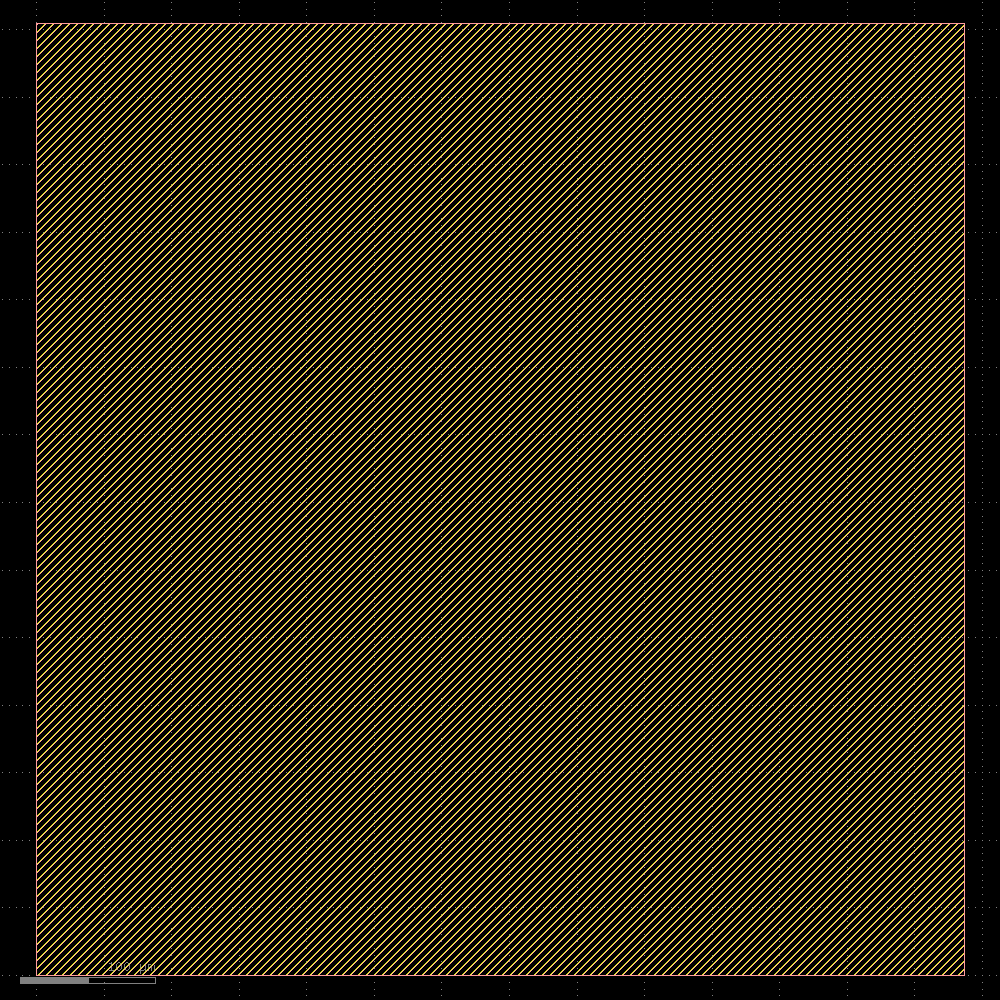

In [ ]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [ ]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[15:08:12] VERBOSE  Running 'OpenROAD.TapEndcapInsertion'…                                             ]8;id=932605;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=90977;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:08:12] VERBOSE  Logging subprocess to                                                              ]8;id=255958;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=183413;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=509577;file:///content/openlane_run/37-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\openlane_run/]8;;\]8;id=511774;file:///content/openlane_run/37-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\37]8;;\]8;id=509577;file:///content/openlane_run/37-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log]8;;\…                   

Reading OpenROAD database at '/content/openlane_run/36-openroad-floorplan/qft3_top_pipelined_with_serial.odb'…

Reading library file at                                                                                            
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__tt_025C_5v00.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] No information on clock propagation in input SDC file-- propagating all clocks.

[INFO TAP-0004] Inserted 342 endcaps.

[INFO TAP-0005] Inserted 2943 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to                                                                                       
'/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.odb'…

Writing netlist to '/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.nl.v'…

Writing powered netlist to                                                                                         
'/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.pnl.v'…

Writing layout to '/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.def'…

Writing timing constraints to                                                                                      
'/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.sdc'…

{'nl': Path('/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9323, 'design__instance__area': 241125, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64, 'design__die__bbox': '0.0 0.0 686.795 704.715', 'design__core__bbox': '6.72 15.68 679.84 686.0', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 6, 'design__die__area': 483995, 'design__core__area': 451206, 'design__instance__count__stdcell': 9323, 'design__instance__area__stdcell': 241125, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.534402'), 'design__instance__utilization__stdcell': Decimal('0.534402')}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[15:08:15] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=343138;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=692697;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:08:15] VERBOSE  Logging subprocess to ]8;id=642078;file:///tmp/openlane_klayout_tmp_q2o7jxlk/klayout-render.log\..]8;;\]8;id=411502;file:///tmp/openlane_klayout_tmp_q2o7jxlk/klayout-render.log\/tmp/openlane_klayout_tmp_q2o7jxlk/]8;;\]8;id=740634;file:///tmp/openlane_klayout_tmp_q2o7jxlk/klayout-render.log\klayout-render.log]8;;\…     ]8;id=844815;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=126197;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2.73s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
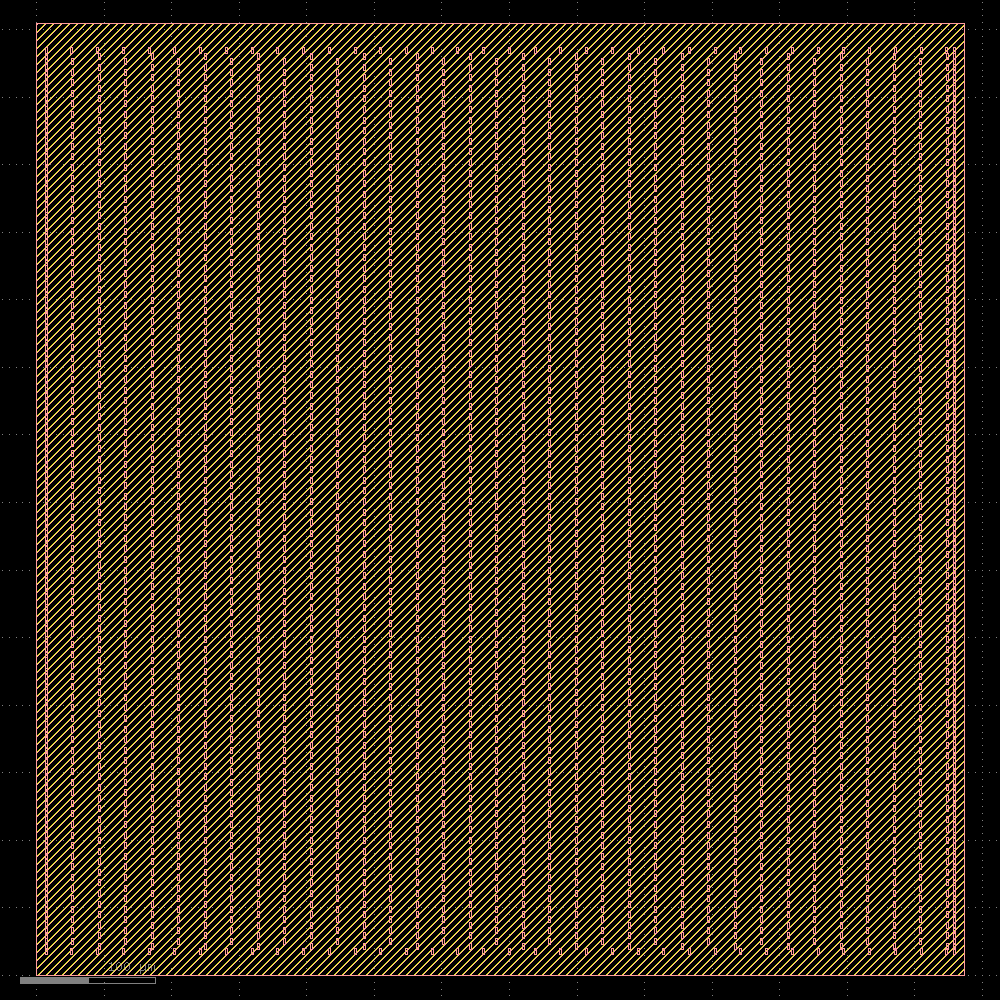

In [ ]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [ ]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[15:08:16] VERBOSE  Running 'OpenROAD.IOPlacement'…                                                    ]8;id=628906;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=779350;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:08:16] VERBOSE  Logging subprocess to                                                              ]8;id=469745;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=99096;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=518250;file:///content/openlane_run/38-openroad-ioplacement/openroad-ioplacement.log\openlane_run/]8;;\]8;id=867272;file:///content/openlane_run/38-openroad-ioplacement/openroad-ioplacement.log\38]8;;\]8;id=518250;file:///content/openlane_run/38-openroad-ioplacement/openroad-ioplacement.log\-openroad-ioplacement/openroad-ioplacement.log]8;;\…                                 

Reading OpenROAD database at                                                                                       
'/content/openlane_run/37-openroad-tapendcapinsertion/qft3_top_pipelined_with_serial.odb'…

Reading library file at                                                                                            
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__tt_025C_5v00.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] No information on clock propagation in input SDC file-- propagating all clocks.

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           830

[INFO PPL-0002] Number of I/O             6

[INFO PPL-0003] Number of I/O w/sink      6

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 2090.62 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.odb'…

Writing netlist to '/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.nl.v'…

Writing powered netlist to '/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.pnl.v'…

Writing layout to '/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.def'…

Writing timing constraints to '/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.sdc'…

{'nl': Path('/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9323, 'design__instance__area': 241125, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64, 'design__die__bbox': '0.0 0.0 686.795 704.715', 'design__core__bbox': '6.72 15.68 679.84 686.0', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 6, 'design__die__area': 483995, 'design__core__area': 451206, 'design__instance__count__stdcell': 9323, 'design__instance__area__stdcell': 241125, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.534402'), 'design__instance__utilization__stdcell': Decimal('0.534402'), 'floorplan__design__io': 6, 'design__io__hpwl': 4181250}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[15:08:19] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=686295;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=28623;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:08:19] VERBOSE  Logging subprocess to ]8;id=946954;file:///tmp/openlane_klayout_tmp_2hfipbtl/klayout-render.log\..]8;;\]8;id=814097;file:///tmp/openlane_klayout_tmp_2hfipbtl/klayout-render.log\/tmp/openlane_klayout_tmp_2hfipbtl/]8;;\]8;id=389497;file:///tmp/openlane_klayout_tmp_2hfipbtl/klayout-render.log\klayout-render.log]8;;\…     ]8;id=222351;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=440423;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2.54s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
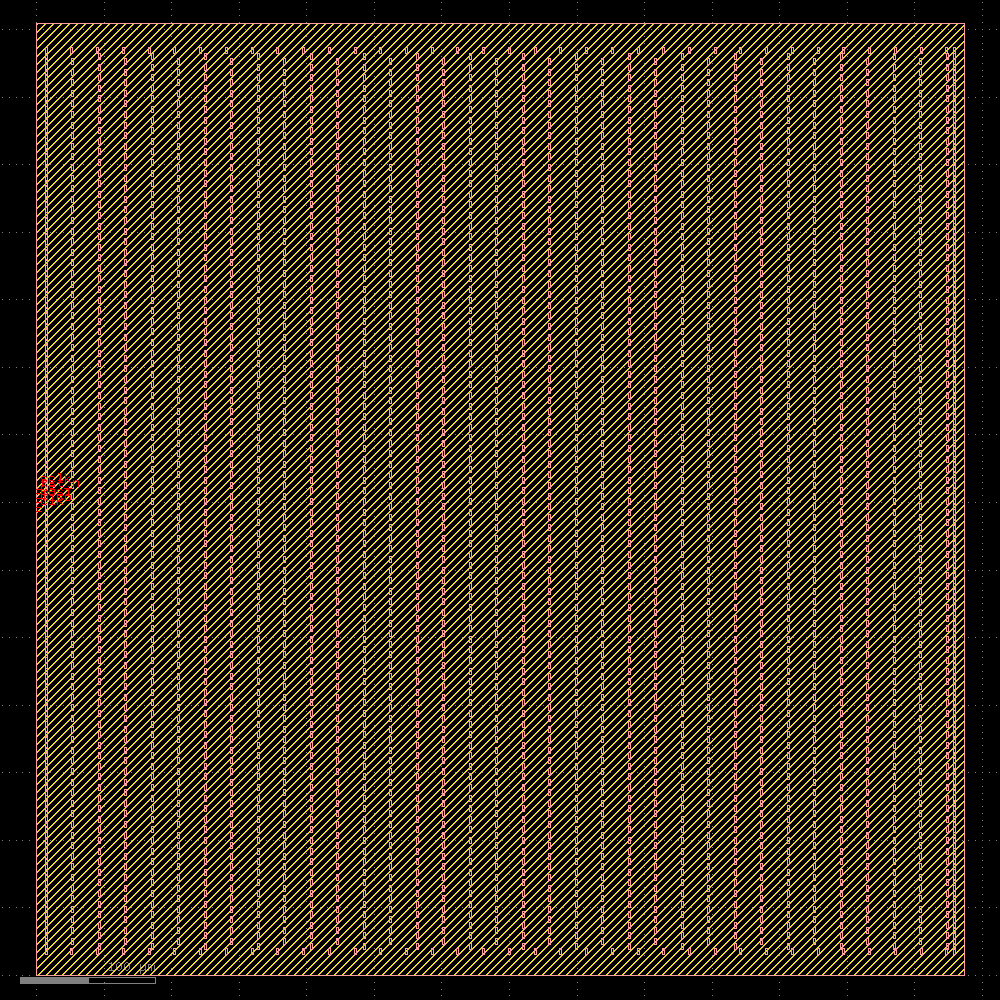

In [ ]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://openlane2.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [ ]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

[15:08:20] VERBOSE  Running 'OpenROAD.GeneratePDN'…                                                    ]8;id=296921;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=55858;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:08:20] INFO     'FP_PDN_CFG' not explicitly set, setting it to                                 ]8;id=213727;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=653237;file:///content/openlane_ipynb/openlane/steps/openroad.py#1174\1174]8;;\
                    /content/openlane_ipynb/openlane/scripts/openroad/common/pdn_cfg.tcl…                          

[15:08:20] VERBOSE  Logging subprocess to                                                              ]8;id=85662;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=869450;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=347626;file:///content/openlane_run/39-openroad-generatepdn/openroad-generatepdn.log\openlane_run/]8;;\]8;id=376118;file:///content/openlane_run/39-openroad-generatepdn/openroad-generatepdn.log\39]8;;\]8;id=347626;file:///content/openlane_run/39-openroad-generatepdn/openroad-generatepdn.log\-openroad-generatepdn/openroad-generatepdn.log]8;;\…                                 

Reading OpenROAD database at '/content/openlane_run/38-openroad-ioplacement/qft3_top_pipelined_with_serial.odb'…

Reading library file at                                                                                            
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__tt_025C_5v00.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] No information on clock propagation in input SDC file-- propagating all clocks.

[INFO] Setting global connections...

[INFO PDN-0001] Inserting grid: stdcell_grid

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.odb'…

Writing netlist to '/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.nl.v'…

Writing powered netlist to '/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.pnl.v'…

Writing layout to '/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.def'…

Writing timing constraints to '/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.sdc'…

[INFO PSM-0040] All shapes on net VDD are connected.

[INFO PSM-0040] All shapes on net VSS are connected.

{'nl': Path('/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9323, 'design__instance__area': 241125, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64, 'design__die__bbox': '0.0 0.0 686.795 704.715', 'design__core__bbox': '6.72 15.68 679.84 686.0', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 8, 'design__die__area': 483995, 'design__core__area': 451206, 'design__instance__count__stdcell': 9323, 'design__instance__area__stdcell': 241125, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.534402'), 'design__instance__utilization__stdcell': Decimal('0.534402'), 'floorplan__design__io': 6, 'design__io__hpwl': 4181250, 'design__power_grid_violation__count__net:VDD': 0, 'design__power_grid_violation__count__net:VSS': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[15:08:24] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=503267;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=628829;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:08:24] VERBOSE  Logging subprocess to ]8;id=149089;file:///tmp/openlane_klayout_tmp_lnydvv7t/klayout-render.log\..]8;;\]8;id=469670;file:///tmp/openlane_klayout_tmp_lnydvv7t/klayout-render.log\/tmp/openlane_klayout_tmp_lnydvv7t/]8;;\]8;id=898987;file:///tmp/openlane_klayout_tmp_lnydvv7t/klayout-render.log\klayout-render.log]8;;\…     ]8;id=614063;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=486974;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.95s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
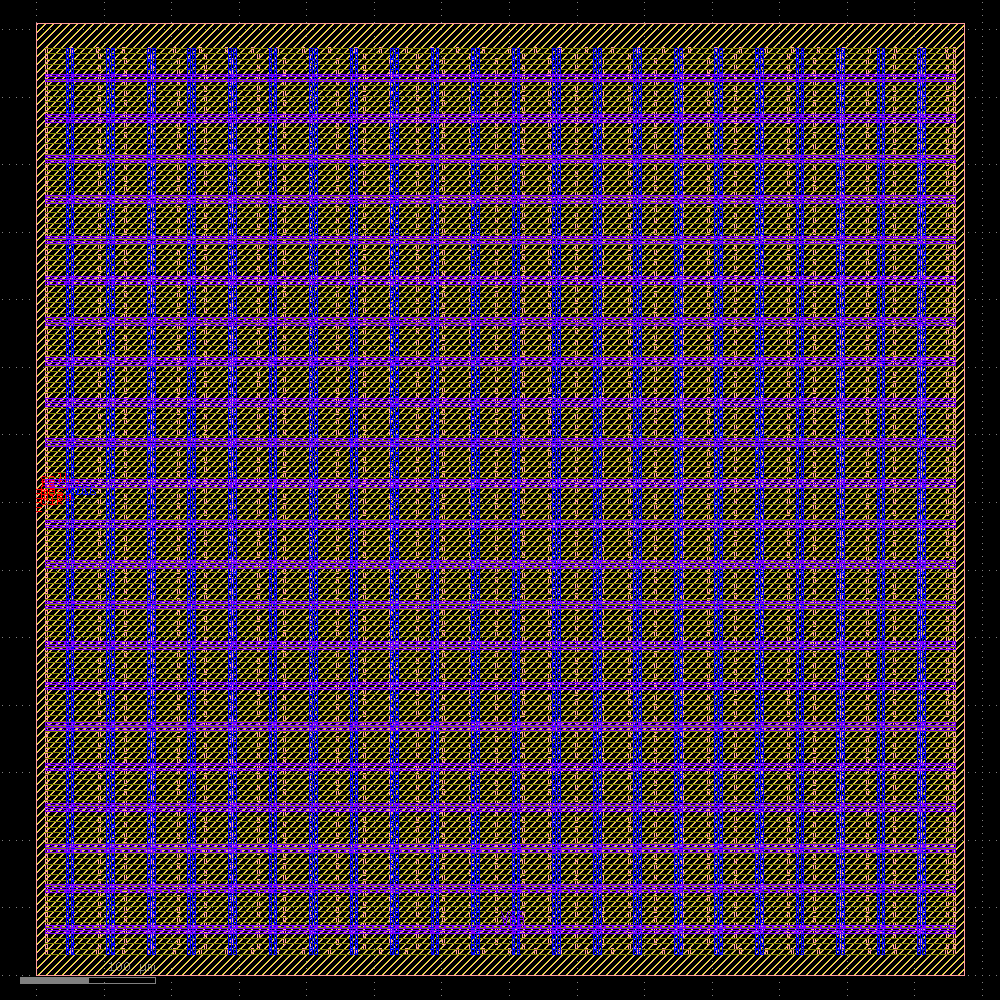

In [ ]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [ ]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[15:08:25] VERBOSE  Running 'OpenROAD.GlobalPlacement'…                                                ]8;id=967354;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=796627;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:08:25] INFO     'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated       ]8;id=976872;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=823332;file:///content/openlane_ipynb/openlane/steps/openroad.py#1260\1260]8;;\
                    target density: 63.440200…                                                                     

[15:08:25] VERBOSE  Logging subprocess to                                                              ]8;id=198845;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=105238;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=166351;file:///content/openlane_run/40-openroad-globalplacement/openroad-globalplacement.log\openlane_run/]8;;\]8;id=169066;file:///content/openlane_run/40-openroad-globalplacement/openroad-globalplacement.log\40]8;;\]8;id=166351;file:///content/openlane_run/40-openroad-globalplacement/openroad-globalplacement.log\-openroad-globalplacement/openroad-globalplacement.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/39-openroad-generatepdn/qft3_top_pipelined_with_serial.odb'…

Reading library file at                                                                                            
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__tt_025C_5v00.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] No information on clock propagation in input SDC file-- propagating all clocks.

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: Metal2 and clock min routing layer to Metal2.

[INFO] Setting signal max routing layer to: Metal5 and clock max routing layer to Metal5.

[INFO GPL-0002] DBU: 2000

[INFO GPL-0003] SiteSize: (  0.560  3.920 ) um

[INFO GPL-0004] CoreBBox: (  6.720 15.680 ) ( 679.840 686.000 ) um

[INFO GPL-0006] NumInstances:              8981

[INFO GPL-0007] NumPlaceInstances:         6038

[INFO GPL-0008] NumFixedInstances:         2943

[INFO GPL-0009] NumDummyInstances:            0

[INFO GPL-0010] NumNets:                   6043

[INFO GPL-0011] NumPins:                  21790

[INFO GPL-0012] DieBBox:  (  0.000  0.000 ) ( 686.795 704.715 ) um

[INFO GPL-0013] CoreBBox: (  6.720 15.680 ) ( 679.840 686.000 ) um

[INFO GPL-0016] CoreArea:            451205.798 um^2

[INFO GPL-0017] NonPlaceInstsArea:    12920.947 um^2

[INFO GPL-0018] PlaceInstsArea:      226702.694 um^2

[INFO GPL-0019] Util:                    51.725 %

[INFO GPL-0020] StdInstsArea:        226702.694 um^2

[INFO GPL-0021] MacroInstsArea:           0.000 um^2

[InitialPlace]  Iter: 1 CG residual: 0.00162766 HPWL: 199787840

[InitialPlace]  Iter: 2 CG residual: 0.00274143 HPWL: 210946721

[InitialPlace]  Iter: 3 CG residual: 0.00174147 HPWL: 227788560

[InitialPlace]  Iter: 4 CG residual: 0.00063910 HPWL: 249312495

[InitialPlace]  Iter: 5 CG residual: 0.00031478 HPWL: 257680956

[InitialPlace]  Iter: 6 CG residual: 0.00011386 HPWL: 259247353

[InitialPlace]  Iter: 7 CG residual: 0.00011311 HPWL: 259018282

[InitialPlace]  Iter: 8 CG residual: 0.00011840 HPWL: 259074287

[InitialPlace]  Iter: 9 CG residual: 0.00011773 HPWL: 259035079

[InitialPlace]  Iter: 10 CG residual: 0.00012868 HPWL: 259090396

[InitialPlace]  Iter: 11 CG residual: 0.00015933 HPWL: 259064954

[InitialPlace]  Iter: 12 CG residual: 0.00013028 HPWL: 259145252

[InitialPlace]  Iter: 13 CG residual: 0.00012388 HPWL: 259061105

[InitialPlace]  Iter: 14 CG residual: 0.00019240 HPWL: 259164660

[InitialPlace]  Iter: 15 CG residual: 0.00013270 HPWL: 259140971

[InitialPlace]  Iter: 16 CG residual: 0.00015011 HPWL: 259107478

[InitialPlace]  Iter: 17 CG residual: 0.00019998 HPWL: 259097851

[InitialPlace]  Iter: 18 CG residual: 0.00014230 HPWL: 259009879

[InitialPlace]  Iter: 19 CG residual: 0.00014107 HPWL: 259027449

[InitialPlace]  Iter: 20 CG residual: 0.00013275 HPWL: 259029307

[INFO GPL-0031] FillerInit:NumGCells:      7422

[INFO GPL-0032] FillerInit:NumGNets:       6043

[INFO GPL-0033] FillerInit:NumGPins:      21790

[INFO GPL-0023] TargetDensity:            0.634

[INFO GPL-0024] AvrgPlaceInstArea:       37.546 um^2

[INFO GPL-0025] IdealBinArea:            59.183 um^2

[INFO GPL-0026] IdealBinCnt:               7623

[INFO GPL-0027] TotalBinArea:        451205.798 um^2

[INFO GPL-0028] BinCnt:        64     64

[INFO GPL-0029] BinSize: ( 10.518 10.474 )

[INFO GPL-0030] NumBins: 4096

[NesterovSolve] Iter:    1 overflow: 0.980 HPWL: 37670598

[NesterovSolve] Iter:   10 overflow: 0.981 HPWL: 47476489

[NesterovSolve] Iter:   20 overflow: 0.982 HPWL: 48629221

[NesterovSolve] Iter:   30 overflow: 0.983 HPWL: 51857159

[NesterovSolve] Iter:   40 overflow: 0.985 HPWL: 54785572

[NesterovSolve] Iter:   50 overflow: 0.986 HPWL: 57700891

[NesterovSolve] Iter:   60 overflow: 0.987 HPWL: 60753309

[NesterovSolve] Iter:   70 overflow: 0.987 HPWL: 63521403

[NesterovSolve] Iter:   80 overflow: 0.988 HPWL: 65668599

[NesterovSolve] Iter:   90 overflow: 0.988 HPWL: 67015788

[NesterovSolve] Iter:  100 overflow: 0.988 HPWL: 67467708

[NesterovSolve] Iter:  110 overflow: 0.988 HPWL: 66922338

[NesterovSolve] Iter:  120 overflow: 0.988 HPWL: 65276328

[NesterovSolve] Iter:  130 overflow: 0.986 HPWL: 62635623

[NesterovSolve] Iter:  140 overflow: 0.976 HPWL: 59926443

[NesterovSolve] Iter:  150 overflow: 0.955 HPWL: 60591035

[NesterovSolve] Iter:  160 overflow: 0.915 HPWL: 68316273

[NesterovSolve] Iter:  170 overflow: 0.866 HPWL: 82465643

[NesterovSolve] Iter:  180 overflow: 0.818 HPWL: 97281814

[INFO GPL-0100] worst slack 1.25e-06

[INFO GPL-0103] Weighted 603 nets.

[NesterovSolve] Iter:  190 overflow: 0.780 HPWL: 108843955

[NesterovSolve] Iter:  200 overflow: 0.750 HPWL: 119764388

[NesterovSolve] Iter:  210 overflow: 0.726 HPWL: 130219467

[NesterovSolve] Iter:  220 overflow: 0.700 HPWL: 142637992

[NesterovSolve] Iter:  230 overflow: 0.654 HPWL: 160393616

[INFO GPL-0100] worst slack 1.24e-06

[INFO GPL-0103] Weighted 602 nets.

[NesterovSolve] Iter:  240 overflow: 0.601 HPWL: 177559376

[NesterovSolve] Snapshot saved at iter = 240

[NesterovSolve] Iter:  250 overflow: 0.555 HPWL: 190515928

[NesterovSolve] Iter:  260 overflow: 0.519 HPWL: 198009414

[NesterovSolve] Iter:  270 overflow: 0.493 HPWL: 202920796

[INFO GPL-0100] worst slack 1.24e-06

[INFO GPL-0103] Weighted 604 nets.

[NesterovSolve] Iter:  280 overflow: 0.461 HPWL: 206401476

[NesterovSolve] Iter:  290 overflow: 0.420 HPWL: 207632810

[NesterovSolve] Iter:  300 overflow: 0.377 HPWL: 211364642

[NesterovSolve] Iter:  310 overflow: 0.340 HPWL: 213795935

[NesterovSolve] Iter:  320 overflow: 0.307 HPWL: 212042719

[INFO GPL-0100] worst slack 1.25e-06

[INFO GPL-0103] Weighted 604 nets.

[NesterovSolve] Iter:  330 overflow: 0.282 HPWL: 213510724

[NesterovSolve] Iter:  340 overflow: 0.253 HPWL: 214809886

[NesterovSolve] Iter:  350 overflow: 0.227 HPWL: 215372977

[INFO GPL-0100] worst slack 1.25e-06

[INFO GPL-0103] Weighted 604 nets.

[NesterovSolve] Iter:  360 overflow: 0.202 HPWL: 216518572

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 16800 16800 ) DBU

[INFO GPL-0038] TileCnt:      81   83

[INFO GPL-0039] numRoutingLayers: 5

[INFO GPL-0040] NumTiles: 6723

[INFO GPL-0063] TotalRouteOverflowH2: 0.14285707473754883

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 2

[INFO GPL-0066] 0.5%RC: 1.0022

[INFO GPL-0067] 1.0%RC: 0.9894

[INFO GPL-0068] 2.0%RC: 0.9148

[INFO GPL-0069] 5.0%RC: 0.8174

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 0.9958

[INFO GPL-0077] FinalRC lower than targetRC(1), routability not needed.

[NesterovSolve] Iter:  370 overflow: 0.176 HPWL: 217765383

[NesterovSolve] Iter:  380 overflow: 0.155 HPWL: 219105683

[INFO GPL-0100] worst slack 1.25e-06

[INFO GPL-0103] Weighted 604 nets.

[NesterovSolve] Iter:  390 overflow: 0.132 HPWL: 220510252

[NesterovSolve] Iter:  400 overflow: 0.114 HPWL: 222084078

[NesterovSolve] Finished with Overflow: 0.099855

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to                                                                                       
'/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.odb'…

Writing netlist to '/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.nl.v'…

Writing powered netlist to                                                                                         
'/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.pnl.v'…

Writing layout to '/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.def'…

Writing timing constraints to                                                                                      
'/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.sdc'…

{'nl': Path('/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9323, 'design__instance__area': 241125, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64, 'design__die__bbox': '0.0 0.0 686.795 704.715', 'design__core__bbox': '6.72 15.68 679.84 686.0', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 8, 'design__die__area': 483995, 'design__core__area': 451206, 'design__instance__count__stdcell': 9323, 'design__instance__area__stdcell': 241125, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.534402'), 'design__instance__utilization__stdcell': Decimal('0.534402'), 'floorplan__design__io': 6, 'design__io__hpwl': 4181250, 'design__power_grid_violation__count__net:VDD': 0, 'design__power_grid_violation__count__net:VSS': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[15:09:00] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=954954;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=814390;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:09:00] VERBOSE  Logging subprocess to ]8;id=575457;file:///tmp/openlane_klayout_tmp_zxc6bz6z/klayout-render.log\..]8;;\]8;id=1174;file:///tmp/openlane_klayout_tmp_zxc6bz6z/klayout-render.log\/tmp/openlane_klayout_tmp_zxc6bz6z/]8;;\]8;id=594962;file:///tmp/openlane_klayout_tmp_zxc6bz6z/klayout-render.log\klayout-render.log]8;;\…     ]8;id=243549;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=25220;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 34.87s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
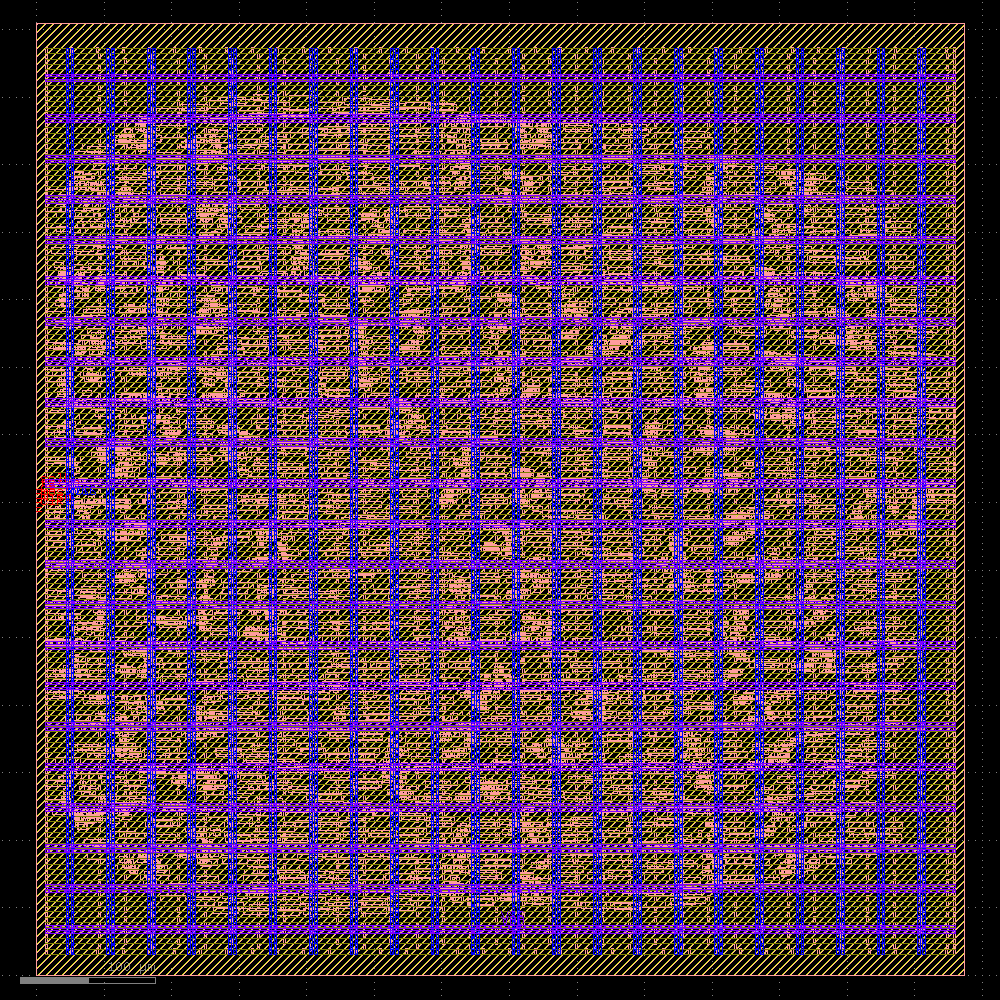

In [ ]:
display(gpl)

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [ ]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

[15:09:02] VERBOSE  Running 'OpenROAD.DetailedPlacement'…                                              ]8;id=59214;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=555684;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:09:02] VERBOSE  Logging subprocess to                                                              ]8;id=186421;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=831240;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=950618;file:///content/openlane_run/41-openroad-detailedplacement/openroad-detailedplacement.log\openlane_run/]8;;\]8;id=631727;file:///content/openlane_run/41-openroad-detailedplacement/openroad-detailedplacement.log\41]8;;\]8;id=950618;file:///content/openlane_run/41-openroad-detailedplacement/openroad-detailedplacement.log\-openroad-detailedplacement/openroad-detailedplacement.log]8;;\…                     

Reading OpenROAD database at                                                                                       
'/content/openlane_run/40-openroad-globalplacement/qft3_top_pipelined_with_serial.odb'…

Reading library file at                                                                                            
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__tt_025C_5v00.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] No information on clock propagation in input SDC file-- propagating all clocks.

Placement Analysis

---------------------------------

total displacement      31465.0 u

average displacement        3.4 u

max displacement           21.1 u

original HPWL          111522.9 u

legalized HPWL         142490.9 u

delta HPWL                   28 %

[INFO DPL-0020] Mirrored 1143 instances

[INFO DPL-0021] HPWL before          142490.9 u

[INFO DPL-0022] HPWL after           140804.8 u

[INFO DPL-0023] HPWL delta               -1.2 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to                                                                                       
'/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.odb'…

Writing netlist to '/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.nl.v'…

Writing powered netlist to                                                                                         
'/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.pnl.v'…

Writing layout to '/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.def'…

Writing timing constraints to                                                                                      
'/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.sdc'…

{'nl': Path('/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9323, 'design__instance__area': 241125, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64, 'design__die__bbox': '0.0 0.0 686.795 704.715', 'design__core__bbox': '6.72 15.68 679.84 686.0', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 8, 'design__die__area': 483995, 'design__core__area': 451206, 'design__instance__count__stdcell': 9323, 'design__instance__area__stdcell': 241125, 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.534402'), 'design__instance__utilization__stdcell': Decimal('0.534402'), 'floorplan__design__io': 6, 'design__io__hpwl': 4181250, 'design__power_grid_violation__count__net:VDD': 0, 'design__power_grid_violation__count__net:VSS': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': 31465, 'design__instance__displacement__mean': Decimal('3.3745'), 'design__instance__displacement__max': Decimal('21.089'), 'route__wirelength__estimated': 142491, 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[15:09:05] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=331150;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=430137;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:09:05] VERBOSE  Logging subprocess to ]8;id=947957;file:///tmp/openlane_klayout_tmp_8sphiher/klayout-render.log\..]8;;\]8;id=241085;file:///tmp/openlane_klayout_tmp_8sphiher/klayout-render.log\/tmp/openlane_klayout_tmp_8sphiher/]8;;\]8;id=910759;file:///tmp/openlane_klayout_tmp_8sphiher/klayout-render.log\klayout-render.log]8;;\…     ]8;id=54226;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=80601;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.35s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
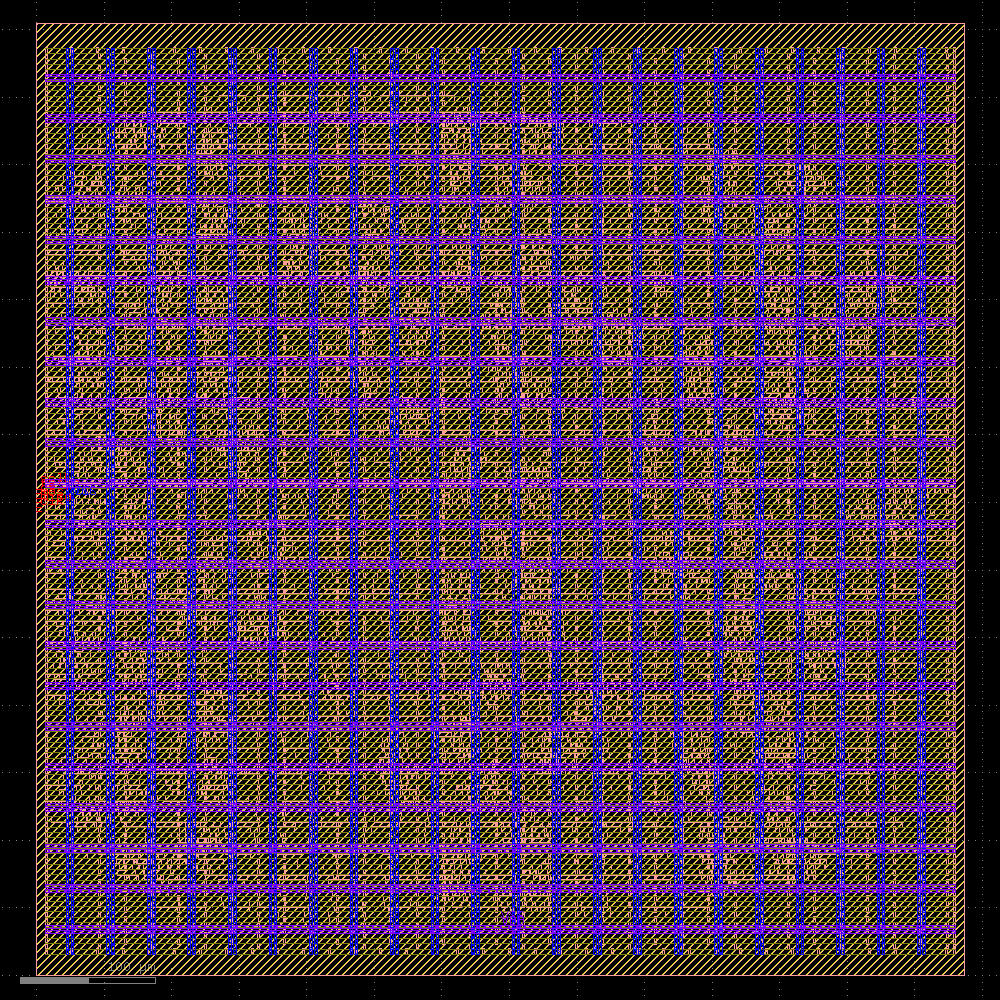

In [ ]:
display(dpl)

### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [ ]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

[15:16:28] VERBOSE  Running 'OpenROAD.CTS'…                                                            ]8;id=732811;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=17813;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:16:28] VERBOSE  Logging subprocess to ]8;id=873421;file:///content/openlane_run/43-openroad-cts/openroad-cts.log\openlane_run/]8;;\]8;id=113235;file:///content/openlane_run/43-openroad-cts/openroad-cts.log\43]8;;\]8;id=873421;file:///content/openlane_run/43-openroad-cts/openroad-cts.log\-openroad-cts/openroad-cts.log]8;;\…               ]8;id=167465;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=739304;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading timing models for corner nom_ff_n40C_5v50…

Reading timing library for the 'nom_ff_n40C_5v50' corner at                                                        
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__ff_n40C_5v50.lib'…

Reading timing models for corner nom_tt_025C_5v00…

Reading timing library for the 'nom_tt_025C_5v00' corner at                                                        
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__tt_025C_5v00.lib'…

Reading timing models for corner nom_ss_125C_4v50…

Reading timing library for the 'nom_ss_125C_4v50' corner at                                                        
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lib/gf180mcu_fd_sc_mcu7t5v0__ss_125C_4v50.lib'…

Reading OpenROAD database at                                                                                       
'/content/openlane_run/41-openroad-detailedplacement/qft3_top_pipelined_with_serial.odb'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] No information on clock propagation in input SDC file-- propagating all clocks.

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0050] Root buffer is gf180mcu_fd_sc_mcu7t5v0__clkbuf_16.

[INFO CTS-0051] Sink buffer is gf180mcu_fd_sc_mcu7t5v0__clkbuf_8.

[INFO CTS-0052] The following clock buffers will be used for CTS:

gf180mcu_fd_sc_mcu7t5v0__clkbuf_2

gf180mcu_fd_sc_mcu7t5v0__clkbuf_4

gf180mcu_fd_sc_mcu7t5v0__clkbuf_8

[INFO CTS-0049] Characterization buffer is gf180mcu_fd_sc_mcu7t5v0__clkbuf_8.

[15:16:47] ERROR    [CTS-0065] Normalized values in the LUT should be in the range [1, 1023         ]8;id=557535;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=80158;file:///content/openlane_ipynb/openlane/steps/openroad.py#233\233]8;;\

Check the table above to see the normalization ranges and your     characterization configuration.

Error: cts.tcl, 58 CTS-0065

StepError: OpenROAD.CTS failed with the following errors:
[CTS-0065] Normalized values in the LUT should be in the range [1, 1023

In [ ]:
display(cts)

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [ ]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [ ]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

In [ ]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [ ]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

In [ ]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [ ]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of OpenLane right now are not super
reliable for timing purposes and are only provided for completeness.
When using OpenLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [ ]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

──────────────────────────────────────── Static Timing Analysis (Post-PnR) ────────────────────────────────────────

[15:16:49] VERBOSE  Running 'OpenROAD.STAPostPNR'…                                                     ]8;id=894701;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=331763;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:16:49] INFO     Starting STA for the nom_tt_025C_5v00 timing corner…                            ]8;id=806522;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=590052;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[15:16:49] INFO     Starting STA for the nom_ss_125C_4v50 timing corner…                            ]8;id=572947;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=352930;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[15:16:49] VERBOSE  Logging subprocess to                                                              ]8;id=760933;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=704703;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=712949;file:///content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/sta.log\openlane_run/]8;;\]8;id=871774;file:///content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/sta.log\44]8;;\]8;id=712949;file:///content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/sta.log\-openroad-stapostpnr/nom_tt_025C_5v00/sta.log]8;;\…                                  

[15:16:49] VERBOSE  Logging subprocess to                                                              ]8;id=695826;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=679459;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=293833;file:///content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/sta.log\openlane_run/]8;;\]8;id=852004;file:///content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/sta.log\44]8;;\]8;id=293833;file:///content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/sta.log\-openroad-stapostpnr/nom_ss_125C_4v50/sta.log]8;;\…                                  

[15:17:03] INFO     Finished STA for the nom_ss_125C_4v50 timing corner.                            ]8;id=49656;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=118790;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[15:17:03] VERBOSE  Logging subprocess to                                                              ]8;id=153501;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=392669;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=97301;file:///content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/filter_unannotated.log\openlane_run/]8;;\]8;id=936886;file:///content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/filter_unannotated.log\44]8;;\]8;id=97301;file:///content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/filter_unannotated.log\-openroad-stapostpnr/nom_ss_125C_4v50/filter_unannotated.log]8;;\…                   

[15:17:03] INFO     Finished STA for the nom_tt_025C_5v00 timing corner.                            ]8;id=470267;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=547065;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[15:17:03] VERBOSE  Logging subprocess to                                                              ]8;id=941025;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=574713;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=633769;file:///content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/filter_unannotated.log\openlane_run/]8;;\]8;id=380678;file:///content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/filter_unannotated.log\44]8;;\]8;id=633769;file:///content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/filter_unannotated.log\-openroad-stapostpnr/nom_tt_025C_5v00/filter_unannotated.log]8;;\…                   

[15:17:04] INFO     Starting STA for the nom_ff_n40C_5v50 timing corner…                            ]8;id=7932;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=417460;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[15:17:04] VERBOSE  Logging subprocess to                                                              ]8;id=579089;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=101454;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=280287;file:///content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/sta.log\openlane_run/]8;;\]8;id=482630;file:///content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/sta.log\44]8;;\]8;id=280287;file:///content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/sta.log\-openroad-stapostpnr/nom_ff_n40C_5v50/sta.log]8;;\…                                  

[15:17:05] INFO     Starting STA for the min_tt_025C_5v00 timing corner…                            ]8;id=605318;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=65636;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[15:17:05] VERBOSE  Logging subprocess to                                                              ]8;id=600585;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=569166;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=918521;file:///content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/sta.log\openlane_run/]8;;\]8;id=465984;file:///content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/sta.log\44]8;;\]8;id=918521;file:///content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/sta.log\-openroad-stapostpnr/min_tt_025C_5v00/sta.log]8;;\…                                  

[15:17:20] INFO     Finished STA for the min_tt_025C_5v00 timing corner.                            ]8;id=827330;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=270126;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[15:17:20] INFO     Finished STA for the nom_ff_n40C_5v50 timing corner.                            ]8;id=474279;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=779515;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[15:17:20] VERBOSE  Logging subprocess to                                                              ]8;id=364647;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=378994;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=882781;file:///content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/filter_unannotated.log\openlane_run/]8;;\]8;id=106685;file:///content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/filter_unannotated.log\44]8;;\]8;id=882781;file:///content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/filter_unannotated.log\-openroad-stapostpnr/nom_ff_n40C_5v50/filter_unannotated.log]8;;\…                   

[15:17:20] VERBOSE  Logging subprocess to                                                              ]8;id=324598;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=6069;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=60268;file:///content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/filter_unannotated.log\openlane_run/]8;;\]8;id=352804;file:///content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/filter_unannotated.log\44]8;;\]8;id=60268;file:///content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/filter_unannotated.log\-openroad-stapostpnr/min_tt_025C_5v00/filter_unannotated.log]8;;\…                   

[15:17:22] INFO     Starting STA for the min_ss_125C_4v50 timing corner…                            ]8;id=337394;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=652548;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[15:17:22] VERBOSE  Logging subprocess to                                                              ]8;id=258533;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=157144;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=524594;file:///content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/sta.log\openlane_run/]8;;\]8;id=310281;file:///content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/sta.log\44]8;;\]8;id=524594;file:///content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/sta.log\-openroad-stapostpnr/min_ss_125C_4v50/sta.log]8;;\…                                  

[15:17:22] INFO     Starting STA for the min_ff_n40C_5v50 timing corner…                            ]8;id=714340;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=419110;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[15:17:22] VERBOSE  Logging subprocess to                                                              ]8;id=453381;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=270143;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=118243;file:///content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/sta.log\openlane_run/]8;;\]8;id=805221;file:///content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/sta.log\44]8;;\]8;id=118243;file:///content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/sta.log\-openroad-stapostpnr/min_ff_n40C_5v50/sta.log]8;;\…                                  

[15:17:35] INFO     Finished STA for the min_ss_125C_4v50 timing corner.                            ]8;id=536085;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=512095;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[15:17:35] VERBOSE  Logging subprocess to                                                              ]8;id=637918;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=30071;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=957670;file:///content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/filter_unannotated.log\openlane_run/]8;;\]8;id=86909;file:///content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/filter_unannotated.log\44]8;;\]8;id=957670;file:///content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/filter_unannotated.log\-openroad-stapostpnr/min_ss_125C_4v50/filter_unannotated.log]8;;\…                   

[15:17:37] INFO     Starting STA for the max_tt_025C_5v00 timing corner…                            ]8;id=431894;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=234023;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[15:17:37] VERBOSE  Logging subprocess to                                                              ]8;id=837074;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=301763;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=228140;file:///content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/sta.log\openlane_run/]8;;\]8;id=929740;file:///content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/sta.log\44]8;;\]8;id=228140;file:///content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/sta.log\-openroad-stapostpnr/max_tt_025C_5v00/sta.log]8;;\…                                  

[15:17:37] INFO     Finished STA for the min_ff_n40C_5v50 timing corner.                            ]8;id=362089;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=239294;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[15:17:38] VERBOSE  Logging subprocess to                                                              ]8;id=116195;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=247030;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=881507;file:///content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/filter_unannotated.log\openlane_run/]8;;\]8;id=106639;file:///content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/filter_unannotated.log\44]8;;\]8;id=881507;file:///content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/filter_unannotated.log\-openroad-stapostpnr/min_ff_n40C_5v50/filter_unannotated.log]8;;\…                   

[15:17:39] INFO     Starting STA for the max_ss_125C_4v50 timing corner…                            ]8;id=712286;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=198366;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[15:17:39] VERBOSE  Logging subprocess to                                                              ]8;id=929546;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=339305;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=586689;file:///content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/sta.log\openlane_run/]8;;\]8;id=502917;file:///content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/sta.log\44]8;;\]8;id=586689;file:///content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/sta.log\-openroad-stapostpnr/max_ss_125C_4v50/sta.log]8;;\…                                  

[15:17:53] INFO     Finished STA for the max_tt_025C_5v00 timing corner.                            ]8;id=845839;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=489308;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[15:17:53] VERBOSE  Logging subprocess to                                                              ]8;id=917181;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=73619;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=175657;file:///content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/filter_unannotated.log\openlane_run/]8;;\]8;id=737045;file:///content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/filter_unannotated.log\44]8;;\]8;id=175657;file:///content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/filter_unannotated.log\-openroad-stapostpnr/max_tt_025C_5v00/filter_unannotated.log]8;;\…                   

[15:17:53] INFO     Finished STA for the max_ss_125C_4v50 timing corner.                            ]8;id=329639;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=859332;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[15:17:53] VERBOSE  Logging subprocess to                                                              ]8;id=876468;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=460414;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=27631;file:///content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/filter_unannotated.log\openlane_run/]8;;\]8;id=141348;file:///content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/filter_unannotated.log\44]8;;\]8;id=27631;file:///content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/filter_unannotated.log\-openroad-stapostpnr/max_ss_125C_4v50/filter_unannotated.log]8;;\…                   

[15:17:54] INFO     Starting STA for the max_ff_n40C_5v50 timing corner…                            ]8;id=650165;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=69019;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[15:17:54] VERBOSE  Logging subprocess to                                                              ]8;id=616120;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=804127;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=45033;file:///content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/sta.log\openlane_run/]8;;\]8;id=576968;file:///content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/sta.log\44]8;;\]8;id=45033;file:///content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/sta.log\-openroad-stapostpnr/max_ff_n40C_5v50/sta.log]8;;\…                                  

[15:18:01] INFO     Finished STA for the max_ff_n40C_5v50 timing corner.                            ]8;id=147882;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=236211;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[15:18:01] VERBOSE  Logging subprocess to                                                              ]8;id=166240;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=969083;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=450387;file:///content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/filter_unannotated.log\openlane_run/]8;;\]8;id=267257;file:///content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/filter_unannotated.log\44]8;;\]8;id=450387;file:///content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/filter_unannotated.log\-openroad-stapostpnr/max_ff_n40C_5v50/filter_unannotated.log]8;;\…                   

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.10… │ 0.10… │ 0.0… │ 0     │ 0    │ 1232… │ 123… │ 0.00… │ 0    │ 0     │ 3    │ 1984  │
│ nom_tt_025C_5v00     │ 0.27… │ 0.27… │ 0.0… │ 0     │ 0    │ 1240… │ 124… │ 0.00… │ 0    │ 0     │ 2    │ 1971  │
│ nom_ss_125C_4v50     │ 0.68… │ 0.68… │ 0.0… │ 0     │ 0    │ 1233… │ 123… │ 0.00… │ 0    │ 0     │ 3    │ 1829  │
│ nom_ff_n40C_5v50     │ 0.10… │ 0.10… │ 0.0… │ 0     │ 0    │ 1244… │ 124… │ 0.00… │ 0    │ 0     │ 1    │ 1981  │
│ min_tt_025C_5v00     │ 0.26… │ 0.26… │ 0.0… │ 0     │ 0    │ 1241… │ 124… │ 0.00… │ 0    │ 0     │ 2    │ 1906  │
│ min_ss_125C_4v50     │ 0.66… │ 0.66… │ 0.0… │ 0     │ 0    │ 1234… │ 123… │ 0.00… │ 0    │ 0     │ 2    │ 1465  │
│ min_ff_n40C_5v50     │ 0.10… │ 0.10… │ 0.0… │ 0     │ 0    │ 1244… │ 124… │ 0.00… │ 0    │ 0     │ 1    │ 1977  │
│ max_tt_025C_5v00     │ 0.29… │ 0.29… │ 0.0… │ 0     │ 0    │ 1240… │ 124… │ 0.00… │ 0    │ 0     │ 2    │ 1979  │
│ max_ss_125C_4v50     │ 0.70… │ 0.70… │ 0.0… │ 0     │ 0    │ 1232… │ 123… │ 0.00… │ 0    │ 0     │ 3    │ 1901  │
│ max_ff_n40C_5v50     │ 0.11… │ 0.11… │ 0.0… │ 0     │ 0    │ 1243… │ 124… │ 0.00… │ 0    │ 0     │ 1    │ 1984  │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.1012   │ 0.1012   │ 0.0000   │ 0        │ 0         │ 1232.31… │ 1232.3142 │ 0.0000   │ 0         │ 0        │ 3         │ 1984     │
│ nom_tt_025C_5v00     │ 0.2796   │ 0.2796   │ 0.0000   │ 0        │ 0         │ 1240.85… │ 1240.8522 │ 0.0000   │ 0         │ 0        │ 2         │ 1971     │
│ nom_ss_125C_4v50     │ 0.6850   │ 0.6850   │ 0.0000   │ 0        │ 0         │ 1233.52… │ 1233.5277 │ 0.0000   │ 0         │ 0        │ 3         │ 1829     │
│ nom_ff_n40C_5v50     │ 0.1083   │ 0.1083   │ 0.0000   │ 0        │ 0         │ 1244.13… │ 1244.1392 │ 0.0000   │ 0         │ 0        │ 1         │ 1981     │
│ min_tt_025C_5v00     │ 0.2692   │ 0.2692   │ 0.0000   │ 0        │ 0         │ 1241.43… │ 1241.4320 │ 0.0000   │ 0         │ 0        │ 2         │ 1906     │
│ min_ss_125C_4v50     │ 0.6664   │ 0.6664   │ 0.0000   │ 0        │ 0         │ 1234.54… │ 1234.5413 │ 0.0000   │ 0         │ 0        │ 2         │ 1465     │
│ min_ff_n40C_5v50     │ 0.1012   │ 0.1012   │ 0.0000   │ 0        │ 0         │ 1244.51… │ 1244.5161 │ 0.0000   │ 0         │ 0        │ 1         │ 1977     │
│ max_tt_025C_5v00     │ 0.2917   │ 0.2917   │ 0.0000   │ 0        │ 0         │ 1240.16… │ 1240.1602 │ 0.0000   │ 0         │ 0        │ 2         │ 1979     │
│ max_ss_125C_4v50     │ 0.7052   │ 0.7052   │ 0.0000   │ 0        │ 0         │ 1232.31… │ 1232.3142 │ 0.0000   │ 0         │ 0        │ 3         │ 1901     │
│ max_ff_n40C_5v50     │ 0.1170   │ 0.1170   │ 0.0000   │ 0        │ 0         │ 1243.68… │ 1243.6829 │ 0.0000   │ 0         │ 0        │ 1         │ 1984     │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.sdc'), 'sdf': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.sdf'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.sdf'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.sdf'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.sdf'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.sdf'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.sdf'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.sdf'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.sdf'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/qft3_top_pipelined_with_serial.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/qft3_top_pipelined_with_serial.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/qft3_top_pipelined_with_serial.max.spef')}, 'lib': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.lib'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.lib'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.lib'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.lib'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.lib'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.lib'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.lib'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.lib'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.lib')}, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9970, 'design__instance__area': 269492, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64, 'design__die__bbox': '0.0 0.0 686.795 704.715', 'design__core__bbox': '6.72 15.68 679.84 686.0', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 8, 'design__die__area': 483995, 'design__core__area': 451206, 'design__instan

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [ ]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

─────────────────────────────────────────── GDSII Stream Out (KLayout) ────────────────────────────────────────────

[15:18:02] VERBOSE  Running 'KLayout.StreamOut'…                                                       ]8;id=137954;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=347218;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:18:02] VERBOSE  Logging subprocess to ]8;id=370309;file:///content/openlane_run/45-klayout-streamout/klayout-streamout.log\openlane_run/]8;;\]8;id=705727;file:///content/openlane_run/45-klayout-streamout/klayout-streamout.log\45]8;;\]8;id=370309;file:///content/openlane_run/45-klayout-streamout/klayout-streamout.log\-klayout-streamout/klayout-streamout.log]8;;\…     ]8;id=740747;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=382387;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Warning: DEF UNITS does not match reader DBU (DEF UNITS is 2000 and corresponds to a DBU of 0.0005, but reader DBU 
is set to 0.001) (line=5, cell=, file=qft3_top_pipelined_with_serial.def)

[INFO] Clearing cells…

[INFO] Merging GDS files…

[INFO] Copying top level cell 'qft3_top_pipelined_with_serial'…

[INFO] Checking for missing GDS…

[INFO] All LEF cells have matching GDS cells.

[INFO] Writing out GDS '/content/openlane_run/45-klayout-streamout/qft3_top_pipelined_with_serial.klayout.gds'…

[INFO] Done.

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.sdc'), 'sdf': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.sdf'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.sdf'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.sdf'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.sdf'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.sdf'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.sdf'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.sdf'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.sdf'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/qft3_top_pipelined_with_serial.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/qft3_top_pipelined_with_serial.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/qft3_top_pipelined_with_serial.max.spef')}, 'lib': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.lib'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.lib'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.lib'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.lib'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.lib'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.lib'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.lib'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.lib'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/45-klayout-streamout/qft3_top_pipelined_with_serial.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/45-klayout-streamout/qft3_top_pipelined_with_serial.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9970, 'design__instance__area': 269492, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64, 'design__die__bbox': '0.0 0.0 686.795 704.715', 'design__core__bbox': '6

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[15:18:05] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=53002;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=87830;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:18:05] VERBOSE  Logging subprocess to ]8;id=550480;file:///tmp/openlane_klayout_tmp_f1384avv/klayout-render.log\..]8;;\]8;id=360766;file:///tmp/openlane_klayout_tmp_f1384avv/klayout-render.log\/tmp/openlane_klayout_tmp_f1384avv/]8;;\]8;id=426899;file:///tmp/openlane_klayout_tmp_f1384avv/klayout-render.log\klayout-render.log]8;;\…     ]8;id=682353;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=867845;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2.74s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:
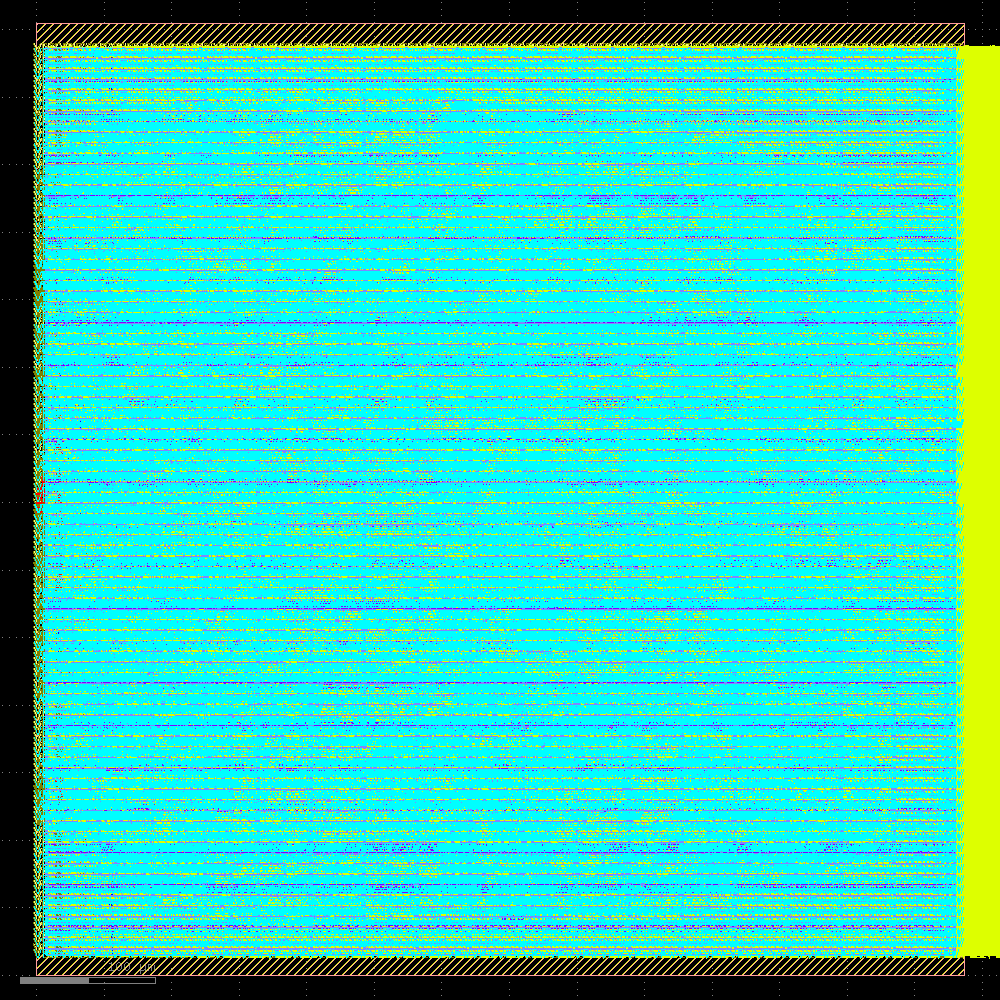

In [ ]:
display(gds)

### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [ ]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

─────────────────────────────────────────────── Design Rule Checks ────────────────────────────────────────────────

[15:18:08] VERBOSE  Running 'Magic.DRC'…                                                               ]8;id=728502;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=200487;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:18:08] VERBOSE  Logging subprocess to ]8;id=80903;file:///content/openlane_run/46-magic-drc/magic-drc.log\openlane_run/]8;;\]8;id=639179;file:///content/openlane_run/46-magic-drc/magic-drc.log\46]8;;\]8;id=80903;file:///content/openlane_run/46-magic-drc/magic-drc.log\-magic-drc/magic-drc.log]8;;\…                     ]8;id=428118;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=313846;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology gf180mcuC ...

10 Magic internal units = 1 Lambda

Input style import: scaleFactor=10, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3    
m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment

Scaled tech values by 10 / 1 to match internal grid scaling

Loading gf180mcuC Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

Warning: Calma reading is not undoable!  I hope that's OK.

Library written using GDS-II Release 6.0

Library name: LIB

Reading "VIA_Via4_1_VH".

Reading "VIA_Via3_HV".

Reading "VIA_Via1_HV".

Reading "VIA_Via2_VH".

Reading "VIA_Via1_VV".

Reading "VIA_via1_2_4000_1200_1_3_1240_1240".

Reading "VIA_via2_3_4000_560_1_4_1040_1040".

Reading "VIA_via3_4_4000_560_1_4_1040_1040".

Reading "VIA_via4_5_4000_4000_3_3_1240_1240".

Reading "gf180mcu_fd_sc_mcu7t5v0__clkinv_2".

Reading "gf180mcu_fd_sc_mcu7t5v0__inv_2".

Reading "gf180mcu_fd_sc_mcu7t5v0__inv_4".

Reading "gf180mcu_fd_sc_mcu7t5v0__clkbuf_2".

Reading "gf180mcu_fd_sc_mcu7t5v0__inv_3".

Reading "gf180mcu_fd_sc_mcu7t5v0__clkinv_8".

Reading "gf180mcu_fd_sc_mcu7t5v0__clkinv_12".

Reading "gf180mcu_fd_sc_mcu7t5v0__clkbuf_8".

Reading "gf180mcu_fd_sc_mcu7t5v0__clkbuf_16".

Reading "gf180mcu_fd_sc_mcu7t5v0__dffrnq_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__dffsnq_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__oai32_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__oai22_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__aoi222_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__nor4_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__mux2_2".

Reading "gf180mcu_fd_sc_mcu7t5v0__and4_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__nor3_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__oai31_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__oai211_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__aoi211_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__nand4_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__aoi221_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__xor3_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__xnor2_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__oai221_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__and3_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__xnor3_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__or2_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__and2_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__aoi22_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__aoi21_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__oai21_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__nor2_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__or3_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__nand3_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__nand2_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__xor2_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__clkinv_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__filltie".

Reading "gf180mcu_fd_sc_mcu7t5v0__endcap".

Reading "gf180mcu_fd_sc_mcu7t5v0__fillcap_64".

Reading "gf180mcu_fd_sc_mcu7t5v0__fillcap_16".

Reading "gf180mcu_fd_sc_mcu7t5v0__fillcap_4".

Reading "gf180mcu_fd_sc_mcu7t5v0__fill_2".

Reading "gf180mcu_fd_sc_mcu7t5v0__fill_1".

Reading "gf180mcu_fd_sc_mcu7t5v0__fillcap_8".

Reading "gf180mcu_fd_sc_mcu7t5v0__fillcap_32".

Reading "qft3_top_pipelined_with_serial".

5000 uses

10000 uses

15000 uses

20000 uses

25000 uses

30000 uses

35000 uses

40000 uses

45000 uses

50000 uses

55000 uses

60000 uses

65000 uses

70000 uses

[INFO] Loading qft3_top_pipelined_with_serial

DRC style is now "drc(full)"

Loading DRC CIF style.

No errors found.

[INFO] COUNT: 0

[INFO] Should be divided by 3 or 4

[INFO] DRC Checking DONE (/content/openlane_run/46-magic-drc/reports/drc_violations.magic.rpt)

[INFO] Saving mag view with DRC errors                                                                             
(/content/openlane_run/46-magic-drc/views/qft3_top_pipelined_with_serial.drc.mag)

[INFO] Saved

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.sdc'), 'sdf': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.sdf'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.sdf'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.sdf'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.sdf'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.sdf'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.sdf'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.sdf'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.sdf'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/qft3_top_pipelined_with_serial.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/qft3_top_pipelined_with_serial.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/qft3_top_pipelined_with_serial.max.spef')}, 'lib': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.lib'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.lib'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.lib'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.lib'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.lib'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.lib'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.lib'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.lib'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/45-klayout-streamout/qft3_top_pipelined_with_serial.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/45-klayout-streamout/qft3_top_pipelined_with_serial.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9970, 'design__instance__area': 269492, 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 64, 'design__die__bbox': '0.0 0.0 686.795 704.715', 'design__core__bbox': '6

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [ ]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

───────────────────────────────────────────── SPICE Model Extraction ──────────────────────────────────────────────

[15:19:04] VERBOSE  Running 'Magic.SpiceExtraction'…                                                   ]8;id=412219;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=539146;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:19:04] VERBOSE  Logging subprocess to                                                              ]8;id=424579;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=79462;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=905074;file:///content/openlane_run/47-magic-spiceextraction/magic-spiceextraction.log\openlane_run/]8;;\]8;id=358817;file:///content/openlane_run/47-magic-spiceextraction/magic-spiceextraction.log\47]8;;\]8;id=905074;file:///content/openlane_run/47-magic-spiceextraction/magic-spiceextraction.log\-magic-spiceextraction/magic-spiceextraction.log]8;;\…                               

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology gf180mcuC ...

10 Magic internal units = 1 Lambda

Input style import: scaleFactor=10, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

obsactive mvobsactive filldiff fillpoly m1hole obsm1 fillm1 obsv1 m2hole obsm2 fillm2 obsv2 m3hole obsm3 fillm3    
m4hole obsm4 fillm4 m5hole obsm5 fillm5 glass fillblock lvstext obscomment

Scaled tech values by 10 / 1 to match internal grid scaling

Loading gf180mcuC Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

> lef read /root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/techlef/gf180mcu_fd_sc_mcu7t5v0__nom.tlef

Reading LEF data from file                                                                                         
/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/techlef/gf180mcu_fd_sc_mcu7t5v0__nom.tlef.

This action cannot be undone.

LEF read, Line 88 (Message): Unknown keyword "MINWIDTH" in LEF file; ignoring.

LEF read, Line 95 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 105 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 106 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 120 (Message): Unknown keyword "ARRAYSPACING" in LEF file; ignoring.

LEF read, Line 125 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 137 (Message): Unknown keyword "MINWIDTH" in LEF file; ignoring.

LEF read, Line 144 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 145 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 146 (Message): Unknown keyword "ANTENNAGATEPLUSDIFF" in LEF file; ignoring.

LEF read, Line 155 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 156 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 172 (Message): Unknown keyword "ARRAYSPACING" in LEF file; ignoring.

LEF read, Line 177 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 189 (Message): Unknown keyword "MINWIDTH" in LEF file; ignoring.

LEF read, Line 196 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 197 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 198 (Message): Unknown keyword "ANTENNAGATEPLUSDIFF" in LEF file; ignoring.

LEF read, Line 207 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 208 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 224 (Message): Unknown keyword "ARRAYSPACING" in LEF file; ignoring.

LEF read, Line 229 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 241 (Message): Unknown keyword "MINWIDTH" in LEF file; ignoring.

LEF read, Line 248 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 249 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 250 (Message): Unknown keyword "ANTENNAGATEPLUSDIFF" in LEF file; ignoring.

LEF read, Line 259 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 260 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 277 (Message): Unknown keyword "ARRAYSPACING" in LEF file; ignoring.

LEF read, Line 282 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 296 (Message): Unknown keyword "MINWIDTH" in LEF file; ignoring.

LEF read, Line 308 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 309 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 310 (Message): Unknown keyword "ANTENNAGATEPLUSDIFF" in LEF file; ignoring.

LEF read, Line 315 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 316 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read: Processed 1380 lines.

> lef read /root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lef/gf180mcu_fd_sc_mcu7t5v0.lef

Reading LEF data from file                                                                                         
/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/lef/gf180mcu_fd_sc_mcu7t5v0.lef.

This action cannot be undone.

LEF read: Processed 26334 lines.

> def read /content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.def -noblockage -labels

Reading DEF data from file /content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.def.

This action cannot be undone.

Processed 4 vias total.

Processed 20262 subcell instances total.

Processed 8 pins total.

Processed 2 special nets total.

Processed 6407 nets total.

DEF read: Processed 127555 lines.

Moving label "_00991_" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_01014_" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_01286_" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_01315_" from metal3 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_01453_" from metal3 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_01829_" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_01991_" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_02683_" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_02713_" from metal3 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_02763_" from metal3 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_02824_" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_02952_" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_03167_" from metal3 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "_03408_" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_4_3_0_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_11_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_14_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_151_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_175_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_176_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_178_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_180_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_209_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_242_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "clknet_leaf_243_clk" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "qft_core_inst.h_q0_p1.alpha_i\[0\]" from metal3 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "qft_core_inst.h_q0_p1.alpha_i\[5\]" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "qft_core_inst.h_q0_p2.alpha_i\[3\]" from metal3 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "qft_core_inst.h_q1_p1.sub_r_s1\[2\]" from metal3 to via2 in cell qft3_top_pipelined_with_serial.

Moving label "qft_core_inst.h_q2_p0.sub_r_s1\[2\]" from metal2 to via2 in cell qft3_top_pipelined_with_serial.

Processing qft3_top_pipelined_with_serial

Extracting gf180mcu_fd_sc_mcu7t5v0__fillcap_32 into gf180mcu_fd_sc_mcu7t5v0__fillcap_32.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__fillcap_64 into gf180mcu_fd_sc_mcu7t5v0__fillcap_64.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__endcap into gf180mcu_fd_sc_mcu7t5v0__endcap.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__filltie into gf180mcu_fd_sc_mcu7t5v0__filltie.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__fillcap_4 into gf180mcu_fd_sc_mcu7t5v0__fillcap_4.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__fillcap_8 into gf180mcu_fd_sc_mcu7t5v0__fillcap_8.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__fill_1 into gf180mcu_fd_sc_mcu7t5v0__fill_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__fill_2 into gf180mcu_fd_sc_mcu7t5v0__fill_2.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 into gf180mcu_fd_sc_mcu7t5v0__clkbuf_8.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__fillcap_16 into gf180mcu_fd_sc_mcu7t5v0__fillcap_16.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 into gf180mcu_fd_sc_mcu7t5v0__dffrnq_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__inv_4 into gf180mcu_fd_sc_mcu7t5v0__inv_4.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__inv_3 into gf180mcu_fd_sc_mcu7t5v0__inv_3.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__inv_2 into gf180mcu_fd_sc_mcu7t5v0__inv_2.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__or2_1 into gf180mcu_fd_sc_mcu7t5v0__or2_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__oai21_1 into gf180mcu_fd_sc_mcu7t5v0__oai21_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__nand2_1 into gf180mcu_fd_sc_mcu7t5v0__nand2_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__xor2_1 into gf180mcu_fd_sc_mcu7t5v0__xor2_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__and2_1 into gf180mcu_fd_sc_mcu7t5v0__and2_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__oai221_1 into gf180mcu_fd_sc_mcu7t5v0__oai221_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__clkinv_1 into gf180mcu_fd_sc_mcu7t5v0__clkinv_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__nand3_1 into gf180mcu_fd_sc_mcu7t5v0__nand3_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__xnor2_1 into gf180mcu_fd_sc_mcu7t5v0__xnor2_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__xnor3_1 into gf180mcu_fd_sc_mcu7t5v0__xnor3_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__or3_1 into gf180mcu_fd_sc_mcu7t5v0__or3_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__aoi21_1 into gf180mcu_fd_sc_mcu7t5v0__aoi21_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__xor3_1 into gf180mcu_fd_sc_mcu7t5v0__xor3_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 into gf180mcu_fd_sc_mcu7t5v0__clkbuf_2.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__and3_1 into gf180mcu_fd_sc_mcu7t5v0__and3_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__nor2_1 into gf180mcu_fd_sc_mcu7t5v0__nor2_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__nand4_1 into gf180mcu_fd_sc_mcu7t5v0__nand4_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__aoi22_1 into gf180mcu_fd_sc_mcu7t5v0__aoi22_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__aoi221_1 into gf180mcu_fd_sc_mcu7t5v0__aoi221_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__nor3_1 into gf180mcu_fd_sc_mcu7t5v0__nor3_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__oai31_1 into gf180mcu_fd_sc_mcu7t5v0__oai31_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__clkinv_8 into gf180mcu_fd_sc_mcu7t5v0__clkinv_8.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__oai211_1 into gf180mcu_fd_sc_mcu7t5v0__oai211_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__clkbuf_16 into gf180mcu_fd_sc_mcu7t5v0__clkbuf_16.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__clkinv_2 into gf180mcu_fd_sc_mcu7t5v0__clkinv_2.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__clkinv_12 into gf180mcu_fd_sc_mcu7t5v0__clkinv_12.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__mux2_2 into gf180mcu_fd_sc_mcu7t5v0__mux2_2.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__and4_1 into gf180mcu_fd_sc_mcu7t5v0__and4_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__nor4_1 into gf180mcu_fd_sc_mcu7t5v0__nor4_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__aoi222_1 into gf180mcu_fd_sc_mcu7t5v0__aoi222_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 into gf180mcu_fd_sc_mcu7t5v0__dffsnq_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__oai22_1 into gf180mcu_fd_sc_mcu7t5v0__oai22_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__oai32_1 into gf180mcu_fd_sc_mcu7t5v0__oai32_1.ext:

Extracting gf180mcu_fd_sc_mcu7t5v0__aoi211_1 into gf180mcu_fd_sc_mcu7t5v0__aoi211_1.ext:

Extracting qft3_top_pipelined_with_serial into qft3_top_pipelined_with_serial.ext:

exttospice finished.

Using technology "gf180mcuC", version 1.0.465-2-gbdc9412

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.sdc'), 'sdf': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.sdf'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.sdf'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.sdf'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.sdf'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.sdf'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.sdf'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.sdf'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.sdf'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/qft3_top_pipelined_with_serial.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/qft3_top_pipelined_with_serial.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/qft3_top_pipelined_with_serial.max.spef')}, 'lib': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.lib'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.lib'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.lib'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.lib'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.lib'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.lib'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.lib'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.lib'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.lib')}, 'spice': Path('/content/openlane_run/47-magic-spiceextraction/qft3_top_pipelined_with_serial.spice'), 'mag': None, 'gds': Path('/content/openlane_run/45-klayout-streamout/qft3_top_pipelined_with_serial.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/45-klayout-streamout/qft3_top_pipelined_with_serial.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9970, 'design__instance__area': 269492, 'design__instance_unmapped__count': 0, 'synthesis__check_erro

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [ ]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()

─────────────────────────────────────────────────── Netgen LVS ────────────────────────────────────────────────────

[15:19:20] VERBOSE  Running 'Netgen.LVS'…                                                              ]8;id=438166;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=147271;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[15:19:20] VERBOSE  Logging subprocess to ]8;id=132028;file:///content/openlane_run/48-netgen-lvs/netgen-lvs.log\openlane_run/]8;;\]8;id=832784;file:///content/openlane_run/48-netgen-lvs/netgen-lvs.log\48]8;;\]8;id=132028;file:///content/openlane_run/48-netgen-lvs/netgen-lvs.log\-netgen-lvs/netgen-lvs.log]8;;\…                   ]8;id=956691;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=950989;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Netgen 1.5.270 compiled on Sun Jun  2 19:00:27 UTC 2024

Warning: netgen command 'format' use fully-qualified name '::netgen::format'

Warning: netgen command 'global' use fully-qualified name '::netgen::global'

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Reading SPICE netlist file                                                                                         
'/root/.volare/gf180mcuC/libs.ref/gf180mcu_fd_sc_mcu7t5v0/spice/gf180mcu_fd_sc_mcu7t5v0.spice'...

Call to undefined subcircuit nfet_06v0

Creating placeholder cell definition.

Call to undefined subcircuit pfet_06v0

Creating placeholder cell definition.

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Note:  Implicit pin Z in instance clkload0 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload1 of gf180mcu_fd_sc_mcu7t5v0__clkinv_12 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload2 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload3 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload4 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload5 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload6 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload7 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload8 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload9 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload10 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload11 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload12 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload13 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload14 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload15 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload16 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload17 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload18 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload19 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload20 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload21 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload22 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload23 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload24 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload25 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload26 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload27 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload28 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload29 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload30 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload31 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload32 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload33 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload34 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload35 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload36 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload37 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload38 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload39 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload40 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload41 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload42 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload43 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload44 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload45 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload46 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload47 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload48 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload49 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload50 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload51 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload52 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload53 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload54 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload55 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload56 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload57 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload58 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload59 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload60 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload61 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload62 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload63 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload64 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload65 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload66 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload67 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload68 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload69 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload70 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload71 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload72 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload73 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload74 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload75 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload76 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload77 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload78 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload79 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload80 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload81 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload82 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload83 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload84 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload85 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload86 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload87 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload88 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload89 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload90 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload91 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload92 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload93 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload94 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload95 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload96 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                           
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload97 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload98 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload99 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                             
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload100 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload101 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload102 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload103 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload104 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload105 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload106 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload107 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload108 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload109 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload110 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload111 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload112 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload113 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload114 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload115 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload116 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload117 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload118 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload119 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload120 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload121 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload122 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload123 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload124 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload125 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload126 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload127 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload128 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload129 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload130 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload131 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload132 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload133 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload134 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload135 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload136 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload137 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload138 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload139 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload140 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload141 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload142 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload143 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload144 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload145 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload146 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload147 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload148 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload149 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload150 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload151 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload152 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload153 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload154 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload155 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload156 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload157 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload158 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload159 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload160 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload161 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload162 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload163 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload164 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload165 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload166 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload167 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload168 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload169 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload170 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload171 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload172 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload173 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload174 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload175 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload176 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload177 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload178 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload179 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload180 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload181 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload182 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload183 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload184 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload185 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload186 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload187 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload188 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload189 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload190 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload191 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload192 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload193 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload194 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload195 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload196 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload197 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload198 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload199 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload200 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload201 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload202 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload203 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload204 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload205 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload206 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload207 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload208 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload209 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload210 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload211 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload212 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload213 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload214 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload215 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload216 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload217 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload218 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload219 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload220 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload221 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload222 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload223 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload224 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload225 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload226 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload227 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload228 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload229 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload230 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload231 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload232 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload233 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload234 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload235 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload236 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload237 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload238 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload239 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload240 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload241 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload242 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload243 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload244 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload245 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload246 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload247 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload248 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload249 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload250 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload251 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload252 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload253 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload254 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload255 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload256 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload257 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload258 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload259 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload260 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload261 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload262 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload263 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload264 of gf180mcu_fd_sc_mcu7t5v0__clkinv_2 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload265 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload266 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload267 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload268 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload269 of gf180mcu_fd_sc_mcu7t5v0__inv_3 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin Z in instance clkload270 of gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 in cell                          
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload271 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload272 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload273 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload274 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload275 of gf180mcu_fd_sc_mcu7t5v0__inv_2 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload276 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload277 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload278 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload279 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload280 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload281 of gf180mcu_fd_sc_mcu7t5v0__inv_4 in cell                            
qft3_top_pipelined_with_serial

Note:  Implicit pin ZN in instance clkload282 of gf180mcu_fd_sc_mcu7t5v0__clkinv_8 in cell                         
qft3_top_pipelined_with_serial

Treating empty subcircuits as black-box cells

Generating JSON file result

Reading setup file /content/openlane_ipynb/openlane/scripts/netgen/setup.tcl

Model nfet_06v0 pin 1 == 3

No property par1 found for device nfet_06v0

No property NRD found for device nfet_06v0

No property NRS found for device nfet_06v0

No property par found for device nfet_06v0

No property sa found for device nfet_06v0

No property sb found for device nfet_06v0

No property sd found for device nfet_06v0

No property par found for device nfet_06v0

No property dtemp found for device nfet_06v0

No property nf found for device nfet_06v0

No property as found for device nfet_06v0

No property ad found for device nfet_06v0

No property ps found for device nfet_06v0

No property pd found for device nfet_06v0

Model pfet_06v0 pin 1 == 3

No property par1 found for device pfet_06v0

No property NRD found for device pfet_06v0

No property NRS found for device pfet_06v0

No property par found for device pfet_06v0

No property sa found for device pfet_06v0

No property sb found for device pfet_06v0

No property sd found for device pfet_06v0

No property par found for device pfet_06v0

No property dtemp found for device pfet_06v0

No property nf found for device pfet_06v0

No property as found for device pfet_06v0

No property ad found for device pfet_06v0

No property ps found for device pfet_06v0

No property pd found for device pfet_06v0

No property par1 found for device diode_nd2ps_06v0

No property par1 found for device diode_pd2nw_06v0

Comparison output logged to file /content/openlane_run/48-netgen-lvs/reports/lvs.netgen.rpt

Logging to file "/content/openlane_run/48-netgen-lvs/reports/lvs.netgen.rpt" enabled

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__xor2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__xor2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__xor2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__xor2_1 contains 10 device instances.

Class: pfet_06v0             instances:   5

Class: nfet_06v0             instances:   5

Circuit contains 11 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__xor2_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_8'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_8 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_8'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_8 contains 4 device instances.

Class: pfet_06v0             instances:   2

Class: nfet_06v0             instances:   2

Circuit contains 8 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_8 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__xor3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__xor3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__xor3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__xor3_1 contains 20 device instances.

Class: pfet_06v0             instances:  10

Class: nfet_06v0             instances:  10

Circuit contains 17 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__xor3_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__dffrnq_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__dffrnq_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 contains 28 device instances.

Class: pfet_06v0             instances:  14

Class: nfet_06v0             instances:  14

Circuit contains 20 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__or2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__or2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__or2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__or2_1 contains 6 device instances.

Class: pfet_06v0             instances:   3

Class: nfet_06v0             instances:   3

Circuit contains 9 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__or2_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai21_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai21_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai21_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai21_1 contains 6 device instances.

Class: pfet_06v0             instances:   3

Class: nfet_06v0             instances:   3

Circuit contains 10 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__oai21_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_4'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_4 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_4'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_4 contains 2 device instances.

Class: pfet_06v0             instances:   1

Class: nfet_06v0             instances:   1

Circuit contains 6 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_4 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_16'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_16 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_16'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_16 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 12 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_16 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__xnor3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__xnor3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__xnor3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__xnor3_1 contains 20 device instances.

Class: pfet_06v0             instances:  10

Class: nfet_06v0             instances:  10

Circuit contains 17 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__xnor3_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__xnor2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__xnor2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__xnor2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__xnor2_1 contains 10 device instances.

Class: pfet_06v0             instances:   5

Class: nfet_06v0             instances:   5

Circuit contains 11 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__xnor2_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_32'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_32 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_32'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_32 contains 16 device instances.

Class: pfet_06v0             instances:   8

Class: nfet_06v0             instances:   8

Circuit contains 20 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_32 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nand3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nand3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nand3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nand3_1 contains 6 device instances.

Class: pfet_06v0             instances:   3

Class: nfet_06v0             instances:   3

Circuit contains 10 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__nand3_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_64'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_64 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__fillcap_64'

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_64 contains 32 device instances.

Class: pfet_06v0             instances:  16

Class: nfet_06v0             instances:  16

Circuit contains 36 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__fillcap_64 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nand2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nand2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nand2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nand2_1 contains 4 device instances.

Class: pfet_06v0             instances:   2

Class: nfet_06v0             instances:   2

Circuit contains 8 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__nand2_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nor2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nor2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nor2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nor2_1 contains 4 device instances.

Class: pfet_06v0             instances:   2

Class: nfet_06v0             instances:   2

Circuit contains 8 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__nor2_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__and3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__and3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__and3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__and3_1 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 11 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__and3_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__or3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__or3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__or3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__or3_1 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 11 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__or3_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkinv_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_1 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkinv_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_1 contains 2 device instances.

Class: pfet_06v0             instances:   1

Class: nfet_06v0             instances:   1

Circuit contains 6 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__and2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__and2_1 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__and2_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__and2_1 contains 6 device instances.

Class: pfet_06v0             instances:   3

Class: nfet_06v0             instances:   3

Circuit contains 9 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__and2_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi21_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi21_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi21_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi21_1 contains 6 device instances.

Class: pfet_06v0             instances:   3

Class: nfet_06v0             instances:   3

Circuit contains 10 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi21_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi22_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi22_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi22_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi22_1 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 12 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi22_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkbuf_8'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkbuf_8'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 contains 23 device instances.

Class: pfet_06v0             instances:  12

Class: nfet_06v0             instances:  11

Circuit contains 7 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nand4_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nand4_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nand4_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nand4_1 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 12 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__nand4_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__mux2_2'

Circuit gf180mcu_fd_sc_mcu7t5v0__mux2_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__mux2_2'

Circuit gf180mcu_fd_sc_mcu7t5v0__mux2_2 contains 14 device instances.

Class: pfet_06v0             instances:   7

Class: nfet_06v0             instances:   7

Circuit contains 14 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__mux2_2 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkbuf_2'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkbuf_2'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 contains 6 device instances.

Class: pfet_06v0             instances:   3

Class: nfet_06v0             instances:   3

Circuit contains 7 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai221_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai221_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai221_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai221_1 contains 10 device instances.

Class: pfet_06v0             instances:   5

Class: nfet_06v0             instances:   5

Circuit contains 14 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__oai221_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkbuf_16'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkbuf_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkbuf_16'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkbuf_16 contains 46 device instances.

Class: pfet_06v0             instances:  24

Class: nfet_06v0             instances:  22

Circuit contains 7 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__clkbuf_16 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai211_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai211_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai211_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai211_1 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 12 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__oai211_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi221_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi221_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi221_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi221_1 contains 10 device instances.

Class: pfet_06v0             instances:   5

Class: nfet_06v0             instances:   5

Circuit contains 14 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi221_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai22_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai22_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai22_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai22_1 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 12 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__oai22_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nor3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nor3_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nor3_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nor3_1 contains 6 device instances.

Class: pfet_06v0             instances:   3

Class: nfet_06v0             instances:   3

Circuit contains 10 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__nor3_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__inv_4'

Circuit gf180mcu_fd_sc_mcu7t5v0__inv_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__inv_4'

Circuit gf180mcu_fd_sc_mcu7t5v0__inv_4 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 6 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__inv_4 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__inv_2'

Circuit gf180mcu_fd_sc_mcu7t5v0__inv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__inv_2'

Circuit gf180mcu_fd_sc_mcu7t5v0__inv_2 contains 4 device instances.

Class: pfet_06v0             instances:   2

Class: nfet_06v0             instances:   2

Circuit contains 6 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__inv_2 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai31_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai31_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai31_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai31_1 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 12 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__oai31_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__inv_3'

Circuit gf180mcu_fd_sc_mcu7t5v0__inv_3 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__inv_3'

Circuit gf180mcu_fd_sc_mcu7t5v0__inv_3 contains 6 device instances.

Class: pfet_06v0             instances:   3

Class: nfet_06v0             instances:   3

Circuit contains 6 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__inv_3 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi222_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi222_1 contains 0 device instances.

Circuit contains 0 nets, and 11 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi222_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi222_1 contains 12 device instances.

Class: pfet_06v0             instances:   6

Class: nfet_06v0             instances:   6

Circuit contains 16 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi222_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkinv_2'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkinv_2'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_2 contains 4 device instances.

Class: pfet_06v0             instances:   2

Class: nfet_06v0             instances:   2

Circuit contains 6 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_2 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkinv_8'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkinv_8'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_8 contains 16 device instances.

Class: pfet_06v0             instances:   8

Class: nfet_06v0             instances:   8

Circuit contains 6 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_8 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__and4_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__and4_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__and4_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__and4_1 contains 10 device instances.

Class: pfet_06v0             instances:   5

Class: nfet_06v0             instances:   5

Circuit contains 13 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__and4_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkinv_12'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_12 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__clkinv_12'

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_12 contains 24 device instances.

Class: pfet_06v0             instances:  12

Class: nfet_06v0             instances:  12

Circuit contains 6 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__clkinv_12 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nor4_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nor4_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__nor4_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__nor4_1 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 12 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__nor4_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi211_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi211_1 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__aoi211_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi211_1 contains 8 device instances.

Class: pfet_06v0             instances:   4

Class: nfet_06v0             instances:   4

Circuit contains 12 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__aoi211_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai32_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai32_1 contains 0 device instances.

Circuit contains 0 nets, and 10 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__oai32_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__oai32_1 contains 10 device instances.

Class: pfet_06v0             instances:   5

Class: nfet_06v0             instances:   5

Circuit contains 14 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__oai32_1 contains no devices.

Contents of circuit 1:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__dffsnq_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'gf180mcu_fd_sc_mcu7t5v0__dffsnq_1'

Circuit gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 contains 28 device instances.

Class: pfet_06v0             instances:  14

Class: nfet_06v0             instances:  14

Circuit contains 20 nets.

Circuit gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 contains no devices.

Contents of circuit 1:  Circuit: 'qft3_top_pipelined_with_serial'

Circuit qft3_top_pipelined_with_serial contains 12181 device instances.

Class: gf180mcu_fd_sc_mcu7t5v0__nand3_1 instances:  69

Class: gf180mcu_fd_sc_mcu7t5v0__oai221_1 instances:  47

Class: gf180mcu_fd_sc_mcu7t5v0__aoi222_1 instances:  22

Class: gf180mcu_fd_sc_mcu7t5v0__and3_1 instances: 133

Class: gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 instances: 1979

Class: gf180mcu_fd_sc_mcu7t5v0__nand2_1 instances: 521

Class: gf180mcu_fd_sc_mcu7t5v0__oai32_1 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__oai211_1 instances:  13

Class: gf180mcu_fd_sc_mcu7t5v0__aoi22_1 instances: 113

Class: gf180mcu_fd_sc_mcu7t5v0__aoi221_1 instances:  43

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 instances:  36

Class: gf180mcu_fd_sc_mcu7t5v0__mux2_2 instances:  57

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 instances: 338

Class: gf180mcu_fd_sc_mcu7t5v0__and2_1 instances: 267

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_12 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__nor4_1 instances:   4

Class: gf180mcu_fd_sc_mcu7t5v0__oai31_1 instances:  13

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_1 instances: 424

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_2 instances:  35

Class: gf180mcu_fd_sc_mcu7t5v0__oai22_1 instances:   5

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_8 instances:  24

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_16 instances:  33

Class: gf180mcu_fd_sc_mcu7t5v0__aoi21_1 instances: 409

Class: gf180mcu_fd_sc_mcu7t5v0__aoi211_1 instances:   2

Class: gf180mcu_fd_sc_mcu7t5v0__inv_2 instances:  47

Class: gf180mcu_fd_sc_mcu7t5v0__inv_3 instances:  42

Class: gf180mcu_fd_sc_mcu7t5v0__inv_4 instances:  91

Class: gf180mcu_fd_sc_mcu7t5v0__xnor3_1 instances: 100

Class: gf180mcu_fd_sc_mcu7t5v0__nor3_1 instances:  28

Class: gf180mcu_fd_sc_mcu7t5v0__or3_1 instances: 117

Class: gf180mcu_fd_sc_mcu7t5v0__oai21_1 instances: 290

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_4 instances: 2148

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_8 instances: 1570

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_64 instances: 405

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_16 instances: 960

Class: gf180mcu_fd_sc_mcu7t5v0__xor3_1 instances: 124

Class: gf180mcu_fd_sc_mcu7t5v0__xnor2_1 instances:  75

Class: gf180mcu_fd_sc_mcu7t5v0__nor2_1 instances: 440

Class: gf180mcu_fd_sc_mcu7t5v0__nand4_1 instances:  57

Class: gf180mcu_fd_sc_mcu7t5v0__or2_1 instances: 120

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_32 instances: 413

Class: gf180mcu_fd_sc_mcu7t5v0__xor2_1 instances: 558

Class: gf180mcu_fd_sc_mcu7t5v0__and4_1 instances:   6

Circuit contains 6692 nets.

Contents of circuit 2:  Circuit: 'qft3_top_pipelined_with_serial'

Circuit qft3_top_pipelined_with_serial contains 12181 device instances.

Class: gf180mcu_fd_sc_mcu7t5v0__nand3_1 instances:  69

Class: gf180mcu_fd_sc_mcu7t5v0__oai221_1 instances:  47

Class: gf180mcu_fd_sc_mcu7t5v0__aoi222_1 instances:  22

Class: gf180mcu_fd_sc_mcu7t5v0__and3_1 instances: 133

Class: gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 instances: 1979

Class: gf180mcu_fd_sc_mcu7t5v0__nand2_1 instances: 521

Class: gf180mcu_fd_sc_mcu7t5v0__oai32_1 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__oai211_1 instances:  13

Class: gf180mcu_fd_sc_mcu7t5v0__aoi22_1 instances: 113

Class: gf180mcu_fd_sc_mcu7t5v0__aoi221_1 instances:  43

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 instances:  36

Class: gf180mcu_fd_sc_mcu7t5v0__mux2_2 instances:  57

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 instances: 338

Class: gf180mcu_fd_sc_mcu7t5v0__and2_1 instances: 267

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_12 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__nor4_1 instances:   4

Class: gf180mcu_fd_sc_mcu7t5v0__oai31_1 instances:  13

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_1 instances: 424

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_2 instances:  35

Class: gf180mcu_fd_sc_mcu7t5v0__oai22_1 instances:   5

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_8 instances:  24

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_16 instances:  33

Class: gf180mcu_fd_sc_mcu7t5v0__aoi21_1 instances: 409

Class: gf180mcu_fd_sc_mcu7t5v0__aoi211_1 instances:   2

Class: gf180mcu_fd_sc_mcu7t5v0__inv_2 instances:  47

Class: gf180mcu_fd_sc_mcu7t5v0__inv_3 instances:  42

Class: gf180mcu_fd_sc_mcu7t5v0__inv_4 instances:  91

Class: gf180mcu_fd_sc_mcu7t5v0__xnor3_1 instances: 100

Class: gf180mcu_fd_sc_mcu7t5v0__nor3_1 instances:  28

Class: gf180mcu_fd_sc_mcu7t5v0__or3_1 instances: 117

Class: gf180mcu_fd_sc_mcu7t5v0__oai21_1 instances: 290

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_4 instances: 2148

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_8 instances: 1570

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_64 instances: 405

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_16 instances: 960

Class: gf180mcu_fd_sc_mcu7t5v0__xor3_1 instances: 124

Class: gf180mcu_fd_sc_mcu7t5v0__xnor2_1 instances:  75

Class: gf180mcu_fd_sc_mcu7t5v0__nor2_1 instances: 440

Class: gf180mcu_fd_sc_mcu7t5v0__nand4_1 instances:  57

Class: gf180mcu_fd_sc_mcu7t5v0__or2_1 instances: 120

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_32 instances: 413

Class: gf180mcu_fd_sc_mcu7t5v0__xor2_1 instances: 558

Class: gf180mcu_fd_sc_mcu7t5v0__and4_1 instances:   6

Circuit contains 6692 nets.

Circuit was modified by parallel/series device merging.

New circuit summary:

Contents of circuit 1:  Circuit: 'qft3_top_pipelined_with_serial'

Circuit qft3_top_pipelined_with_serial contains 6690 device instances.

Class: gf180mcu_fd_sc_mcu7t5v0__nand3_1 instances:  69

Class: gf180mcu_fd_sc_mcu7t5v0__oai221_1 instances:  47

Class: gf180mcu_fd_sc_mcu7t5v0__aoi222_1 instances:  22

Class: gf180mcu_fd_sc_mcu7t5v0__and3_1 instances: 133

Class: gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 instances: 1979

Class: gf180mcu_fd_sc_mcu7t5v0__nand2_1 instances: 521

Class: gf180mcu_fd_sc_mcu7t5v0__oai32_1 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__oai211_1 instances:  13

Class: gf180mcu_fd_sc_mcu7t5v0__aoi22_1 instances: 113

Class: gf180mcu_fd_sc_mcu7t5v0__aoi221_1 instances:  43

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 instances:  36

Class: gf180mcu_fd_sc_mcu7t5v0__mux2_2 instances:  57

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 instances: 338

Class: gf180mcu_fd_sc_mcu7t5v0__and2_1 instances: 267

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_12 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__nor4_1 instances:   4

Class: gf180mcu_fd_sc_mcu7t5v0__oai31_1 instances:  13

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_1 instances: 424

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_2 instances:  35

Class: gf180mcu_fd_sc_mcu7t5v0__oai22_1 instances:   5

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_8 instances:  24

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_16 instances:  33

Class: gf180mcu_fd_sc_mcu7t5v0__aoi21_1 instances: 409

Class: gf180mcu_fd_sc_mcu7t5v0__aoi211_1 instances:   2

Class: gf180mcu_fd_sc_mcu7t5v0__inv_2 instances:  47

Class: gf180mcu_fd_sc_mcu7t5v0__inv_3 instances:  42

Class: gf180mcu_fd_sc_mcu7t5v0__inv_4 instances:  91

Class: gf180mcu_fd_sc_mcu7t5v0__xnor3_1 instances: 100

Class: gf180mcu_fd_sc_mcu7t5v0__nor3_1 instances:  28

Class: gf180mcu_fd_sc_mcu7t5v0__or3_1 instances: 117

Class: gf180mcu_fd_sc_mcu7t5v0__oai21_1 instances: 290

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_4 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_8 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_64 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_16 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__xor3_1 instances: 124

Class: gf180mcu_fd_sc_mcu7t5v0__xnor2_1 instances:  75

Class: gf180mcu_fd_sc_mcu7t5v0__nor2_1 instances: 440

Class: gf180mcu_fd_sc_mcu7t5v0__nand4_1 instances:  57

Class: gf180mcu_fd_sc_mcu7t5v0__or2_1 instances: 120

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_32 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__xor2_1 instances: 558

Class: gf180mcu_fd_sc_mcu7t5v0__and4_1 instances:   6

Circuit contains 6692 nets.

Contents of circuit 2:  Circuit: 'qft3_top_pipelined_with_serial'

Circuit qft3_top_pipelined_with_serial contains 6690 device instances.

Class: gf180mcu_fd_sc_mcu7t5v0__nand3_1 instances:  69

Class: gf180mcu_fd_sc_mcu7t5v0__oai221_1 instances:  47

Class: gf180mcu_fd_sc_mcu7t5v0__aoi222_1 instances:  22

Class: gf180mcu_fd_sc_mcu7t5v0__and3_1 instances: 133

Class: gf180mcu_fd_sc_mcu7t5v0__dffsnq_1 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__dffrnq_1 instances: 1979

Class: gf180mcu_fd_sc_mcu7t5v0__nand2_1 instances: 521

Class: gf180mcu_fd_sc_mcu7t5v0__oai32_1 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__oai211_1 instances:  13

Class: gf180mcu_fd_sc_mcu7t5v0__aoi22_1 instances: 113

Class: gf180mcu_fd_sc_mcu7t5v0__aoi221_1 instances:  43

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_2 instances:  36

Class: gf180mcu_fd_sc_mcu7t5v0__mux2_2 instances:  57

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_8 instances: 338

Class: gf180mcu_fd_sc_mcu7t5v0__and2_1 instances: 267

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_12 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__nor4_1 instances:   4

Class: gf180mcu_fd_sc_mcu7t5v0__oai31_1 instances:  13

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_1 instances: 424

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_2 instances:  35

Class: gf180mcu_fd_sc_mcu7t5v0__oai22_1 instances:   5

Class: gf180mcu_fd_sc_mcu7t5v0__clkinv_8 instances:  24

Class: gf180mcu_fd_sc_mcu7t5v0__clkbuf_16 instances:  33

Class: gf180mcu_fd_sc_mcu7t5v0__aoi21_1 instances: 409

Class: gf180mcu_fd_sc_mcu7t5v0__aoi211_1 instances:   2

Class: gf180mcu_fd_sc_mcu7t5v0__inv_2 instances:  47

Class: gf180mcu_fd_sc_mcu7t5v0__inv_3 instances:  42

Class: gf180mcu_fd_sc_mcu7t5v0__inv_4 instances:  91

Class: gf180mcu_fd_sc_mcu7t5v0__xnor3_1 instances: 100

Class: gf180mcu_fd_sc_mcu7t5v0__nor3_1 instances:  28

Class: gf180mcu_fd_sc_mcu7t5v0__or3_1 instances: 117

Class: gf180mcu_fd_sc_mcu7t5v0__oai21_1 instances: 290

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_4 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_8 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_64 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_16 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__xor3_1 instances: 124

Class: gf180mcu_fd_sc_mcu7t5v0__xnor2_1 instances:  75

Class: gf180mcu_fd_sc_mcu7t5v0__nor2_1 instances: 440

Class: gf180mcu_fd_sc_mcu7t5v0__nand4_1 instances:  57

Class: gf180mcu_fd_sc_mcu7t5v0__or2_1 instances: 120

Class: gf180mcu_fd_sc_mcu7t5v0__fillcap_32 instances:   1

Class: gf180mcu_fd_sc_mcu7t5v0__xor2_1 instances: 558

Class: gf180mcu_fd_sc_mcu7t5v0__and4_1 instances:   6

Circuit contains 6692 nets.

Circuit 1 contains 6690 devices, Circuit 2 contains 6690 devices.

Circuit 1 contains 6692 nets,    Circuit 2 contains 6692 nets.

Final result:

Circuits match uniquely.

.

Logging to file "/content/openlane_run/48-netgen-lvs/reports/lvs.netgen.rpt" disabled

LVS Done.

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/qft3_top_pipelined_with_serial.sdc'), 'sdf': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.sdf'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.sdf'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.sdf'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.sdf'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.sdf'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.sdf'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.sdf'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.sdf'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/qft3_top_pipelined_with_serial.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/qft3_top_pipelined_with_serial.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/qft3_top_pipelined_with_serial.max.spef')}, 'lib': {'nom_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/nom_tt_025C_5v00/qft3_top_pipelined_with_serial__nom_tt_025C_5v00.lib'), 'nom_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ss_125C_4v50/qft3_top_pipelined_with_serial__nom_ss_125C_4v50.lib'), 'nom_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/nom_ff_n40C_5v50/qft3_top_pipelined_with_serial__nom_ff_n40C_5v50.lib'), 'min_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/min_tt_025C_5v00/qft3_top_pipelined_with_serial__min_tt_025C_5v00.lib'), 'min_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ss_125C_4v50/qft3_top_pipelined_with_serial__min_ss_125C_4v50.lib'), 'min_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/min_ff_n40C_5v50/qft3_top_pipelined_with_serial__min_ff_n40C_5v50.lib'), 'max_tt_025C_5v00': Path('/content/openlane_run/44-openroad-stapostpnr/max_tt_025C_5v00/qft3_top_pipelined_with_serial__max_tt_025C_5v00.lib'), 'max_ss_125C_4v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ss_125C_4v50/qft3_top_pipelined_with_serial__max_ss_125C_4v50.lib'), 'max_ff_n40C_5v50': Path('/content/openlane_run/44-openroad-stapostpnr/max_ff_n40C_5v50/qft3_top_pipelined_with_serial__max_ff_n40C_5v50.lib')}, 'spice': Path('/content/openlane_run/47-magic-spiceextraction/qft3_top_pipelined_with_serial.spice'), 'mag': None, 'gds': Path('/content/openlane_run/45-klayout-streamout/qft3_top_pipelined_with_serial.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/45-klayout-streamout/qft3_top_pipelined_with_serial.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 9970, 'design__instance__area': 269492, 'design__instance_unmapped__count': 0, 'synthesis__check_erro